# Functions Definition

In [25]:
import numpy as np
import pandas as pd
import datetime as dt
from collections import namedtuple
import ast, swifter
import math
import portion as P
from pprint import pprint

# ************************************************* unify data format *************************************************

def set_data(df, mode='pcap', tz=0):
    def nr_serv_cel(row):
        pos = row.serv_cel_pos
        if pos == 255:
            return 65535, -160, -50
        else:
            return row[f'PCI{pos}'], row[f'RSRP{pos}'], row[f'RSRQ{pos}']
    
    if mode == 'pcap':
        common_column_names = ['seq', 'rpkg', 'frame_id', 'Timestamp', 'lost', 'excl', 'latency', 'xmit_time', 'arr_time']
        
        if df.empty:
            return pd.DataFrame(columns=common_column_names)
        
        date_columns = ['Timestamp', 'xmit_time', 'arr_time']
        df[date_columns] = df[date_columns].apply(pd.to_datetime)
        df[['seq', 'rpkg', 'frame_id']] = df[['seq', 'rpkg', 'frame_id']].astype('Int32')
        df[['latency']] = df[['latency']].astype('float32')
        df[['lost', 'excl']] = df[['lost', 'excl']].astype('boolean')

    if mode in ['lte', 'nr']:
        common_column_names = [
            'Timestamp', 'type_id', 'PCI', 'RSRP', 'RSRQ', 'serv_cel_index', 'EARFCN', 'NR_ARFCN', 
            'num_cels', 'num_neigh_cels', 'serv_cel_pos', 'PCI0', 'RSRP0', 'RSRQ0',
        ]
        
        if df.empty:
            return pd.DataFrame(columns=common_column_names)
        
        if mode == 'lte':
            columns_mapping = {
                'RSRP(dBm)': 'RSRP',
                'RSRQ(dB)': 'RSRQ',
                'Serving Cell Index': 'serv_cel_index',
                'Number of Neighbor Cells': 'num_neigh_cels',
                'Number of Detected Cells': 'num_cels',
            }
            columns_order = [*common_column_names, *df.columns[df.columns.get_loc('PCI1'):].tolist()]
            
            df = df.rename(columns=columns_mapping).reindex(columns_order, axis=1)
            df['serv_cel_index'] = np.where(df['serv_cel_index'] == '(MI)Unknown', '3_SCell', df['serv_cel_index'])
            df['num_cels'] = df['num_neigh_cels'] + 1
            df['type_id'] = 'LTE_PHY'

        if mode == 'nr':
            columns_mapping = {
                'Raster ARFCN': 'NR_ARFCN',
                'Serving Cell Index': 'serv_cel_pos',
                'Num Cells': 'num_cels',
            }
            columns_order = [*common_column_names, *df.columns[df.columns.get_loc('PCI1'):].tolist()]
            
            df = df.rename(columns=columns_mapping).reindex(columns_order, axis=1)
            df[['PCI', 'RSRP', 'RSRQ']] = df.apply(nr_serv_cel, axis=1, result_type='expand')
            df['serv_cel_index'] = np.where(df['serv_cel_pos'] == 255, df['serv_cel_index'], 'PSCell')
            df['num_neigh_cels'] = np.where(df['serv_cel_pos'] == 255, df['num_cels'], df['num_cels'] - 1)
            df['type_id'] = '5G_NR_ML1'
        
        df['Timestamp'] = pd.to_datetime(df['Timestamp']) + pd.Timedelta(hours=tz)
        df[['type_id', 'serv_cel_index']] = df[['type_id', 'serv_cel_index']].astype('category')
        df[['EARFCN', 'NR_ARFCN']] = df[['EARFCN', 'NR_ARFCN']].astype('Int32')
        df[['num_cels', 'num_neigh_cels', 'serv_cel_pos']] = df[['num_cels', 'num_neigh_cels', 'serv_cel_pos']].astype('UInt8')

        for tag in df.columns:
            if tag.startswith('PCI'):
                df[tag] = df[tag].astype('Int32')
            if tag.startswith(('RSRP', 'RSRQ')):
                df[tag] = df[tag].astype('float32')

    return df

# ************************************************* Sheng-Ru Latest Version (09-25) add try except (10-27) add nr arfcn (11-13) add BSID (11-21) *************************************************

def parse_mi_ho(df, tz=8):

    # df = pd.read_csv(f)
    df["Timestamp"] = df["Timestamp"].swifter.apply(lambda x: pd.to_datetime(x) + dt.timedelta(hours=tz))
    nr_pci = 'O'
    nr_arfcn = 0
    scells = []

    def NR_OTA(idx):

        if df["type_id"].iloc[idx] == "5G_NR_RRC_OTA_Packet": return True
        else: return False
    
    def LTE_SERV_INFO(idx):

        if df["type_id"].iloc[idx] == "LTE_RRC_Serv_Cell_Info": return True
        else: return False
    

    def find_1st_after(start_idx, target, look_after=1):
        for j in range(start_idx, len(df)):
            t_ = df["Timestamp"].iloc[j]
            if NR_OTA(j) or LTE_SERV_INFO(j):
                continue
            if (t_ - t).total_seconds() > look_after:
                return None, None
            if df[target].iloc[j] not in [0,'0'] and not np.isnan(df[target].iloc[j]):
                return t_, j
        return None, None
    
    def find_1st_before(start_idx, target, look_before=1):
        for j in range(start_idx, -1, -1):
            t_ = df["Timestamp"].iloc[j]
            if NR_OTA(j) or LTE_SERV_INFO(j):
                continue
            if (t - t_).total_seconds() > look_before:
                return None, None
            if df[target].iloc[j] not in [0,'0'] and not np.isnan(df[target].iloc[j]):
                return t_, j
        return None, None
    
    def find_1st_before_with_special_value(start_idx, target, target_value, look_before=1):
        for j in range(start_idx, -1, -1):
            t_ = df["Timestamp"].iloc[j]
            if NR_OTA(j) or LTE_SERV_INFO(j):
                continue
            if (t - t_).total_seconds() > look_before:
                return None, None
            if df[target].iloc[j] in [target_value] and not np.isnan(df[target].iloc[j]):
                return t_, j
        return None, None
    
    def find_in_D_exact(targets):

        l = []
        # In l : (second, ho_type)
        for target in targets:
            for ho in D[target]:
                l.append(((t - ho.start).total_seconds(), target))

        if len(l) != 0:
            for x in l:
                if (x[0]== 0):
                    return x[1]
        
        return None
    
    def find_in_D_first_before(targets, look_before=1):

        l = []
        # In l : (second, ho_type)
        for target in targets:
            for ho in D[target]:
                try:
                    l.append(((t - ho.end).total_seconds(), target, ho))
                except:
                    pass

        if len(l) != 0:
            closest = min(filter(lambda x: x[0] > 0, l), key=lambda x: x[0])
            if 0 <= closest[0] < look_before:
                return closest[1], closest[2]
        
        return None, None
    
    HO = namedtuple('HO',['start', 'end', 'others', 'trans'], defaults=[None,None,'',''])
    
    D = {
        'Conn_Rel':[], 
        'Conn_Req':[], # Setup
        'LTE_HO': [], # LTE -> newLTE
        'MN_HO': [], # LTE + NR -> newLTE + NR
        'MN_HO_to_eNB': [], # LTE + NR -> newLTE
        'SN_setup': [], # LTE -> LTE + NR => NR setup
        'SN_Rel': [], # LTE + NR -> LTE
        'SN_HO': [], # LTE + NR -> LTE + newNR  
        'RLF_II': [],
        'RLF_III': [],
        'SCG_RLF': [],
        'Add_SCell': [],
        }

    for i in range(len(df)):

        # Pass NR RRC packet. In NSA mode, LTE RRC packet include NR packet message.
        if NR_OTA(i) or LTE_SERV_INFO(i):
            continue

        others = ''
        t = df["Timestamp"].iloc[i]

        if df["rrcConnectionRelease"].iloc[i] == 1:
            D['Conn_Rel'].append(HO(start=t))
            nr_pci = 'O'

        if df["rrcConnectionRequest"].iloc[i] == 1:
            
            # Define end of rrcConnectionRequest to be rrcConnectionReconfigurationComplete or securityModeComplete.
            a = find_1st_after(i, 'rrcConnectionReconfigurationComplete',look_after=2)[0]
            b = find_1st_after(i, 'securityModeComplete',look_after=2)[0]
            if a is None and b is None: end = None
            elif a is None and b is not None: end = b
            elif a is not None and b is None: end = a 
            else: end = a if a > b else b
            
            serv_cell, serv_freq = df["PCI"].iloc[i], int(df["Freq"].iloc[i])
            trans = f'? -> ({serv_cell}, {serv_freq})'
            D['Conn_Req'].append(HO(start=t,end=end,trans=trans))
            nr_pci = 'O'
        
        if df["lte-rrc.t304"].iloc[i] == 1:
            
            end, _ = find_1st_after(i, 'rrcConnectionReconfigurationComplete')
            serv_cell, target_cell = df["PCI"].iloc[i], int(df['lte_targetPhysCellId'].iloc[i])
            serv_freq, target_freq = int(df["Freq"].iloc[i]), int(df['dl-CarrierFreq'].iloc[i])

            if df["SCellToAddMod-r10"].iloc[i] == 1:
                n =len(str(df["SCellIndex-r10.1"].iloc[i]).split('@'))
                others += f' Set up {n} SCell.'
            else:
                scells = []
            
            if serv_freq != target_freq:
                a,b = find_1st_before(i, "rrcConnectionReestablishmentRequest", 1)
                others += " Inter frequency HO."
                if a is not None:
                    others += " Near after RLF."
                
            if df["nr-rrc.t304"].iloc[i] == 1 and df["dualConnectivityPHR: setup (1)"].iloc[i] == 1:
                
                if serv_cell == target_cell and serv_freq == target_freq:

                    a, _ = find_1st_before(i, "rrcConnectionReestablishmentRequest", 2)
                    
                    if a is not None:

                        ho_type, ho = find_in_D_first_before(['RLF_II', 'RLF_III'], 2)
                        try:
                            others += f' Near after RLF of trans: {ho.trans}.'
                        except:
                            others += f' Near after RLF.'

                    else:
                        
                        ho_type, _ = find_in_D_first_before(['MN_HO_to_eNB', 'SN_Rel'], 2)
                        if ho_type is not None:
                            others += f' Near after {ho_type}.'
                    orig_serv = (nr_pci, nr_arfcn) if nr_pci != 'O' else 'O'
                    nr_pci = int(df['nr_physCellId'].iloc[i])
                    nr_arfcn = int(df['absoluteFrequencySSB'].iloc[i])
                    trans = f'({serv_cell}, {serv_freq}) | {orig_serv} -> ({nr_pci}, {nr_arfcn})'
                    D['SN_setup'].append(HO(start=t, end=end, others=others, trans=trans))

                else:
                    
                    nr_pci = int(df['nr_physCellId'].iloc[i])
                    trans = f'({serv_cell}, {serv_freq}) -> ({target_cell}, {target_freq}) | ({nr_pci}, {nr_arfcn})'
                    D['MN_HO'].append(HO(start=t, end=end, others=others, trans=trans))

            else:
                
                if serv_cell == target_cell and serv_freq == target_freq:

                    a, b = find_1st_before(i, "scgFailureInformationNR-r15")
                    if a is not None:
                        others += " Caused by scg-failure."
                    
                    orig_serv = (nr_pci, nr_arfcn) if nr_pci != 'O' else 'O'
                    nr_pci = 'O'
                    trans = f'({serv_cell}, {serv_freq}) | {orig_serv} -> {nr_pci}'
                    D['SN_Rel'].append(HO(start=t, end=end, others=others, trans=trans))
                    
                else:

                    a, _ = find_1st_before(i,"rrcConnectionSetup",3)
                    if a is not None:
                        others += ' Near After connection setup.'
                    if nr_pci == 'O':
                        trans = f'({serv_cell}, {serv_freq}) -> ({target_cell}, {target_freq}) | {nr_pci}'
                        D['LTE_HO'].append(HO(start=t, end=end, others=others, trans=trans))
                    else:
                        orig_serv = (nr_pci, nr_arfcn) if nr_pci != 'O' else 'O'
                        nr_pci = 'O'
                        trans = f'({serv_cell}, {serv_freq}) -> ({target_cell}, {target_freq}) | {orig_serv} -> {nr_pci}'
                        D['MN_HO_to_eNB'].append(HO(start=t, end=end, others=others, trans=trans))


        if df["nr-rrc.t304"].iloc[i] == 1 and not df["dualConnectivityPHR: setup (1)"].iloc[i] == 1:

            end, _ = find_1st_after(i,'rrcConnectionReconfigurationComplete')
        
            serv_cell, serv_freq = df["PCI"].iloc[i], int(df["Freq"].iloc[i])
            orig_serv = (nr_pci, nr_arfcn) if nr_pci != 'O' else 'O'
            nr_pci = int(df['nr_physCellId'].iloc[i])
            nr_arfcn = int(df['absoluteFrequencySSB'].iloc[i])
            trans = f'({serv_cell}, {serv_freq}) | {orig_serv} -> ({nr_pci}, {nr_arfcn})'
            D['SN_HO'].append(HO(start=t,end=end,trans=trans))


        if df["rrcConnectionReestablishmentRequest"].iloc[i] == 1:

            end1, _ = find_1st_after(i, 'rrcConnectionReestablishmentComplete', look_after=1)
            b, _ = find_1st_after(i, 'rrcConnectionReestablishmentReject', look_after=1)
            end2, _ = find_1st_after(i, 'securityModeComplete',look_after=3)

            others += ' ' + df["reestablishmentCause"].iloc[i] + '.'
            scells = []

            c, _ = find_1st_before(i, 'scgFailureInformationNR-r15', 1)
            if c != None:
                others  += ' caused by scgfailure.'
                
            serv_cell, rlf_cell = df["PCI"].iloc[i], int(df['physCellId.3'].iloc[i])
            serv_freq = int(df['Freq'].iloc[i])
            
            # Type II & Type III
            if end1 is not None: 

                orig_serv = (nr_pci, nr_arfcn) if nr_pci != 'O' else 'O'
                nr_pci = 'O'
                _, idx = find_1st_before_with_special_value(i, 'PCI', rlf_cell, look_before=10)
                try:
                    rlf_freq = int(df['Freq'].iloc[idx])
                except:
                    rlf_freq = 0
                trans = f'({rlf_cell}, {rlf_freq}) -> ({serv_cell}, {serv_freq}) | {orig_serv} -> {nr_pci}'
                D['RLF_II'].append(HO(start=t,end=end1,others=others,trans=trans))

            elif b is not None and end2 is not None:
                
                orig_serv = (nr_pci, nr_arfcn) if nr_pci != 'O' else 'O'
                nr_pci = 'O'
                _, idx = find_1st_before_with_special_value(i, 'PCI', rlf_cell, look_before=10)
                try:
                    rlf_freq = int(df['Freq'].iloc[idx])
                except:
                    rlf_freq = 0

                _, idx = find_1st_after(i, "rrcConnectionRequest", 2)
                recon_cell, recon_freq = df['PCI'].iloc[idx], int(float(df['Freq'].iloc[idx]))
                
                trans = f'({rlf_cell}, {rlf_freq}) -> ({recon_cell}, {recon_freq}) | {orig_serv} -> {nr_pci}'
                D['RLF_III'].append(HO(start=t,end=end2,others=others,trans=trans))
                
            else:
                others+=' No end.'
                D['RLF_II'].append(HO(start=t,others=others))
                print('No end for RLF')

        if df["scgFailureInformationNR-r15"].iloc[i] == 1:

            others += ' ' + df["failureType-r15"].iloc[i] + '.'
            a, idx1 = find_1st_after(i, "rrcConnectionReestablishmentRequest", look_after=1)
            b, idx2 = find_1st_after(i, "lte-rrc.t304", look_after=10)

            if a is not None:

                end1, _ = find_1st_after(idx1, 'rrcConnectionReestablishmentComplete', look_after=1)
                b, _ = find_1st_after(idx1, 'rrcConnectionReestablishmentReject', look_after=1)
                end2 = find_1st_after(idx1, 'securityModeComplete',look_after=3)[0]

                others += ' Result in rrcReestablishment.'
                    
                # Type II & Type III Result
                if end1 is not None: 
                    D['SCG_RLF'].append(HO(start=t,end=end1,others=others))
                elif b is not None and end2 is not None: 
                    D['SCG_RLF'].append(HO(start=t,end=end2,others=others))
                else:
                    others += ' No end.'
                    D['SCG_RLF'].append(HO(start=t,others=others))
                    print('No end for scg failure result in rrcReestablishment.')

            elif b is not None:

                end, _ = find_1st_after(idx2, 'rrcConnectionReconfigurationComplete')
                serv_cell, target_cell = df["PCI"].iloc[idx2], df['lte_targetPhysCellId'].iloc[idx2]
                serv_freq, target_freq = int(df["Freq"].iloc[idx2]), df['dl-CarrierFreq'].iloc[idx2]
                others += ' Result in gNB release.'
                # We do not change nr_pci here. Instead, we will change it at gNB_Rel event.
                orig_serv = (nr_pci, nr_arfcn) if nr_pci != 'O' else 'O'
                trans = f'({serv_cell}, {serv_freq}) | {orig_serv} -> O'
                
                if serv_cell == target_cell and serv_freq == target_freq:
                    D['SCG_RLF'].append(HO(start=t,end=end,others=others,trans=trans))
                else:
                    others += ' Weird gNB release.'
                    print('Weird for scg failure result in gNb Release.')
                    D['SCG_RLF'].append(HO(start=t,end=end,others=others,trans=trans))                  

            else:

                print('No end for scg failure.')
                others += ' No end.'
                D['SCG_RLF'].append(HO(start=t,others=others))
        
        if df['SCellToAddMod-r10'].iloc[i] == 1 and df['physCellId-r10'].iloc[i] != 'nr or cqi report':

            others = ''
            pcis = str(df["physCellId-r10"].iloc[i]).split('@')
            freqs = str(df["dl-CarrierFreq-r10"].iloc[i]).split('@')
            orig_scells = scells
            scells = [(int(float(pci)), int(float(freq))) for pci, freq in zip(pcis, freqs)]

            others += f' Set up {len(scells)} SCell.'
            trans = f'{orig_scells} -> {scells}'

            end, _ = find_1st_after(i,'rrcConnectionReconfigurationComplete')
            
            a, _ = find_1st_before(i, "rrcConnectionReestablishmentRequest", 3)
            if a is not None:
                others += ' Near after RLF.'

            a = find_in_D_exact(['LTE_HO', 'MN_HO', 'MN_HO_to_eNB', 'SN_setup', 'SN_Rel'])
            if a is not None:
                others += f' With {a}.'

            D['Add_SCell'].append(HO(start=t,end=end,others=others, trans=trans))
    
    return D

# ************************************************* parse into readable dataframe *************************************************

def mi_parse_handover(df, tz=8, radical=True, endfill=False):
    
    def parse_trans(item):
        
        chunk = item.split(' | ')
        
        if len(chunk) == 1:
            s_src = np.nan
            s_tgt = np.nan
            if chunk[0] == '':
                m_src = np.nan
                m_tgt = np.nan
            elif chunk[0][0] == '?':
                m_src = np.nan
                m_tgt = chunk[0].split(' -> ')[1]
            else:
                m_src = chunk[0].split(' -> ')[0]
                m_tgt = chunk[0].split(' -> ')[1]
        else:
            if chunk[1] == 'O':
                s_src = np.nan
                s_tgt = np.nan
            else:
                chunk1 = chunk[1].split(' -> ')
                if len(chunk1) == 1:
                    s_src = chunk1[0]
                    s_tgt = np.nan
                else:
                    s_src = chunk1[0] if chunk1[0] != 'O' else np.nan
                    s_tgt = chunk1[1] if chunk1[1] != 'O' else np.nan
                
            chunk1 = chunk[0].split(' -> ')
            if len(chunk1) == 1:
                m_src = chunk1[0]
                m_tgt = np.nan
            else:
                m_src = chunk1[0]
                m_tgt = chunk1[1]
                
        return m_src, m_tgt, s_src, s_tgt
    
    key_mapping = {
        'Conn_Rel': 'CXNR',
        'Conn_Req': 'CXNS',
        'LTE_HO': 'LTEH',
        'MN_HO': 'MCGH',
        'MN_HO_to_eNB': 'SCGR-II',
        'SN_setup': 'SCGA',
        'SN_Rel': 'SCGR-I',
        'SN_HO': 'SCGM',
        'RLF_II': 'MCGF',
        'RLF_III': 'NASR',
        'SCG_RLF': 'SCGF',
        'Add_SCell': 'SCLA'
    }
    
    D = parse_mi_ho(df, tz)
    
    # rename as acronym
    new_D = {key_mapping.get(key, key): value for key, value in D.items()}
    
    if df.empty:
        selected_cols = ['m_src1', 'm_tgt1', 's_src1', 's_tgt1', 'PCI', 'Cell Identity', 'eNB_ID', 'next_eNB_ID', 'Band ID', 'next_BID', 'DL frequency', 'UL frequency', 'DL bandwidth', 'UL bandwidth', 'TAC', 'MCC', 'MNC']
        table = pd.DataFrame(columns=['type', 'start', 'end', 'others', 'm_src', 'm_tgt', 's_src', 's_tgt', 'category', 'inter-eNB', 'inter-gNB', 'inter-Freq', 'band_cng', 'inter-RAT', '4G_5G', 'cause', 'near_before_RLF', *selected_cols])
        print('Empty RRC File!!!')
        return table, new_D
    
    table = pd.DataFrame()
    for key, lst in new_D.items():
        table1 = pd.DataFrame(lst, index=[key]*len(lst)).reset_index(names='type')
        table = pd.concat([table, table1], ignore_index=True)
    
    if table.empty:
        selected_cols = ['m_src1', 'm_tgt1', 's_src1', 's_tgt1', 'PCI', 'Cell Identity', 'eNB_ID', 'next_eNB_ID', 'Band ID', 'next_BID', 'DL frequency', 'UL frequency', 'DL bandwidth', 'UL bandwidth', 'TAC', 'MCC', 'MNC']
        table = pd.DataFrame(columns=['type', 'start', 'end', 'others', 'm_src', 'm_tgt', 's_src', 's_tgt', 'category', 'inter-eNB', 'inter-gNB', 'inter-Freq', 'band_cng', 'inter-RAT', '4G_5G', 'cause', 'near_before_RLF', *selected_cols])
        print('Handover Not Found!!!')
        return table, new_D
    
    # add Cell Identity & eNB ID
    sc_info = df[df['type_id'] == 'LTE_RRC_Serv_Cell_Info'][['Timestamp', 'type_id', 'PCI', 'Cell Identity', 'Band ID', 'DL frequency', 'UL frequency', 'DL bandwidth', 'UL bandwidth', 'TAC', 'MCC', 'MNC']].reset_index(drop=True).rename(columns={'Timestamp': 'start', 'type_id': 'type'})
    sc_info['eNB_ID'] = sc_info['Cell Identity'] // 256
    # sc_info['Cell_ID'] = sc_info['Cell Identity'] % 256
    sc_info = sc_info[['start', 'type', 'PCI', 'Cell Identity', 'eNB_ID', 'Band ID', 'DL frequency', 'UL frequency', 'DL bandwidth', 'UL bandwidth', 'TAC', 'MCC', 'MNC']]

    table = pd.concat([table, sc_info], ignore_index=True).sort_values(by='start').reset_index(drop=True)

    is_not_start = True
    selected_cols = ['PCI', 'Cell Identity', 'eNB_ID', 'Band ID', 'DL frequency', 'UL frequency', 'DL bandwidth', 'UL bandwidth', 'TAC', 'MCC', 'MNC']
    for i, row in table.iterrows():
        if row['type'] == 'LTE_RRC_Serv_Cell_Info':
            is_not_start = False
            info_to_fill = row[selected_cols].to_list()
            continue
        if is_not_start:
            continue
        table.loc[i, selected_cols] = info_to_fill

    table = table[table['type'] != 'LTE_RRC_Serv_Cell_Info'].reset_index(drop=True)
    
    # parse source & target cells
    for i, row in table.iterrows():
        table.loc[i, ['m_src', 'm_tgt', 's_src', 's_tgt']] = parse_trans(row['trans'])
    
    # distinguish intra/inter-eNB HO
    table1 = table[np.in1d(table['type'], ['SCLA', 'SCGA', 'SCGR-I', 'SCGF'])]
    table = table[~np.in1d(table['type'], ['SCLA', 'SCGA', 'SCGR-I', 'SCGF'])].reset_index(drop=True)
    
    table['next_eNB'] = table['eNB_ID'].shift(-1)
    for i, row in table.iloc[:-1].iterrows():
        if row['eNB_ID'] != row['next_eNB'] and row['type'] not in ['CXNS', 'CXNR']:
            if row['others'] == '':
                table.at[i, 'others'] = 'Inter eNB HO.'
            else:
                table.at[i, 'others'] += ' Inter eNB HO.'
    
    table = pd.concat([table, table1], ignore_index=True).sort_values(by='start').reset_index(drop=True)
    
    # label SCG Addition near after SCG Failure
    table1 = table[~np.in1d(table['type'], ['SCGA', 'SCGR-I', 'SCGR-II'])]
    table = table[np.in1d(table['type'], ['SCGA', 'SCGR-I', 'SCGR-II'])].reset_index(drop=True)
    
    table['prev_cmt'] = table['others'].shift(1)
    for i, row in table.iloc[1:].iterrows():
        if row['type'] == 'SCGA':
            if 'Near after SN_Rel' in row['others'] and 'Caused by scg-failure' in row['prev_cmt']:
                table.at[i, 'others'] += ' Caused by scg-failure.'
    
    # with pd.option_context('display.max_rows', None): 
    #     display(table)
    
    # combine closed SCG Addition & Release pair (which are not caused by scg-failure or RLF) into SCG Change
    table['next_end'] = table['end'].shift(-1)
    table['next_cmt'] = table['others'].shift(-1)
    table['next_s_tgt'] = table['s_tgt'].shift(-1)
    indices_to_remove = []
    for i, row in table.iloc[:-1].iterrows():
        if row['type'] == 'SCGR-I' and 'Near after SN_Rel' in row['next_cmt'] and row['s_src'] != row['next_s_tgt']:
            table.at[i, 'end'] = row['next_end']
            table.at[i, 's_tgt'] = row['next_s_tgt']
            table.at[i, 'type'] = 'SCGC-I'
            indices_to_remove.append(i+1)
        if row['type'] == 'SCGR-II' and 'Near after MN_HO_to_eNB' in row['next_cmt'] and row['s_src'] != row['next_s_tgt']:
            table.at[i, 'end'] = row['next_end']
            table.at[i, 's_tgt'] = row['next_s_tgt']
            table.at[i, 'type'] = 'SCGC-II'
            indices_to_remove.append(i+1)
    table = table.drop(indices_to_remove)
    
    # with pd.option_context('display.max_rows', None): 
    #     display(table)
    
    table = pd.concat([table, table1], ignore_index=True).sort_values(by='start').reset_index(drop=True)
    
    # re-classify eNB HO & MeNB HO
    table.loc[np.in1d(table['type'], ['LTEH']) & table['others'].str.contains('Inter eNB HO'), 'type'] = 'ENBH'
    table.loc[np.in1d(table['type'], ['MCGH']) & table['others'].str.contains('Inter eNB HO'), 'type'] = 'MNBH'
    
    # add the next eNB ID when meeting inter-eNB HO
    table1 = table[~table['others'].str.contains('Inter eNB HO')]
    table = table[table['others'].str.contains('Inter eNB HO')].reset_index(drop=True)
    
    table['next_eNB_ID'] = table['eNB_ID'].shift(-1)
    
    table = pd.concat([table, table1], ignore_index=True).sort_values(by='start').reset_index(drop=True)
    
    # detect band change and add the next Band ID when meeting inter-Freq HO
    band_mapping = {}
    for i, row in table[~table.duplicated(subset=['DL frequency'])].dropna(subset=['DL frequency']).iterrows():
        band_mapping[int(row['DL frequency'])] = row['Band ID']
    
    print(band_mapping)
    
    table1 = table[~table['others'].str.contains('Inter frequency HO')]
    table = table[table['others'].str.contains('Inter frequency HO')].reset_index(drop=True)
    
    table['next_BID'] = table['Band ID'].shift(-1)
    try:
        table.at[len(table)-1, 'next_BID'] = band_mapping[ast.literal_eval(table.iloc[-1]['m_tgt'])[1]]
    except:
        pass
    
    table = pd.concat([table, table1], ignore_index=True).sort_values(by='start').reset_index(drop=True)
    
    # check whether RLF is near after an HO event
    table1 = table[np.in1d(table['type'], ['CXNS', 'CXNR', 'SCLA'])]
    table = table[~np.in1d(table['type'], ['CXNS', 'CXNR', 'SCLA'])].reset_index(drop=True)
    
    table['next_start'] = table['start'].shift(-1)
    table['next_type'] = table['type'].shift(-1)
    table['near_before_RLF'] = False
    for i, row in table.iloc[:-1].iterrows():
        # check whether an HO event is near before an RLF (in 3 seconds)
        if row['type'] in ['LTEH', 'ENBH', 'MCGH', 'MNBH', 'SCGM', 'SCGA', 'SCGR-I', 'SCGR-II', 'SCGC-I', 'SCGC-II'] and \
            row['next_type'] in ['NASR', 'MCGF', 'SCGF']:
                if row['end'] > row['next_start'] - pd.Timedelta(seconds=1):
                    table.at[i, 'near_before_RLF'] = True
                    next_type = row['next_type']
                    if row['others'] == '':
                        table.at[i, 'others'] = f'Near before {next_type} 1 sec.'
                    else:
                        table.at[i, 'others'] += f' Near before {next_type} 1 sec.'
                        
                elif row['end'] > row['next_start'] - pd.Timedelta(seconds=2):
                    table.at[i, 'near_before_RLF'] = True
                    next_type = row['next_type']
                    if row['others'] == '':
                        table.at[i, 'others'] = f'Near before {next_type} 2 sec.'
                    else:
                        table.at[i, 'others'] += f' Near before {next_type} 2 sec.'
                        
                elif row['end'] > row['next_start'] - pd.Timedelta(seconds=3):
                    table.at[i, 'near_before_RLF'] = True
                    next_type = row['next_type']
                    if row['others'] == '':
                        table.at[i, 'others'] = f'Near before {next_type} 3 sec.'
                    else:
                        table.at[i, 'others'] += f' Near before {next_type} 3 sec.'
                    
    table = pd.concat([table, table1], ignore_index=True).sort_values(by='start').reset_index(drop=True)
    
    # label (PCI, BSID)
    # table[['eNB_ID', 'next_eNB_ID',]] = table[['eNB_ID', 'next_eNB_ID']].astype('Int64')
    table[['PCI', 'Cell Identity', 'eNB_ID', 'next_eNB_ID', 'Band ID', 'next_BID', 'DL frequency', 'UL frequency', 'TAC', 'MCC', 'MNC']] = \
        table[['PCI', 'Cell Identity', 'eNB_ID', 'next_eNB_ID', 'Band ID', 'next_BID', 'DL frequency', 'UL frequency', 'TAC', 'MCC', 'MNC']].astype('Int64')
    
    table1 = table[np.in1d(table['type'], ['CXNS', 'CXNR', 'SCLA'])]
    table = table[~np.in1d(table['type'], ['CXNS', 'CXNR', 'SCLA'])].reset_index(drop=True)
    
    for col in ['m_src', 's_src']:
        new_col = f'{col}1'
        filtered_table = table[table[col].isna()].copy()
        filtered_table[new_col] = np.nan
        
        # add BSID (eNB)
        filtered_table1 = table[table[col].notna()].copy()
        filtered_table1[new_col] = filtered_table1[col].astype(str) + ', ' + filtered_table1['eNB_ID'].astype(str)
        
        table = pd.concat([filtered_table, filtered_table1], ignore_index=True).sort_values(by='start').reset_index(drop=True)
    
    for col in ['m_tgt', 's_tgt']:
        new_col = f'{col}1'
        filtered_table = table[table[col].isna()].copy()
        filtered_table[new_col] = np.nan
        
        # add BSID (eNB)
        filtered_table1 = table[table[col].notna() & table['next_eNB_ID'].notna()].copy()
        filtered_table1[new_col] = filtered_table1[col].astype(str) + ', ' + filtered_table1['next_eNB_ID'].astype(str)
        filtered_table2 = table[table[col].notna() & table['next_eNB_ID'].isna()].copy()
        filtered_table2[new_col] = filtered_table2[col].astype(str) + ', ' + filtered_table2['eNB_ID'].astype(str)
        
        table = pd.concat([filtered_table, filtered_table1, filtered_table2], ignore_index=True).sort_values(by='start').reset_index(drop=True)
    
    table = pd.concat([table, table1], ignore_index=True).sort_values(by='start').reset_index(drop=True)
    
    # add category
    table['category'] = 'Others'
    table.loc[np.in1d(table['type'], ['LTEH', 'ENBH', 'MCGH', 'MNBH', 'SCGM', 'SCGA', 'SCGR-I', 'SCGC-I', 'SCGR-II', 'SCGC-II']), 'category'] = 'HO'
    table.loc[np.in1d(table['type'], ['MCGF', 'NASR', 'SCGF']), 'category'] = 'RLF'

    # add failure cause
    failure_cause = [
        'reconfigurationFailure (0)', 'handoverFailure (1)', 'otherFailure (2)',
        't310-Expiry (0)', 'randomAccessProblem (1)', 'rlc-MaxNumRetx (2)', 'synchReconfigFailureSCG (3)', 'scg-ReconfigFailure (4)', 'srb3-IntegrityFailure (5)', 'other-r16 (6)'
    ]
    
    for tag in failure_cause:
        table.loc[table['others'].str.contains(tag, regex=False), 'cause'] = tag
        table['others'] = table['others'].str.replace(f" {tag}.", "", regex=False)
        table['others'] = table['others'].str.replace(f"{tag}.", "", regex=False)
    
    # add Access Technology type
    table['4G_5G'] = '4G'
    table.loc[np.in1d(table['type'], ['SCGM', 'SCGA', 'SCGR-I', 'SCGC-I', 'SCGF']), '4G_5G'] = '5G'
    table.loc[np.in1d(table['type'], ['SCGR-II', 'SCGC-II']), '4G_5G'] = '4G_5G'
    
    # add more boolean columns
    table['inter-eNB'] = False
    table.loc[table['others'].str.contains('Inter eNB HO'), 'inter-eNB'] = True
    table['others'] = table['others'].str.replace(" Inter eNB HO.", "")
    table['others'] = table['others'].str.replace("Inter eNB HO.", "")
    
    table['inter-Freq'] = False
    table.loc[table['others'].str.contains('Inter frequency HO'), 'inter-Freq'] = True
    table['others'] = table['others'].str.replace(" Inter frequency HO.", "")
    table['others'] = table['others'].str.replace("Inter frequency HO.", "")
    
    table['band_cng'] = False
    table.loc[table['inter-Freq'] & (table['Band ID'] != table['next_BID']), 'band_cng'] = True
    
    table['inter-RAT'] = False
    table.loc[np.in1d(table['type'], ['SCGA', 'SCGR-I', 'SCGC-I', 'SCGR-II', 'SCGC-II']), 'inter-RAT'] = True
    
    table['inter-gNB'] = False
    table.loc[np.in1d(table['type'], ['SCGC-I', 'SCGC-II']), 'inter-gNB'] = True
    
    # find row na-"end" & fill with "start"
    if endfill:
        nan_end_rows = table[table['end'].isnull()]
        table.loc[nan_end_rows.index, 'end'] = nan_end_rows['start']
    
    # ignore CXNS, CXNR, SCLA
    table = table[~np.in1d(table['type'], ['CXNS', 'CXNR', 'SCLA'])].reset_index(drop=True)
    
    # remove SCG Addition, Release caused by SCG Failure or any other RLFs if needed (default: True)
    if radical:
        table = table[~((table['others'].str.contains('Caused by scg-failure') | table['others'].str.contains('Near after RLF')))].reset_index(drop=True)
    
    # select columns
    selected_cols = ['m_src1', 'm_tgt1', 's_src1', 's_tgt1', 'PCI', 'Cell Identity', 'eNB_ID', 'next_eNB_ID', 'Band ID', 'next_BID', 'DL frequency', 'UL frequency', 'DL bandwidth', 'UL bandwidth', 'TAC', 'MCC', 'MNC']
    table = table[['type', 'start', 'end', 'others', 'm_src', 'm_tgt', 's_src', 's_tgt', 'category', 'inter-eNB', 'inter-gNB', 'inter-Freq', 'band_cng', 'inter-RAT', '4G_5G', 'cause', 'near_before_RLF', *selected_cols]]
    
    return table, new_D

In [251]:
# tmp_file = "/Users/jackbedford/Desktop/MOXA/Code/data/2023-09-21/Bandlock_UDP_9_Phone/sm01/#01/data/diag_log_sm01_2023-09-21_14-29-12_rrc.csv"
# df_ho, _ = mi_parse_handover(pd.read_csv(tmp_file))
# df_ho

In [ ]:
evt_types = [
    'LTEH', 'ENBH', 'MCGH', 'MNBH', 'SCGM', 'SCGA', 'SCGR-I', 'SCGC-I', 'SCGR-II', 'SCGC-II', # HO
    'MCGF', 'NASR', 'SCGF', # RLF
    'CXNS', 'CXNR', 'SCLA', # Others
]

evt_category = {
    'HO': {
        'intra-RAT 4G': ['LTEH', 'ENBH', 'MCGH', 'MNBH'],
        'intra-RAT 5G': ['SCGM'],
        'inter-RAT': ['SCGA', 'SCGR-I', 'SCGC-I', 'SCGR-II', 'SCGC-II']
    },
    'RLF': {
        'MCGF': ['reconfigurationFailure (0)', 'handoverFailure (1)', 'otherFailure (2)'],
        'NASR': ['reconfigurationFailure (0)', 'handoverFailure (1)', 'otherFailure (2)'],
        'SCGF': ['t310-Expiry (0)', 'randomAccessProblem (1)', 'rlc-MaxNumRetx (2)', 'synchReconfigFailureSCG (3)', 'scg-ReconfigFailure (4)', 'srb3-IntegrityFailure (5)', 'other-r16 (6)']
    }
}

# Profiling

- category: HO or RLF
- crossover: intra-RAT 4G, intra-RAT 5G, inter-RAT
- type: LTEH, ENBH, ...
- cause: handoverFailure (1), otherFailure (2), ...

In [36]:
# def is_disjoint(set1, set2):
#     """
#     Check if two sets are disjoint.
#     """
#     return (set1 & set2).empty

# def interp(x, y, ratio):
#     """
#     Interpolation

#     Args:
#         x, y (datetime.datetime): x < y
#         ratio (float): a decimal numeral in a range [0, 1]; 0 means break at x, 1 means break at y.
#     Returns:
#         (datetime.datetime): breakpoint of interpolation
#     """
#     return x + (y - x) * ratio

In [61]:
def setup_profile(df, tag, start, end, mode='dl', mets='lost', left=pd.Timestamp.min, right=pd.Timestamp.max, fix=False, scope=(-3, 3)):
    
    if pd.notna(end):
        if fix:
            intv = P.closed(max(start+pd.Timedelta(seconds=scope[0]), left), min(start+pd.Timedelta(seconds=scope[1]), right))
        else:
            intv = P.closed(max(start+pd.Timedelta(seconds=scope[tag][0]), left), min(start+pd.Timedelta(seconds=scope[tag][1]), right))
    else:
        if fix:
            intv = P.closed(max(start+pd.Timedelta(seconds=scope[0]), left), min(start+pd.Timedelta(seconds=scope[1]), right))
        else:
            intv = P.closed(max(start+pd.Timedelta(seconds=scope[tag][0]), left), min(start+pd.Timedelta(seconds=scope[tag][1]), right))
    
    if mode == 'ul':
        df_plot = df.query('xmit_time >= @intv.lower & xmit_time <= @intv.upper').copy().reset_index(drop=True)
        df_plot['rel_time'] = (df_plot['xmit_time'] - start).dt.total_seconds()
    elif mode == 'dl':
        df_plot = df.query('arr_time >= @intv.lower & arr_time <= @intv.upper').copy().reset_index(drop=True)
        df_plot['rel_time'] = (df_plot['arr_time'] - start).dt.total_seconds()
    else: # 'pyl'
        df_plot = df.query('Timestamp >= @intv.lower & Timestamp <= @intv.upper').copy().reset_index(drop=True)
        df_plot['rel_time'] = (df_plot['Timestamp'] - start).dt.total_seconds()
    df_plot['cat_id'] = ((df_plot['rel_time'] + 0.005) // 0.01) * 0.01
    
    if mets == 'lost':
        # calculate PLR
        ts_group = df_plot.groupby(['cat_id'])
        table = ts_group['lost'].agg(['count','sum','mean']).copy().reset_index()
        table = table.rename(columns={'count':'tx_count', 'sum':'lost', 'mean':'PLR'})
        table['PLR'] = table['PLR'] * 100
    elif mets == 'excl':
        # calculate ELR
        df_plot['excl_new'] = df_plot['excl'] & ~df_plot['lost']
        ts_group = df_plot.groupby(['cat_id'])
        table = ts_group['excl_new'].agg(['count','sum','mean']).copy().reset_index()
        table = table.rename(columns={'count':'tx_count', 'sum':'excl', 'mean':'ELR'})
        table['ELR'] = table['ELR'] * 100
    else:
        print(f'No metrics: {mets}!!')
        raise
    
    return table, intv

def merge_profile(tables, intrs, mets='lost'):
    
    intr = np.mean(intrs)
    if mets == 'lost':
        table = pd.DataFrame(columns=['cat_id','tx_count','lost','PLR'])
        table['lost'] = table['lost'].astype('Int32')
        table['PLR'] = table['PLR'].astype('float32')
    elif mets == 'excl':
        table = pd.DataFrame(columns=['cat_id','tx_count','excl','ELR'])
        table['excl'] = table['excl'].astype('Int32')
        table['ELR'] = table['ELR'].astype('float32')
    
    table['cat_id'] = table['cat_id'].astype('float32')
    table['tx_count'] = table['tx_count'].astype('Int32')
    
    for i in range(len(tables)):
        _table = tables[i].copy()
        table = table.merge(_table, on=['cat_id'], how='outer').fillna(0)
        table['tx_count'] = table['tx_count_x'] + table['tx_count_y']
        
        if mets == 'lost':
            table['lost'] = table['lost_x'] + table['lost_y']
            table['PLR'] = 0
            table = table[['cat_id','tx_count','lost','PLR']]
        elif mets == 'excl':
            table['excl'] = table['excl_x'] + table['excl_y']
            table['ELR'] = 0
            table = table[['cat_id','tx_count','excl','ELR']]
    
    if mets == 'lost':    
        table['PLR'] = table['lost'] / (table['tx_count'] + 1e-9) * 100
        table = table[['cat_id','tx_count','lost','PLR']].copy().sort_values(by=['cat_id']).reset_index(drop=True)
    elif mets == 'excl':
        table['ELR'] = table['excl'] / (table['tx_count'] + 1e-9) * 100
        table = table[['cat_id','tx_count','excl','ELR']].copy().sort_values(by=['cat_id']).reset_index(drop=True)
    
    return table, intr

def setup_profile_one_trace(df, df_ho, mode='dl', mets='lost', sp_col=None, scope=None):
    # Initialize
    A = {tag: {'tables': [], 'intrs': []} for tag in scope.keys()}
    stable_intv = P.open(pd.Timestamp.min, pd.Timestamp.max)
    stable_pkt = 0
    stable_miss = 0
    stable_miss_rate = 0

    for i, row in df_ho.iterrows():
        prior_row = df_ho.iloc[i-1] if i != 0 else None
        post_row = df_ho.iloc[i+1] if i != len(df_ho) - 1 else None
        
        # Peek the next event to avoid HO overlapping with handoverFailure (skip and set the next prior event)
        if i != len(df_ho) - 1 and pd.notna(row.end) and row.end > post_row.start:
            print('Overlapping event occurs!!')
            print(i, row['start'], row['end'], row['type'], row['cause'])
            print(i+1, post_row['start'], post_row['end'], post_row['type'], post_row['cause'])
            continue
        if i != 0 and pd.notna(prior_row.end) and prior_row.end > row.start:
            prior_row = df_ho.iloc[i-2] if i > 1 else None
        
        # Basic information
        tag = row[sp_col]  # specific column name
        start, end = row['start'], row['end']  # handover start/end time
        intr = (end - start).total_seconds() if pd.notna(end) else 0  # handover interruption time
        
        # Set left/right bounds to avoid event overlapping with each other
        if prior_row is not None:
            if pd.notna(prior_row['end']):
                left = prior_row['end'] + (start - prior_row['end']) / 2
            else:
                left = prior_row['start'] + (start - prior_row['start']) / 2
        else:
            left = pd.Timestamp.min
        if post_row is not None:
            if pd.notna(end):
                right = end + (post_row['start'] - end) / 2
            else:
                right = start + (post_row['start'] - start) / 2
        else:
            right = pd.Timestamp.max
        
        # Setup a profile instance
        table, intv = setup_profile(df, tag=tag, start=start, end=end, mode=mode, mets=mets, left=left, right=right, scope=scope)
        
        A[tag]['tables'].append(table)  # profile table instance
        A[tag]['intrs'].append(intr)  # handover interruption time
        
        # Update stable interval
        stable_intv = stable_intv - intv

    # Count lost and transferred packets under stable state
    for intv in stable_intv:
        lower = intv.lower; upper = intv.upper
        if mode == 'dl':
            df_tmp = df[(df['arr_time'] > lower) & (df['arr_time'] <= upper)].copy().reset_index(drop=True)
        elif mode == 'ul':
            df_tmp = df[(df['xmit_time'] > lower) & (df['xmit_time'] <= upper)].copy().reset_index(drop=True)
        else:
            print(f'No mode: {mode}!!')
            raise
        
        stable_pkt += len(df_tmp)
        if mets == 'lost':
            stable_miss += sum(df_tmp['lost'])
        elif mets == 'excl':
            stable_miss += sum(df_tmp['excl'] & ~df_tmp['lost'])
    
    stable_miss_rate = round(stable_miss / (stable_pkt + 1e-9) * 100, 3)
    
    # Calculate stable duration, proportion
    stable_duration = 0
    stable_intv = stable_intv & P.closed(df.iloc[0]['xmit_time'], df.iloc[-1]['xmit_time'])
    for intv in stable_intv:
        stable_duration += (intv.upper - intv.lower).total_seconds()
        
    total_duration = (df.iloc[-1]['xmit_time'] - df.iloc[0]['xmit_time']).total_seconds()
    stable_proportion = round(stable_duration / (total_duration + 1e-9) * 100, 3)
    
    return A, stable_miss, stable_pkt, stable_miss_rate, stable_duration, total_duration, stable_proportion

def approx_scope(table, mets='lost', evt_type='RLF', stable_miss_rate=0):
    table['new'] = (table[mets] - table['tx_count'] * stable_miss_rate / 1e3).round()
    table_tmp = table[table['new'] > 0]
    
    if len(table_tmp) == 0:
        return 0
    
    lower = min(math.floor(table.iloc[0]['cat_id'] * 10), -1)
    upper = max(math.ceil(table.iloc[-1]['cat_id'] * 10), 1)

    # total = sum(table_tmp[mets])
    total = sum(table_tmp['new'])
    if evt_type == 'RLF':
        thr = round(total * 0.9973)
    elif evt_type == 'HO':
        # thr = round(total * 0.9876)
        thr = round(total * 0.9545)
        # thr = round(total * 0.8664)
        # thr = round(total * 0.6827)
    else:
        print(f'No category: {evt_type}!!')
        raise

    scope_candidate = []
    scope_duration = []
    for i in range(lower, 0):
        for j in range(1, upper+1):
            k = i/10; l = j/10
            _table_tmp = table_tmp[(table_tmp['cat_id'] >= k) & (table_tmp['cat_id'] < l)]
            # miss = sum(_table_tmp[mets])
            miss = sum(_table_tmp['new'])
            # print(miss, thr)
            if miss >= thr:
                scope_candidate.append((k, l))
                scope_duration.append(l-k)
    
    if len(scope_duration) == 0:
        return 0
    
    min_value = min(scope_duration)
    min_scope = [scp for scp, value in zip(scope_candidate, scope_duration) if value == min_value]
    print(min_scope)

    return min_scope[0]

In [1]:
evt_types = [
    'LTEH', 'ENBH', 'MCGH', 'MNBH', 'SCGM', 'SCGA', 'SCGR-I', 'SCGC-I', 'SCGR-II', 'SCGC-II', # HO
    'MCGF', 'NASR', 'SCGF', # RLF
    'CXNS', 'CXNR', 'SCLA', # Others
]

evt_category = {
    'HO': {
        'intra-RAT 4G': ['LTEH', 'ENBH', 'MCGH', 'MNBH'],
        'intra-RAT 5G': ['SCGM'],
        'inter-RAT': ['SCGA', 'SCGR-I', 'SCGC-I', 'SCGR-II', 'SCGC-II']
    },
    'RLF': {
        'MCGF': ['reconfigurationFailure (0)', 'handoverFailure (1)', 'otherFailure (2)'],
        'NASR': ['reconfigurationFailure (0)', 'handoverFailure (1)', 'otherFailure (2)'],
        'SCGF': ['t310-Expiry (0)', 'randomAccessProblem (1)', 'rlc-MaxNumRetx (2)', 'synchReconfigFailureSCG (3)', 'scg-ReconfigFailure (4)', 'srb3-IntegrityFailure (5)', 'other-r16 (6)']
    }
}

# Run All

In [7]:
import os, sys
import matplotlib.pyplot as plt
import seaborn as sns
import itertools as it
from tqdm.notebook import tqdm
from pprint import pprint

# Configure display options
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)
%config InlineBackend.figure_format = 'retina'

# Set plot style
# plt.style.use('ggplot')

In [9]:
import os
import json

# Specify root directory
root_dir = "/Users/jackbedford/Desktop/MOXA/Code/data"

# Collect dates
dates = [s for s in sorted(os.listdir(root_dir)) if os.path.isdir(os.path.join(root_dir, s)) and s != 'backup']
date_dirs = [os.path.join(root_dir, s) for s in dates]

for date, date_dir in zip(dates, date_dirs):
    # Specify the path to your JSON file
    date = os.path.basename(date_dir)
    json_filepath = os.path.join(date_dir, f'{date}.json')
    
    # Read the JSON file and load its contents into a dictionary
    with open(json_filepath, 'r', encoding='utf-8') as json_file:
        my_dict = json.load(json_file)
    
    if not my_dict: continue
        
    print(date, len(my_dict))
    
    for exp, item in my_dict.items():
        print({exp: item})

2023-03-16 1
{'UDP_Bandlock_B1_B7_B8_RM500Q': {'route': 'BR', 'devices': {'qc00': 'B1', 'qc02': 'B7', 'qc03': 'B8'}, 'ods': [[0, 'Origin Station', 'Destination Station', 'Departure Time', 'Notes'], [1, '萬芳醫院', '動物園', '19:23', ''], [2, '動物園', '萬芳醫院', '19:32', ''], [3, '萬芳醫院', '動物園', '19:39', ''], [4, '動物園', '萬芳醫院', '19:47', ''], [5, '萬芳醫院', '動物園', '19:55', ''], [6, '動物園', '萬芳醫院', '20:03', ''], [7, '萬芳醫院', '動物園', '20:09', ''], [8, '動物園', '萬芳醫院', '20:18', ''], [9, '萬芳醫院', '動物園', '20:27', ''], [10, '動物園', '萬芳醫院', '20:33', ''], [11, '萬芳醫院', '動物園', '20:42', ''], [12, '動物園', '萬芳醫院', '20:49', '']], 'stations': ['動物園', '木柵', '萬芳社區', '萬芳醫院'], 'telecom': 'CHT', 'protocol': 'UDP', 'length': [250, 'byte'], 'bitrate': [1, 'Mbps'], 'notes': ''}}
2023-03-26 1
{'UDP_Bandlock_All_RM500Q': {'route': 'BR', 'devices': {'qc00': 'All', 'qc02': 'All', 'qc03': 'All'}, 'ods': [[0, 'Origin Station', 'Destination Station', 'Departure Time', 'Notes'], [1, '萬芳醫院', '動物園', '16:36', ''], [2, '動物園', '萬芳醫院', '16:46', ''

In [10]:
# Select Dates
# *******************************************************************************
sel_dates = dates[:]
# sel_dates = dates[:3]
# sel_dates = dates[-5:]
# sel_dates = [s for s in dates if s >= '2023-09-12']
# sel_dates = [s for s in dates if s <  '2023-09-12']
# sel_dates = [s for s in dates if s >= '2023-08-01' and s < '2023-09-12']
# sel_dates = ['2023-09-21', '2023-11-09']
# *******************************************************************************
exc_dates = []
# exc_dates = ['2023-06-12', '2023-06-13']
# *******************************************************************************
date_dirs = [os.path.join(root_dir, s) for s in sel_dates if s not in exc_dates]

# Select Experiment Names
# *******************************************************************************
sel_exps = []
# sel_exps = ['UDP_Bandlock_9S_Phone_Brown', 'UDP_Bandlock_9S_Phone_Airport']
# *******************************************************************************
exc_exps = []
# exc_exps = ['Modem_Action_Test', 'Control_Group', 'Control_Group2', 'Control_Group3']
# *******************************************************************************

# Select Routes
# *******************************************************************************
sel_routes = []
# sel_routes = ['BR']
# *******************************************************************************
exc_routes = []
# exc_routes = ['G', 'R']
# *******************************************************************************

# Select Protocols
# *******************************************************************************
sel_protos = []
# sel_protos = ['UDP']
# *******************************************************************************
exc_protos = []
# exc_routes = ['TCP']
# *******************************************************************************

In [12]:
# Collect Experiments
exps_dict = {}

for date_dir in date_dirs:
    # Specify the path to your JSON file
    date = os.path.basename(date_dir)
    json_filepath = os.path.join(date_dir, f'{date}.json')
    
    # Read the JSON file and load its contents into a dictionary
    with open(json_filepath, 'r', encoding='utf-8') as json_file:
        my_dict = json.load(json_file)
        
    if not my_dict: continue
    
    for i, (exp, item) in enumerate(my_dict.items()):
        if len(sel_exps) != 0 and exp not in sel_exps: continue
        if len(exc_exps) != 0 and exp in exc_exps: continue
        if len(sel_routes) != 0 and item['route'] not in sel_routes: continue
        if len(exc_routes) != 0 and item['route'] in exc_routes: continue
        if len(sel_protos) != 0 and item['protocol'] not in sel_routes: continue
        if len(exc_protos) != 0 and item['protocol'] in exc_routes: continue
        
        try:
            exps_dict[date] = {**exps_dict[date], **{exp: item}}
        except:
            exps_dict[date] = {exp: item}

for date, exps in exps_dict.items():
    print(date, len(exps))
    
    for exp_name, exp in exps.items():
        print({exp_name: exp})

2023-03-16 1
{'UDP_Bandlock_B1_B7_B8_RM500Q': {'route': 'BR', 'devices': {'qc00': 'B1', 'qc02': 'B7', 'qc03': 'B8'}, 'ods': [[0, 'Origin Station', 'Destination Station', 'Departure Time', 'Notes'], [1, '萬芳醫院', '動物園', '19:23', ''], [2, '動物園', '萬芳醫院', '19:32', ''], [3, '萬芳醫院', '動物園', '19:39', ''], [4, '動物園', '萬芳醫院', '19:47', ''], [5, '萬芳醫院', '動物園', '19:55', ''], [6, '動物園', '萬芳醫院', '20:03', ''], [7, '萬芳醫院', '動物園', '20:09', ''], [8, '動物園', '萬芳醫院', '20:18', ''], [9, '萬芳醫院', '動物園', '20:27', ''], [10, '動物園', '萬芳醫院', '20:33', ''], [11, '萬芳醫院', '動物園', '20:42', ''], [12, '動物園', '萬芳醫院', '20:49', '']], 'stations': ['動物園', '木柵', '萬芳社區', '萬芳醫院'], 'telecom': 'CHT', 'protocol': 'UDP', 'length': [250, 'byte'], 'bitrate': [1, 'Mbps'], 'notes': ''}}
2023-03-26 1
{'UDP_Bandlock_All_RM500Q': {'route': 'BR', 'devices': {'qc00': 'All', 'qc02': 'All', 'qc03': 'All'}, 'ods': [[0, 'Origin Station', 'Destination Station', 'Departure Time', 'Notes'], [1, '萬芳醫院', '動物園', '16:36', ''], [2, '動物園', '萬芳醫院', '16:46', ''

## Step 0: Parse Handovers

In [27]:
for date, exps in exps_dict.items():
    print(date, len(exps))
    
    for exp_name, exp in exps.items():
        exp_dir = os.path.join(root_dir, date, exp_name)
        print({exp_name: exp})
        
        devices = list(exp['devices'].keys())
        trips = ['#{:02d}'.format(s[0]) for s in exp['ods'][1:]]
        for trip in trips:
            for dev in devices:
                data_dir = os.path.join(exp_dir, dev, trip, 'data')
                
                rrc_file = [os.path.join(data_dir, s) for s in os.listdir(data_dir) if s.endswith('rrc.csv')][0]
                print(rrc_file, os.path.isfile(rrc_file))
                
                df_ho, _ = mi_parse_handover(pd.read_csv(rrc_file))
                df_ho.to_csv(os.path.join(os.path.dirname(rrc_file), 'handover_info_log.csv'), index=False)
                
    #             break
    #         break
    #     break
    # break

2023-03-16 1
{'UDP_Bandlock_B1_B7_B8_RM500Q': {'route': 'BR', 'devices': {'qc00': 'B1', 'qc02': 'B7', 'qc03': 'B8'}, 'ods': [[0, 'Origin Station', 'Destination Station', 'Departure Time', 'Notes'], [1, '萬芳醫院', '動物園', '19:23', ''], [2, '動物園', '萬芳醫院', '19:32', ''], [3, '萬芳醫院', '動物園', '19:39', ''], [4, '動物園', '萬芳醫院', '19:47', ''], [5, '萬芳醫院', '動物園', '19:55', ''], [6, '動物園', '萬芳醫院', '20:03', ''], [7, '萬芳醫院', '動物園', '20:09', ''], [8, '動物園', '萬芳醫院', '20:18', ''], [9, '萬芳醫院', '動物園', '20:27', ''], [10, '動物園', '萬芳醫院', '20:33', ''], [11, '萬芳醫院', '動物園', '20:42', ''], [12, '動物園', '萬芳醫院', '20:49', '']], 'stations': ['動物園', '木柵', '萬芳社區', '萬芳醫院'], 'telecom': 'CHT', 'protocol': 'UDP', 'length': [250, 'byte'], 'bitrate': [1, 'Mbps'], 'notes': ''}}
/Users/jackbedford/Desktop/MOXA/Code/data/2023-03-16/UDP_Bandlock_B1_B7_B8_RM500Q/qc00/#01/data/diag_log_qc00_2023-03-16_19-23-29_rrc.csv True
{525: 1.0}
/Users/jackbedford/Desktop/MOXA/Code/data/2023-03-16/UDP_Bandlock_B1_B7_B8_RM500Q/qc02/#01/data/diag_log_

/var/folders/vy/w6g3hxgj76s0gzty27t2d6gm0000gn/T/ipykernel_11547/3377769324.py:17: DtypeWarning: Columns (26,53) have mixed types. Specify dtype option on import or set low_memory=False.
  df_ho, _ = mi_parse_handover(pd.read_csv(rrc_file))


{3050: 7.0, 1750: 3.0}
/Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm01/#01/data/diag_log_sm01_2023-09-12_13-34-15_rrc.csv True
{3050: 7.0, 1750: 3.0, 3650: 8.0}
/Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm02/#01/data/diag_log_sm02_2023-09-12_13-34-15_rrc.csv True
{1750: 3.0, 1400: 3.0}
/Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm03/#01/data/diag_log_sm03_2023-09-12_13-34-15_rrc.csv True
{3050: 7.0, 3400: 7.0}
/Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm04/#01/data/diag_log_sm04_2023-09-12_13-34-15_rrc.csv True
{3650: 8.0, 3750: 8.0}
/Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm05/#01/data/diag_log_sm05_2023-09-12_13-34-15_rrc.csv True
{3050: 7.0, 1750: 3.0, 1400: 3.0}
/Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm06/#01/data/diag_log_sm06_2023-09-1

/var/folders/vy/w6g3hxgj76s0gzty27t2d6gm0000gn/T/ipykernel_11547/3377769324.py:17: DtypeWarning: Columns (26,76) have mixed types. Specify dtype option on import or set low_memory=False.
  df_ho, _ = mi_parse_handover(pd.read_csv(rrc_file))


{3050: 7.0, 1750: 3.0, 1400: 3.0}
/Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm01/#02/data/diag_log_sm01_2023-09-12_14-52-27_rrc.csv True
{3050: 7.0, 1750: 3.0}
/Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm02/#02/data/diag_log_sm02_2023-09-12_14-52-27_rrc.csv True
Weird for scg failure result in gNb Release.
{1750: 3.0, 1400: 3.0}
/Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm03/#02/data/diag_log_sm03_2023-09-12_14-52-28_rrc.csv True
{3050: 7.0, 3400: 7.0}
/Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm04/#02/data/diag_log_sm04_2023-09-12_14-52-28_rrc.csv True
Weird for scg failure result in gNb Release.
{3650: 8.0, 3750: 8.0}
/Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm05/#02/data/diag_log_sm05_2023-09-12_14-52-28_rrc.csv True
{3050: 7.0, 1750: 3.0, 1400: 3.0}
/Users/jackbedford/Desktop/MOX

/var/folders/vy/w6g3hxgj76s0gzty27t2d6gm0000gn/T/ipykernel_11547/3377769324.py:17: DtypeWarning: Columns (26,40,41,42,43,46) have mixed types. Specify dtype option on import or set low_memory=False.
  df_ho, _ = mi_parse_handover(pd.read_csv(rrc_file))


{3050: 7.0, 1750: 3.0, 1400: 3.0}
/Users/jackbedford/Desktop/MOXA/Code/data/2023-09-21/UDP_Bandlock_9S_Phone_Brown/sm01/#01/data/diag_log_sm01_2023-09-21_14-29-12_rrc.csv True


/var/folders/vy/w6g3hxgj76s0gzty27t2d6gm0000gn/T/ipykernel_11547/3377769324.py:17: DtypeWarning: Columns (16,26,40,41,42,43,46,53) have mixed types. Specify dtype option on import or set low_memory=False.
  df_ho, _ = mi_parse_handover(pd.read_csv(rrc_file))


{3050: 7.0, 1750: 3.0, 1400: 3.0}
/Users/jackbedford/Desktop/MOXA/Code/data/2023-09-21/UDP_Bandlock_9S_Phone_Brown/sm02/#01/data/diag_log_sm02_2023-09-21_14-29-12_rrc.csv True
{1750: 3.0, 1400: 3.0}
/Users/jackbedford/Desktop/MOXA/Code/data/2023-09-21/UDP_Bandlock_9S_Phone_Brown/sm03/#01/data/diag_log_sm03_2023-09-21_14-29-12_rrc.csv True
{3050: 7.0, 3400: 7.0}
/Users/jackbedford/Desktop/MOXA/Code/data/2023-09-21/UDP_Bandlock_9S_Phone_Brown/sm04/#01/data/diag_log_sm04_2023-09-21_14-29-12_rrc.csv True
{3650: 8.0, 3750: 8.0}
/Users/jackbedford/Desktop/MOXA/Code/data/2023-09-21/UDP_Bandlock_9S_Phone_Brown/sm05/#01/data/diag_log_sm05_2023-09-21_14-29-12_rrc.csv True
{3050: 7.0, 1750: 3.0}
/Users/jackbedford/Desktop/MOXA/Code/data/2023-09-21/UDP_Bandlock_9S_Phone_Brown/sm06/#01/data/diag_log_sm06_2023-09-21_14-29-12_rrc.csv True
{1750: 3.0, 1400: 3.0}
/Users/jackbedford/Desktop/MOXA/Code/data/2023-09-21/UDP_Bandlock_9S_Phone_Brown/sm07/#01/data/diag_log_sm07_2023-09-21_14-29-12_rrc.csv True

/var/folders/vy/w6g3hxgj76s0gzty27t2d6gm0000gn/T/ipykernel_11547/3377769324.py:17: DtypeWarning: Columns (53) have mixed types. Specify dtype option on import or set low_memory=False.
  df_ho, _ = mi_parse_handover(pd.read_csv(rrc_file))


{1750: 3.0, 1400: 3.0}
/Users/jackbedford/Desktop/MOXA/Code/data/2023-09-21/UDP_Bandlock_9S_Phone_Brown/sm01/#02/data/diag_log_sm01_2023-09-21_15-28-46_rrc.csv True


/var/folders/vy/w6g3hxgj76s0gzty27t2d6gm0000gn/T/ipykernel_11547/3377769324.py:17: DtypeWarning: Columns (53) have mixed types. Specify dtype option on import or set low_memory=False.
  df_ho, _ = mi_parse_handover(pd.read_csv(rrc_file))


{1750: 3.0, 3050: 7.0, 1400: 3.0}
/Users/jackbedford/Desktop/MOXA/Code/data/2023-09-21/UDP_Bandlock_9S_Phone_Brown/sm02/#02/data/diag_log_sm02_2023-09-21_15-28-46_rrc.csv True
{1750: 3.0, 1400: 3.0}
/Users/jackbedford/Desktop/MOXA/Code/data/2023-09-21/UDP_Bandlock_9S_Phone_Brown/sm03/#02/data/diag_log_sm03_2023-09-21_15-28-46_rrc.csv True
{3050: 7.0, 3400: 7.0}
/Users/jackbedford/Desktop/MOXA/Code/data/2023-09-21/UDP_Bandlock_9S_Phone_Brown/sm04/#02/data/diag_log_sm04_2023-09-21_15-28-46_rrc.csv True
{3650: 8.0, 3750: 8.0}
/Users/jackbedford/Desktop/MOXA/Code/data/2023-09-21/UDP_Bandlock_9S_Phone_Brown/sm05/#02/data/diag_log_sm05_2023-09-21_15-28-46_rrc.csv True
{1750: 3.0, 1400: 3.0, 3050: 7.0}
/Users/jackbedford/Desktop/MOXA/Code/data/2023-09-21/UDP_Bandlock_9S_Phone_Brown/sm06/#02/data/diag_log_sm06_2023-09-21_15-28-46_rrc.csv True
{1750: 3.0, 1400: 3.0}
/Users/jackbedford/Desktop/MOXA/Code/data/2023-09-21/UDP_Bandlock_9S_Phone_Brown/sm07/#02/data/diag_log_sm07_2023-09-21_15-28-46_r

/var/folders/vy/w6g3hxgj76s0gzty27t2d6gm0000gn/T/ipykernel_11547/3377769324.py:17: DtypeWarning: Columns (22,33,53,69) have mixed types. Specify dtype option on import or set low_memory=False.
  df_ho, _ = mi_parse_handover(pd.read_csv(rrc_file))


{3650: 8.0, 3750: 8.0}
/Users/jackbedford/Desktop/MOXA/Code/data/2023-11-09/UDP_Bandlock_9S_Phone_Brown/sm05/#01/data/diag_log_sm05_2023-11-09_12-20-44_rrc.csv True
{3050: 7.0, 1750: 3.0, 1400: 3.0}
/Users/jackbedford/Desktop/MOXA/Code/data/2023-11-09/UDP_Bandlock_9S_Phone_Brown/sm06/#01/data/diag_log_sm06_2023-11-09_12-20-44_rrc.csv True
{1750: 3.0, 1400: 3.0, 3650: 8.0}
/Users/jackbedford/Desktop/MOXA/Code/data/2023-11-09/UDP_Bandlock_9S_Phone_Brown/sm07/#01/data/diag_log_sm07_2023-11-09_12-20-44_rrc.csv True
{3050: 7.0, 3400: 7.0, 3650: 8.0}
/Users/jackbedford/Desktop/MOXA/Code/data/2023-11-09/UDP_Bandlock_9S_Phone_Brown/sm08/#01/data/diag_log_sm08_2023-11-09_12-20-44_rrc.csv True
{1750: 3.0, 3400: 7.0, 1400: 3.0, 3050: 7.0}
/Users/jackbedford/Desktop/MOXA/Code/data/2023-11-09/UDP_Bandlock_9S_Phone_Brown/sm00/#02/data/diag_log_sm00_2023-11-09_13-40-46_rrc.csv True
{1750: 3.0, 1400: 3.0, 3650: 8.0, 3050: 7.0}
/Users/jackbedford/Desktop/MOXA/Code/data/2023-11-09/UDP_Bandlock_9S_Phone_

/var/folders/vy/w6g3hxgj76s0gzty27t2d6gm0000gn/T/ipykernel_11547/3377769324.py:17: DtypeWarning: Columns (69) have mixed types. Specify dtype option on import or set low_memory=False.
  df_ho, _ = mi_parse_handover(pd.read_csv(rrc_file))


{3650: 8.0, 3750: 8.0}
/Users/jackbedford/Desktop/MOXA/Code/data/2023-11-09/UDP_Bandlock_9S_Phone_Brown/sm05/#02/data/diag_log_sm05_2023-11-09_13-40-46_rrc.csv True
{1750: 3.0, 1400: 3.0, 3050: 7.0}
/Users/jackbedford/Desktop/MOXA/Code/data/2023-11-09/UDP_Bandlock_9S_Phone_Brown/sm06/#02/data/diag_log_sm06_2023-11-09_13-40-46_rrc.csv True
{1750: 3.0, 1400: 3.0, 3650: 8.0}
/Users/jackbedford/Desktop/MOXA/Code/data/2023-11-09/UDP_Bandlock_9S_Phone_Brown/sm07/#02/data/diag_log_sm07_2023-11-09_13-40-46_rrc.csv True
{3050: 7.0, 3750: 8.0, 3650: 8.0, 3400: 7.0}
/Users/jackbedford/Desktop/MOXA/Code/data/2023-11-09/UDP_Bandlock_9S_Phone_Brown/sm08/#02/data/diag_log_sm08_2023-11-09_13-40-46_rrc.csv True
{3400: 7.0, 1750: 3.0, 3050: 7.0, 1400: 3.0, 525: 1.0}


In [108]:
filepaths = []
for date, exps in exps_dict.items():
    # print(date, len(exps))
    
    for exp_name, exp in exps.items():
        exp_dir = os.path.join(root_dir, date, exp_name)
        # print({exp_name: exp})
        
        devices = list(exp['devices'].keys())
        trips = ['#{:02d}'.format(s[0]) for s in exp['ods'][1:]]
        for trip in trips:
            for dev in devices:
                data_dir = os.path.join(exp_dir, dev, trip, 'data')
                
                ho_filepath = os.path.join(data_dir, 'handover_info_log.csv')
                dl_filepath = os.path.join(data_dir, 'udp_dnlk_loss_latency.csv')
                ul_filepath = os.path.join(data_dir, 'udp_uplk_loss_latency.csv')
                
                # print(ho_filepath, os.path.isfile(ho_filepath))
                # print(dl_filepath, os.path.isfile(dl_filepath))
                # print(ul_filepath, os.path.isfile(ul_filepath))
                
                filepaths.append((ho_filepath, dl_filepath, ul_filepath))

## Step 1: category

- args: df_dl, df_ho
- return: classifying dict, labelled df_dl

In [109]:
# filepaths[-89:-67]
# filepaths[-12:]

In [110]:
columns = ['stage', 'category', 'crossover', 'type', 'cause', 'index', 'inter-eNB', 'inter-Freq', 'band_cng']
sp_col = 'category'
Initial_scope = {
    'HO': (-10, 10), 
    'RLF': (-10, 10)
}

scope = Initial_scope.copy()
pprint(scope, sort_dicts=False)

{'HO': (-10, 10), 'RLF': (-10, 10)}


In [111]:
D = {mm: {tag: {'tables': [], 'intrs': [], 'count': []} for tag in scope.keys()} for mm in ['dl_lost', 'dl_excl', 'ul_lost', 'ul_excl']}
E = {mm: {'stable_miss': [], 'stable_pkt': [], 'stable_duration': [], 'total_duration': []} for mm in ['dl_lost', 'dl_excl', 'ul_lost', 'ul_excl']}

N = len(filepaths)
for i, (ho_filepath, dl_filepath, ul_filepath) in enumerate(filepaths):
    print(f'{i}/{N}', ho_filepath); print(f'{i}/{N}', dl_filepath); print(f'{i}/{N}', ul_filepath)
    df_ho = pd.read_csv(ho_filepath, parse_dates=['start', 'end'])
    df_dl = set_data(pd.read_csv(dl_filepath))
    df_ul = set_data(pd.read_csv(ul_filepath))
    
    for mode, df in zip(['dl', 'ul'], [df_dl, df_ul]):
        for mets in ['lost', 'excl']:    
            A, stable_miss, stable_pkt, stable_miss_rate, stable_duration, total_duration, stable_proportion  = \
                setup_profile_one_trace(df=df, df_ho=df_ho, mode=mode, mets=mets, sp_col=sp_col, scope=scope)
            
            # Merge instances for each event's profile in a trace
            for tag in scope.keys():
                if len(A[tag]['tables']) == 0:
                    continue
                table, intr = merge_profile(A[tag]['tables'], A[tag]['intrs'], mets=mets)
                D[f'{mode}_{mets}'][tag]['tables'].append(table)
                D[f'{mode}_{mets}'][tag]['intrs'] = [*D[f'{mode}_{mets}'][tag]['intrs'], *A[tag]['intrs']]
                D[f'{mode}_{mets}'][tag]['count'].append(len(A[tag]['tables']))
                
                E[f'{mode}_{mets}']['stable_miss'].append(stable_miss)
                E[f'{mode}_{mets}']['stable_pkt'].append(stable_pkt)
                E[f'{mode}_{mets}']['stable_duration'].append(stable_duration)
                E[f'{mode}_{mets}']['total_duration'].append(total_duration)
    # if i > 5:     
    #     break

Category_D = D.copy()
Category_E = E.copy()

0/968 /Users/jackbedford/Desktop/MOXA/Code/data/2023-03-16/UDP_Bandlock_B1_B7_B8_RM500Q/qc00/#01/data/handover_info_log.csv
0/968 /Users/jackbedford/Desktop/MOXA/Code/data/2023-03-16/UDP_Bandlock_B1_B7_B8_RM500Q/qc00/#01/data/udp_dnlk_loss_latency.csv
0/968 /Users/jackbedford/Desktop/MOXA/Code/data/2023-03-16/UDP_Bandlock_B1_B7_B8_RM500Q/qc00/#01/data/udp_uplk_loss_latency.csv
1/968 /Users/jackbedford/Desktop/MOXA/Code/data/2023-03-16/UDP_Bandlock_B1_B7_B8_RM500Q/qc02/#01/data/handover_info_log.csv
1/968 /Users/jackbedford/Desktop/MOXA/Code/data/2023-03-16/UDP_Bandlock_B1_B7_B8_RM500Q/qc02/#01/data/udp_dnlk_loss_latency.csv
1/968 /Users/jackbedford/Desktop/MOXA/Code/data/2023-03-16/UDP_Bandlock_B1_B7_B8_RM500Q/qc02/#01/data/udp_uplk_loss_latency.csv
2/968 /Users/jackbedford/Desktop/MOXA/Code/data/2023-03-16/UDP_Bandlock_B1_B7_B8_RM500Q/qc03/#01/data/handover_info_log.csv
2/968 /Users/jackbedford/Desktop/MOXA/Code/data/2023-03-16/UDP_Bandlock_B1_B7_B8_RM500Q/qc03/#01/data/udp_dnlk_loss_

### Plot

HO
Number of Event: 55570
Average Duration: 0.02703722776678064 seconds
[(-8.8, 2.7)]
Downlink Stable PLR: 0.2677
Downlink PLR (-8.8, 2.7) 0.671


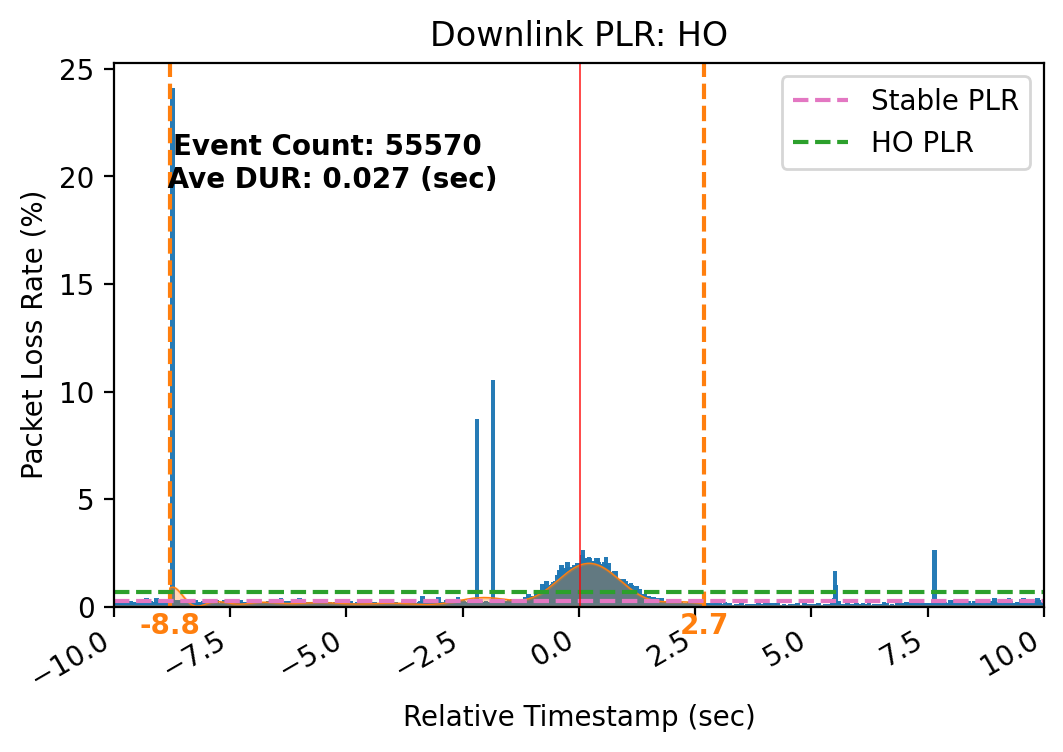

Number of Event: 55570
Average Duration: 0.02703722776678064 seconds
[(-10.0, 7.1)]
Uplink Stable PLR: 0.2526
Uplink PLR (-10.0, 7.1) 0.298


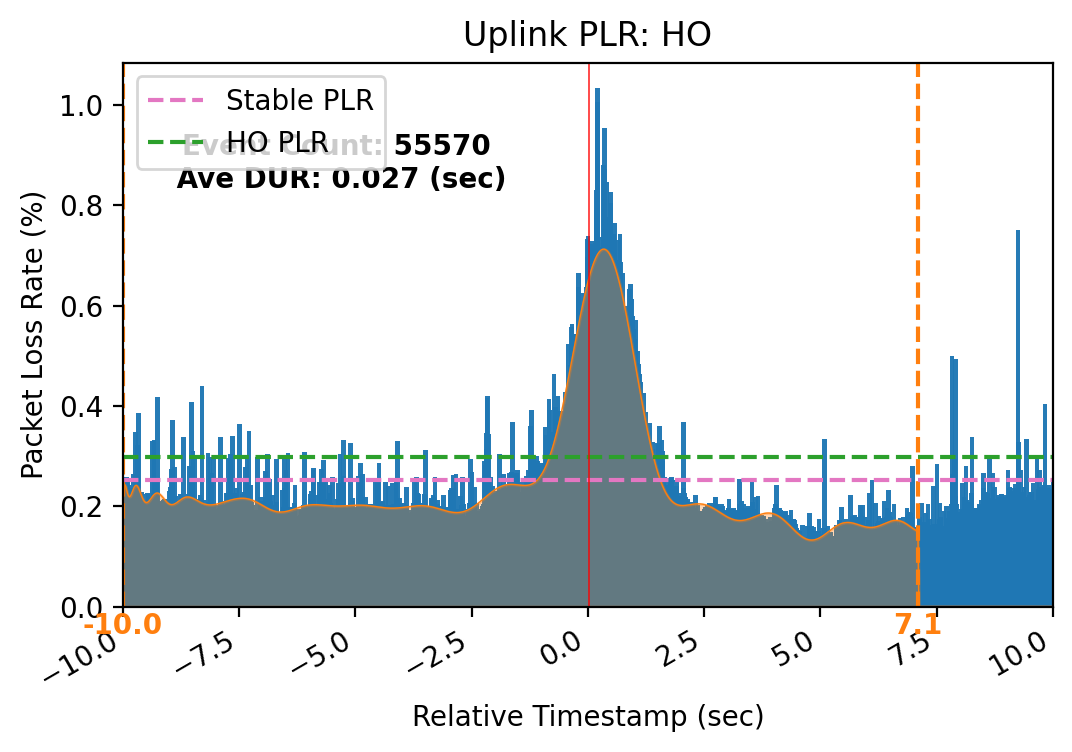

Number of Event: 55570
Average Duration: 0.02703722776678064 seconds
[(-7.8, 7.6)]
Downlink Stable ELR: 0.7898
Downlink ELR (-7.8, 7.6) 1.75


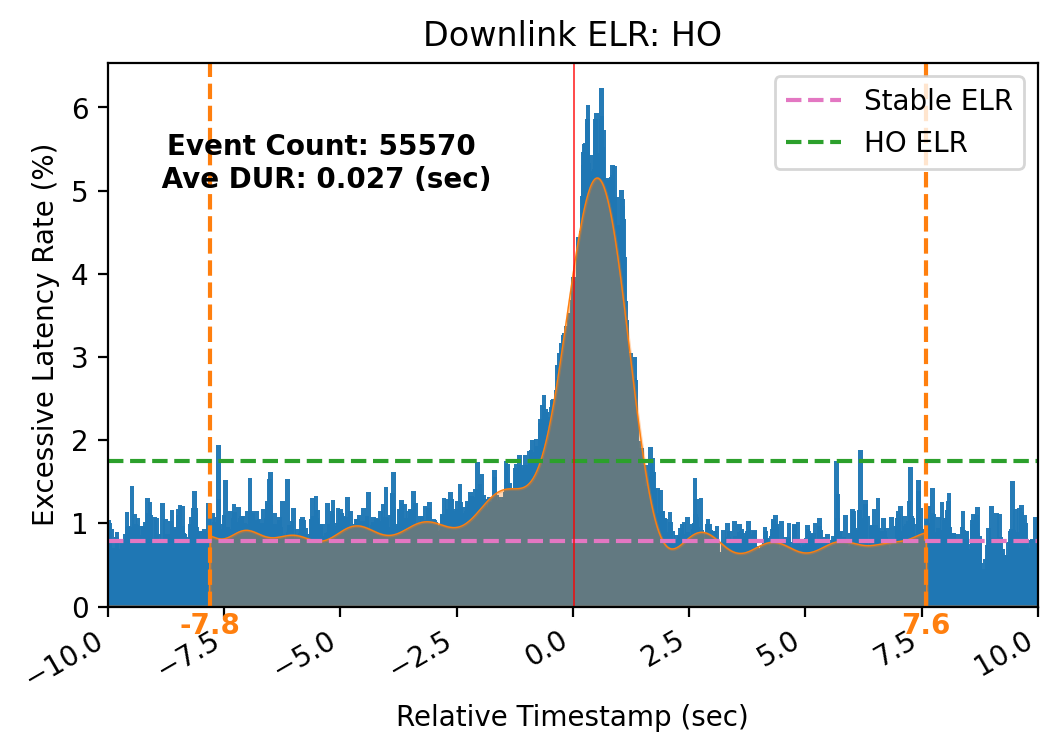

Number of Event: 55570
Average Duration: 0.02703722776678064 seconds
[(-9.8, 6.6), (-9.7, 6.7), (-9.6, 6.8), (-9.5, 6.9), (-9.4, 7.0), (-9.3, 7.1), (-9.2, 7.2), (-9.1, 7.3), (-9.0, 7.4), (-8.9, 7.5), (-8.8, 7.6), (-8.7, 7.7)]
Uplink Stable ELR: 3.6938
Uplink ELR (-9.8, 6.6) 4.856


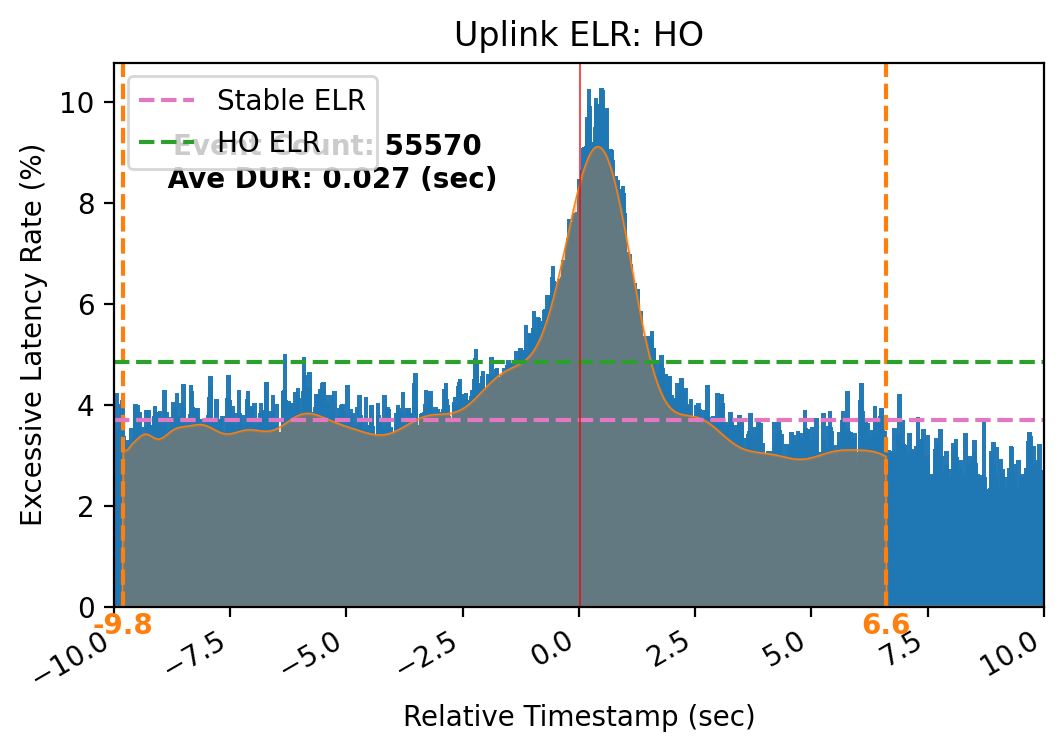

RLF
Number of Event: 4250
Average Duration: 0.08949706000000002 seconds
[(-5.9, 8.2), (-5.6, 8.5), (-5.5, 8.6)]
Downlink Stable PLR: 0.2677
Downlink PLR (-5.9, 8.2) 13.555


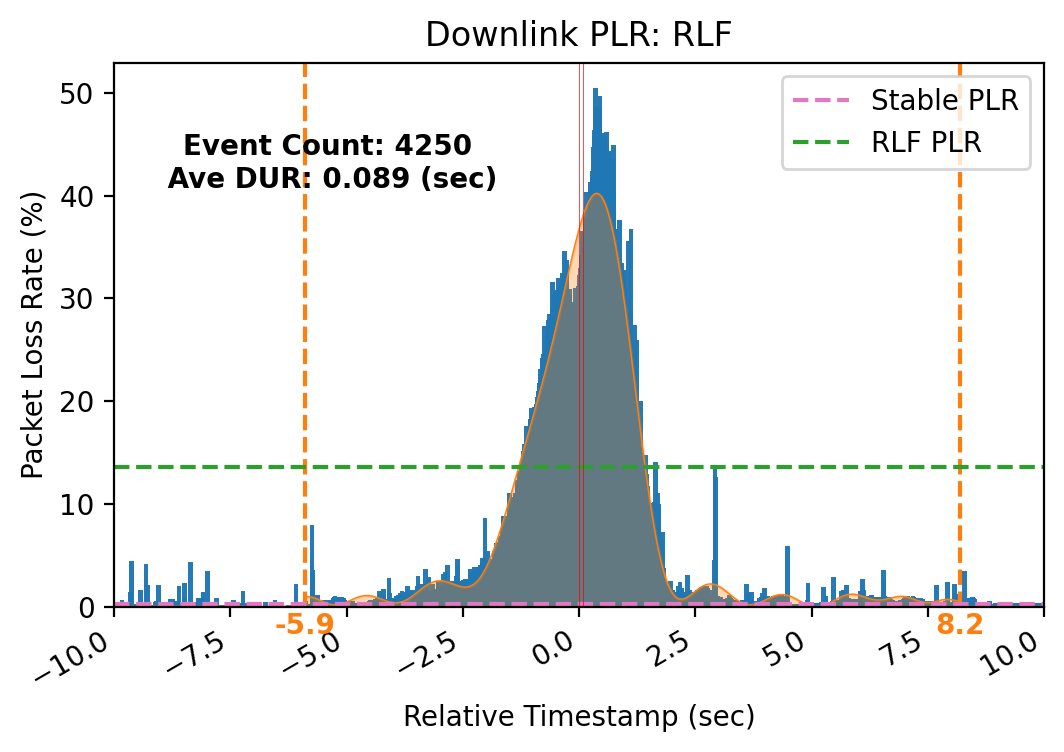

Number of Event: 4250
Average Duration: 0.08949706000000002 seconds
[(-10.0, 9.4)]
Uplink Stable PLR: 0.2526
Uplink PLR (-10.0, 9.4) 1.863


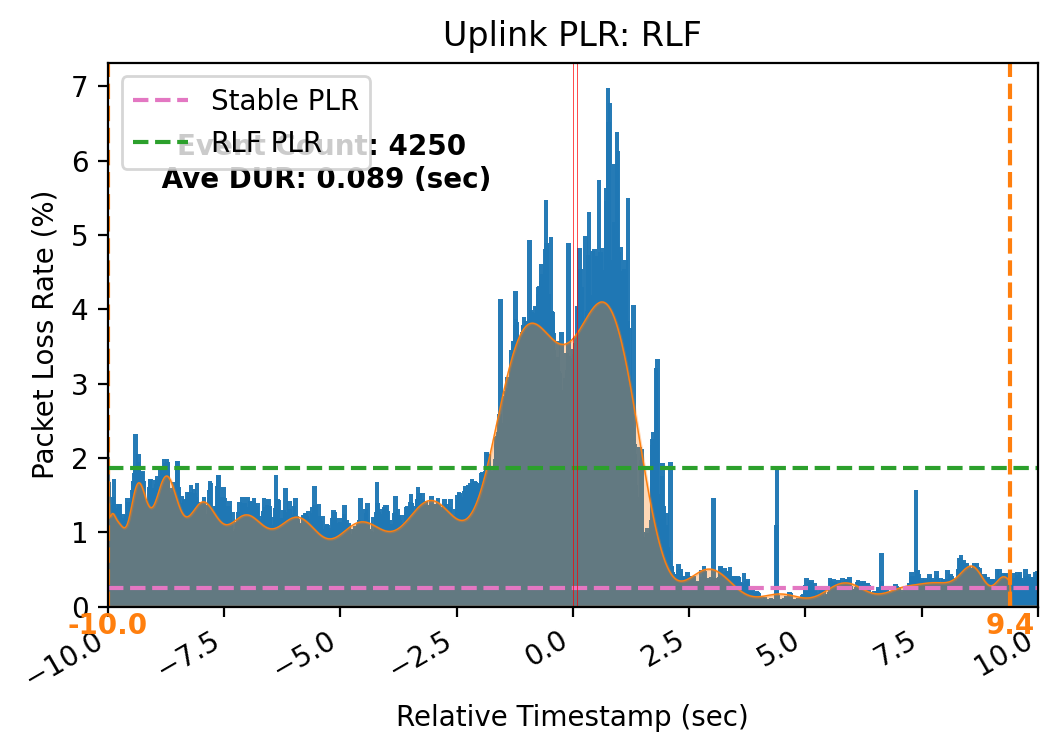

Number of Event: 4250
Average Duration: 0.08949706000000002 seconds
[(-9.9, 9.5), (-9.8, 9.6), (-9.7, 9.7), (-9.6, 9.8), (-9.5, 9.9)]
Downlink Stable ELR: 0.7898
Downlink ELR (-9.9, 9.5) 4.626


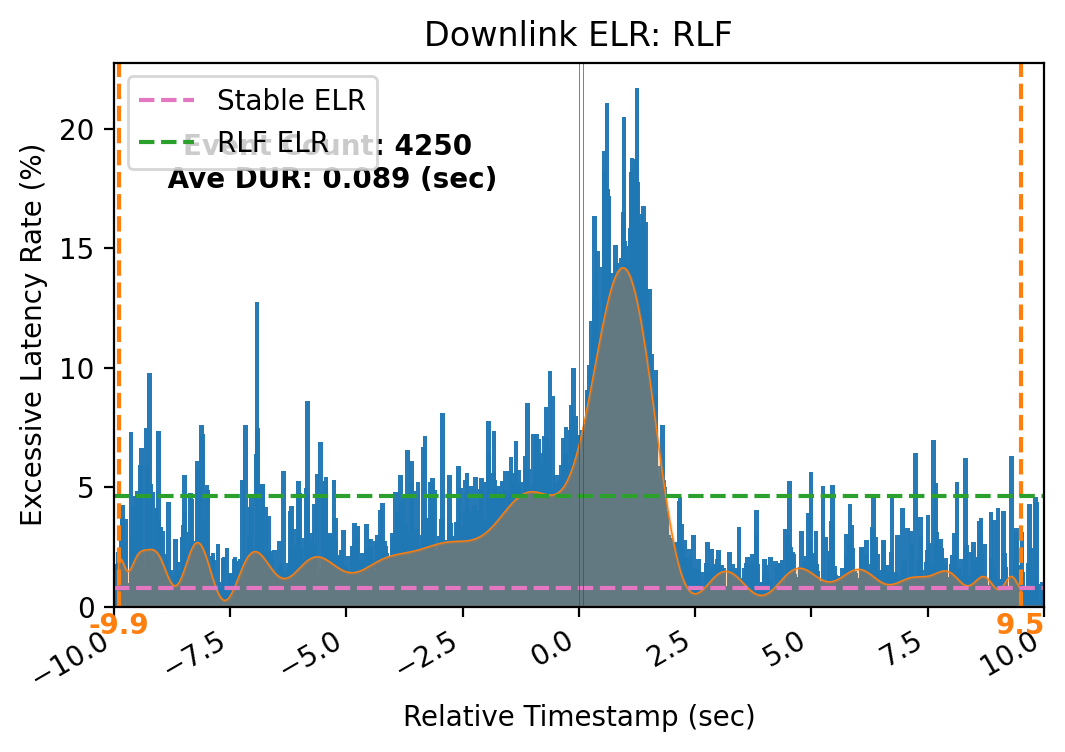

Number of Event: 4250
Average Duration: 0.08949706000000002 seconds
[(-10.0, 9.6)]
Uplink Stable ELR: 3.6938
Uplink ELR (-10.0, 9.6) 17.401


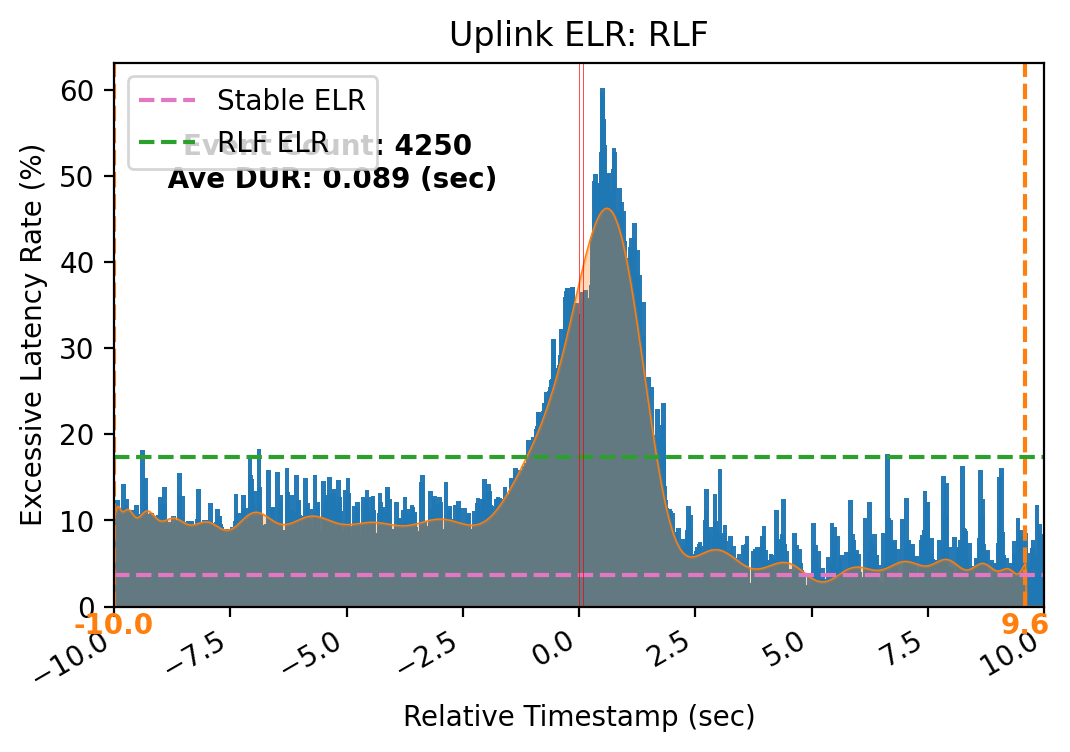

{'dl_lost': {'HO': (-8.8, 2.7), 'RLF': (-5.9, 8.2)},
 'ul_lost': {'HO': (-10.0, 7.1), 'RLF': (-10.0, 9.4)},
 'dl_excl': {'HO': (-7.8, 7.6), 'RLF': (-9.9, 9.5)},
 'ul_excl': {'HO': (-9.8, 6.6), 'RLF': (-10.0, 9.6)}}


In [112]:
# de-comment while not running the first time
D = Category_D.copy()
E = Category_E.copy()
scope = Initial_scope.copy()

# *******************************************************************************************

import warnings

def heaviside(x, left, right):
    if x < left:
        return 0
    elif x > right:
        return 0
    else:
        return 1

coef_dl_lost = pd.DataFrame(columns=['lower_bd', 'upper_bd', *list(range(71))])
coef_ul_lost = pd.DataFrame(columns=['lower_bd', 'upper_bd', *list(range(71))])
coef_dl_excl = pd.DataFrame(columns=['lower_bd', 'upper_bd', *list(range(71))])
coef_ul_excl = pd.DataFrame(columns=['lower_bd', 'upper_bd', *list(range(71))])

new_scope = { mets: {
    tag: scp for tag, scp in scope.items()
} for mets in ['dl_lost', 'ul_lost', 'dl_excl', 'ul_excl'] }

for tag in scope.keys():
    if len(D[f'dl_lost'][tag]['intrs']) == 0 or len(D[f'ul_lost'][tag]['intrs']) == 0:
            continue
    print('===========================================================================================')
    print(tag)
        
    for mets in ['lost', 'excl']:
        for mode in ['dl', 'ul']:
            if mets == 'lost':
                stable_PLR = round(sum(E[f'{mode}_lost']['stable_miss']) / (sum(E[f'{mode}_lost']['stable_pkt']) + 1e-9) * 100, 4)
            elif mets == 'excl':
                stable_ELR = round(sum(E[f'{mode}_excl']['stable_miss']) / (sum(E[f'{mode}_excl']['stable_pkt']) + 1e-9) * 100, 4)
            
            table, intr = merge_profile(D[f'{mode}_{mets}'][tag]['tables'], D[f'{mode}_{mets}'][tag]['intrs'], mets=mets)
            
            print('Number of Event:', sum(D[f'{mode}_{mets}'][tag]['count']))
            print('Average Duration:', intr, 'seconds')
            
            if mets == 'lost':
                min_scope = approx_scope(table=table.copy(), mets=mets, evt_type=tag, stable_miss_rate=stable_PLR)
            elif mets == 'excl':
                min_scope = approx_scope(table=table.copy(), mets=mets, evt_type=tag, stable_miss_rate=stable_ELR)
                
            if min_scope != 0:
                new_scope[f'{mode}_{mets}'][tag] = min_scope
            
            fig, ax = plt.subplots(figsize=(6, 4))
            
            left = scope[tag][0]
            right = scope[tag][1]
            bound = math.ceil(max(abs(right), abs(left)))
            left = -bound; right = bound
            ax.set_xlim(left, right)
            
            # width = 0.015 * (right- left)
            width = 0.005 * (right- left)
            if mets == 'lost':
                ax.bar(table['cat_id'], table['PLR'], width=width, alpha=0.97)
            elif mets == 'excl':
                ax.bar(table['cat_id'], table['ELR'], width=width, alpha=0.97)
                
            ax.set_ylim(0, max(1, ax.get_ylim()[1]))
            bottom, top = ax.get_ylim()

            if min_scope != 0:
                ax.axvline(min_scope[0], color='tab:orange', linestyle='--')
                ax.text(min_scope[0], bottom-0.05*(top-bottom), '{:.1f}'.format(min_scope[0]), ha='center', fontweight='bold', fontsize=10, color='tab:orange')
                ax.axvline(min_scope[1], color='tab:orange', linestyle='--')
                ax.text(min_scope[1], bottom-0.05*(top-bottom), '{:.1f}'.format(min_scope[1]), ha='center', fontweight='bold', fontsize=10, color='tab:orange')
                
                bleft = min_scope[0]
                bright = min_scope[1]
                
                x = np.asarray(table['cat_id'], dtype=np.float64)
                if mets == 'lost':
                    y = np.asarray(table['PLR'], dtype=np.float64)
                elif mets == 'excl':
                    y = np.asarray(table['ELR'], dtype=np.float64)
                    
                with warnings.catch_warnings():
                    warnings.simplefilter('ignore', np.RankWarning)
                    z = np.polyfit(x, y, 70)
                    p = np.poly1d(z)
                xp = np.linspace(table['cat_id'].iloc[0], table['cat_id'].iloc[-1], 1000)
                
                coef = p.coefficients
                
                if mode == 'dl':
                    if mets == 'lost':
                        coef_dl_lost.loc[tag] = [bleft, bright, *list(coef)]
                    elif mets == 'excl':
                        coef_dl_excl.loc[tag] = [bleft, bright, *list(coef)]
                elif mode == 'ul':
                    if mets == 'lost':
                        coef_ul_lost.loc[tag] = [bleft, bright, *list(coef)]
                    elif mets == 'excl':
                        coef_ul_excl.loc[tag] = [bleft, bright, *list(coef)]
                
                ax.plot(xp, np.clip(p(xp)*np.vectorize(heaviside)(xp, bleft, bright), a_min=0, a_max=100), '-', c='tab:orange', lw=0.5)
                ax.fill_between(xp, np.clip(p(xp)*np.vectorize(heaviside)(xp, bleft, bright), a_min=0, a_max=100), color='tab:orange', alpha=0.3)
            
            if mets == 'lost':
                ax.axhline(stable_PLR, color='tab:pink', linestyle='--', label='Stable PLR')
                # ax.text(1.078*right, stable_PLR, '{:.4f}'.format(stable_PLR), ha='center', fontweight='bold', fontsize=10, color='tab:pink')
                if min_scope != 0:
                    _table = table[(table['cat_id'] >= min_scope[0]) & (table['cat_id'] < min_scope[1])].copy()
                    PLR = round(sum(_table['lost']) / (sum(_table['tx_count']) + 1e-9) * 100, 3)
                    if mode == 'dl':
                        print('Downlink Stable PLR:', stable_PLR)
                        print('Downlink PLR', min_scope, PLR)
                    elif mode == 'ul':
                        print('Uplink Stable PLR:', stable_PLR)
                        print('Uplink PLR', min_scope, PLR)
                    ax.axhline(PLR, color='tab:green', linestyle='--', label=f'{tag} PLR')
                    # ax.text(1.078*left, PLR, '{:.3f}'.format(PLR), ha='center', fontweight='bold', fontsize=10, color='tab:green')
            elif mets == 'excl':
                ax.axhline(stable_ELR, color='tab:pink', linestyle='--', label='Stable ELR')
                # ax.text(1.078*right, stable_ELR, '{:.4f}'.format(stable_ELR), ha='center', fontweight='bold', fontsize=10, color='tab:pink')
                if min_scope != 0:
                    _table = table[(table['cat_id'] >= min_scope[0]) & (table['cat_id'] < min_scope[1])].copy()
                    ELR = round(sum(_table['excl']) / (sum(_table['tx_count']) + 1e-9) * 100, 3)
                    if mode == 'dl':
                        print('Downlink Stable ELR:', stable_ELR)
                        print('Downlink ELR', min_scope, ELR)
                    elif mode == 'ul':
                        print('Uplink Stable ELR:', stable_ELR)
                        print('Uplink ELR', min_scope, ELR)
                    ax.axhline(ELR, color='tab:green', linestyle='--', label=f'{tag} ELR')
                    # ax.text(1.078*left, ELR, '{:.3f}'.format(ELR), ha='center', fontweight='bold', fontsize=10, color='tab:green')
            
            count = sum(D[f'{mode}_{mets}'][tag]['count'])
            intr = round(intr, 3)
            ax.axvline(0, color='red', alpha=1, linestyle='-', linewidth=0.25)
            ax.axvline(intr, color='red', alpha=1, linestyle='-', linewidth=0.25)
            ax.text(left+0.23*(right-left), bottom+0.77*(top-bottom), f'Event Count: {count}\n Ave DUR: {intr} (sec)', ha='center', fontweight='bold', fontsize=10)
            
            if mode == 'dl':
                if mets == 'lost':
                    ax.set_title(f'Downlink PLR: {tag}')
                elif mets == 'excl':
                    ax.set_title(f'Downlink ELR: {tag}')
            elif mode == 'ul':
                if mets == 'lost':
                    ax.set_title(f'Uplink PLR: {tag}')
                elif mets == 'excl':
                    ax.set_title(f'Uplink ELR: {tag}')
            
            if mets == 'lost':
                ax.set_ylabel('Packet Loss Rate (%)')
            elif mets == 'excl':
                ax.set_ylabel('Excessive Latency Rate (%)')
            ax.set_xlabel('Relative Timestamp (sec)')
            ax.legend()
            
            plt.gcf().autofmt_xdate()
            plt.show()

pprint(new_scope, sort_dicts=False)

# Category_D = D.copy()
# Category_E = E.copy()
Category_scope = new_scope.copy()

In [130]:
Category_scope = {
    'dl_lost': {'HO': (-5.0, 5.0), 'RLF': (-9.0, 9.0)},
    'ul_lost': {'HO': (-5.0, 5.0), 'RLF': (-9.0, 9.0)},
    'dl_excl': {'HO': (-5.0, 5.0), 'RLF': (-9.0, 9.0)},
    'ul_excl': {'HO': (-5.0, 5.0), 'RLF': (-9.0, 9.0)}
}

## Step 2: type

In [131]:
columns = ['stage', 'category', 'crossover', 'type', 'cause', 'index', 'inter-eNB', 'inter-Freq', 'band_cng']
sp_col = 'type'
lookup = {
    'LTEH': 'HO',
    'ENBH': 'HO',
    'MCGH': 'HO',
    'MNBH': 'HO',
    'SCGM': 'HO',
    'SCGA': 'HO',
    'SCGR-I': 'HO',
    'SCGR-II': 'HO',
    'SCGC-I': 'HO',
    'SCGC-II': 'HO',
    'MCGF': 'RLF',
    'NASR': 'RLF',
    'SCGF': 'RLF',
}

scope = { mets: {
    tag: Category_scope[mets][category] for tag, category in lookup.items()
} for mets in ['dl_lost', 'ul_lost', 'dl_excl', 'ul_excl'] }

pprint(scope, sort_dicts=False)

{'dl_lost': {'LTEH': (-5.0, 5.0),
             'ENBH': (-5.0, 5.0),
             'MCGH': (-5.0, 5.0),
             'MNBH': (-5.0, 5.0),
             'SCGM': (-5.0, 5.0),
             'SCGA': (-5.0, 5.0),
             'SCGR-I': (-5.0, 5.0),
             'SCGR-II': (-5.0, 5.0),
             'SCGC-I': (-5.0, 5.0),
             'SCGC-II': (-5.0, 5.0),
             'MCGF': (-9.0, 9.0),
             'NASR': (-9.0, 9.0),
             'SCGF': (-9.0, 9.0)},
 'ul_lost': {'LTEH': (-5.0, 5.0),
             'ENBH': (-5.0, 5.0),
             'MCGH': (-5.0, 5.0),
             'MNBH': (-5.0, 5.0),
             'SCGM': (-5.0, 5.0),
             'SCGA': (-5.0, 5.0),
             'SCGR-I': (-5.0, 5.0),
             'SCGR-II': (-5.0, 5.0),
             'SCGC-I': (-5.0, 5.0),
             'SCGC-II': (-5.0, 5.0),
             'MCGF': (-9.0, 9.0),
             'NASR': (-9.0, 9.0),
             'SCGF': (-9.0, 9.0)},
 'dl_excl': {'LTEH': (-5.0, 5.0),
             'ENBH': (-5.0, 5.0),
             'MCGH': (-5.0

In [132]:
D = {mm: {tag: {'tables': [], 'intrs': [], 'count': []} for tag in scope[mm].keys()} for mm in ['dl_lost', 'dl_excl', 'ul_lost', 'ul_excl']}
E = {mm: {'stable_miss': [], 'stable_pkt': [], 'stable_duration': [], 'total_duration': []} for mm in ['dl_lost', 'dl_excl', 'ul_lost', 'ul_excl']}

N = len(filepaths)
for i, (ho_filepath, dl_filepath, ul_filepath) in enumerate(filepaths):
    print(f'{i}/{N}', ho_filepath); print(f'{i}/{N}', dl_filepath); print(f'{i}/{N}', ul_filepath)
    df_ho = pd.read_csv(ho_filepath, parse_dates=['start', 'end'])
    df_dl = set_data(pd.read_csv(dl_filepath))
    df_ul = set_data(pd.read_csv(ul_filepath))
    
    for mode, df in zip(['dl', 'ul'], [df_dl, df_ul]):
        for mets in ['lost', 'excl']:
            A, stable_miss, stable_pkt, stable_miss_rate, stable_duration, total_duration, stable_proportion  = \
                setup_profile_one_trace(df=df, df_ho=df_ho, mode=mode, mets=mets, sp_col=sp_col, scope=scope[f'{mode}_{mets}'])
            
            # Merge instances for each event's profile in a trace
            for tag in scope[f'{mode}_{mets}'].keys():
                if len(A[tag]['tables']) == 0:
                    continue
                table, intr = merge_profile(A[tag]['tables'], A[tag]['intrs'], mets=mets)
                D[f'{mode}_{mets}'][tag]['tables'].append(table)
                D[f'{mode}_{mets}'][tag]['intrs'] = [*D[f'{mode}_{mets}'][tag]['intrs'], *A[tag]['intrs']]
                D[f'{mode}_{mets}'][tag]['count'].append(len(A[tag]['tables']))
                
                E[f'{mode}_{mets}']['stable_miss'].append(stable_miss)
                E[f'{mode}_{mets}']['stable_pkt'].append(stable_pkt)
                E[f'{mode}_{mets}']['stable_duration'].append(stable_duration)
                E[f'{mode}_{mets}']['total_duration'].append(total_duration)
    # if i > 5:     
    #     break

HOType_D = D.copy()
HOType_E = E.copy()

0/968 /Users/jackbedford/Desktop/MOXA/Code/data/2023-03-16/UDP_Bandlock_B1_B7_B8_RM500Q/qc00/#01/data/handover_info_log.csv
0/968 /Users/jackbedford/Desktop/MOXA/Code/data/2023-03-16/UDP_Bandlock_B1_B7_B8_RM500Q/qc00/#01/data/udp_dnlk_loss_latency.csv
0/968 /Users/jackbedford/Desktop/MOXA/Code/data/2023-03-16/UDP_Bandlock_B1_B7_B8_RM500Q/qc00/#01/data/udp_uplk_loss_latency.csv
1/968 /Users/jackbedford/Desktop/MOXA/Code/data/2023-03-16/UDP_Bandlock_B1_B7_B8_RM500Q/qc02/#01/data/handover_info_log.csv
1/968 /Users/jackbedford/Desktop/MOXA/Code/data/2023-03-16/UDP_Bandlock_B1_B7_B8_RM500Q/qc02/#01/data/udp_dnlk_loss_latency.csv
1/968 /Users/jackbedford/Desktop/MOXA/Code/data/2023-03-16/UDP_Bandlock_B1_B7_B8_RM500Q/qc02/#01/data/udp_uplk_loss_latency.csv
2/968 /Users/jackbedford/Desktop/MOXA/Code/data/2023-03-16/UDP_Bandlock_B1_B7_B8_RM500Q/qc03/#01/data/handover_info_log.csv
2/968 /Users/jackbedford/Desktop/MOXA/Code/data/2023-03-16/UDP_Bandlock_B1_B7_B8_RM500Q/qc03/#01/data/udp_dnlk_loss_

### Plot

In [133]:
HOType_scope = {
    'dl_lost': {
        'LTEH': (-4.0, 2.0),
        'ENBH': (-4.0, 2.5),
        'MCGH': (-3.0, 3.0),
        'MNBH': (-3.0, 3.0),
        'SCGM': (-3.0, 3.0),
        'SCGA': (-3.0, 2.5),
        'SCGR-I': (-3.5, 3.0),
        'SCGR-II': (-2.0, 3.0),
        'SCGC-I': (-3.0, 3.0),
        'SCGC-II': (-2.0, 2.0),
        'MCGF': (-5.0, 7.5),
        'NASR': (-4.0, 7.0),
        'SCGF': (-4.0, 5.0)
    },
    'ul_lost': {
        'LTEH': (-4.0, 2.0),
        'ENBH': (-4.0, 2.5),
        'MCGH': (-3.0, 3.0),
        'MNBH': (-3.0, 3.0),
        'SCGM': (-3.0, 3.0),
        'SCGA': (-3.0, 2.5),
        'SCGR-I': (-3.5, 3.0),
        'SCGR-II': (-2.0, 3.0),
        'SCGC-I': (-3.0, 3.0),
        'SCGC-II': (-2.0, 2.0),
        'MCGF': (-5.0, 7.5),
        'NASR': (-4.0, 7.0),
        'SCGF': (-4.0, 5.0)
    },
    'dl_excl': {
        'LTEH': (-4.0, 2.0),
        'ENBH': (-4.0, 2.5),
        'MCGH': (-3.0, 3.0),
        'MNBH': (-3.0, 3.0),
        'SCGM': (-3.0, 3.0),
        'SCGA': (-3.0, 2.5),
        'SCGR-I': (-3.5, 3.0),
        'SCGR-II': (-2.0, 3.0),
        'SCGC-I': (-3.0, 3.0),
        'SCGC-II': (-2.0, 2.0),
        'MCGF': (-5.0, 7.5),
        'NASR': (-4.0, 7.0),
        'SCGF': (-4.0, 5.0)
    },
    'ul_excl': {
        'LTEH': (-4.0, 2.0),
        'ENBH': (-4.0, 2.5),
        'MCGH': (-3.0, 3.0),
        'MNBH': (-3.0, 3.0),
        'SCGM': (-3.0, 3.0),
        'SCGA': (-3.0, 2.5),
        'SCGR-I': (-3.5, 3.0),
        'SCGR-II': (-2.0, 3.0),
        'SCGC-I': (-3.0, 3.0),
        'SCGC-II': (-2.0, 2.0),
        'MCGF': (-5.0, 7.5),
        'NASR': (-4.0, 7.0),
        'SCGF': (-4.0, 5.0)
    }
}

LTEH
Number of Event: 4301
Average Duration: 0.01910932550569635 seconds
[(-4.6, 2.9), (-4.0, 3.5), (-3.9, 3.6), (-3.8, 3.7), (-3.7, 3.8), (-3.6, 3.9), (-3.5, 4.0), (-3.4, 4.1)]
Downlink Stable PLR: 0.2494
Downlink PLR (-4.0, 2.0) 0.352


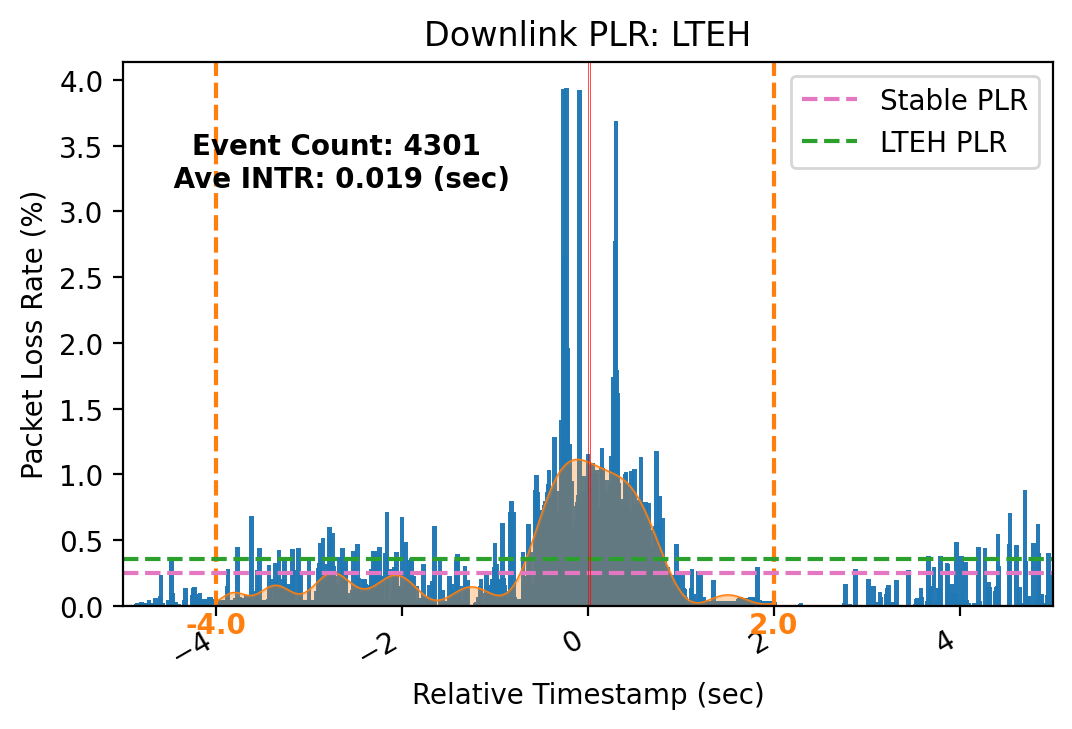

Number of Event: 4301
Average Duration: 0.01910932550569635 seconds
[(-2.2, 3.6)]
Uplink Stable PLR: 0.2428
Uplink PLR (-4.0, 2.0) 0.216


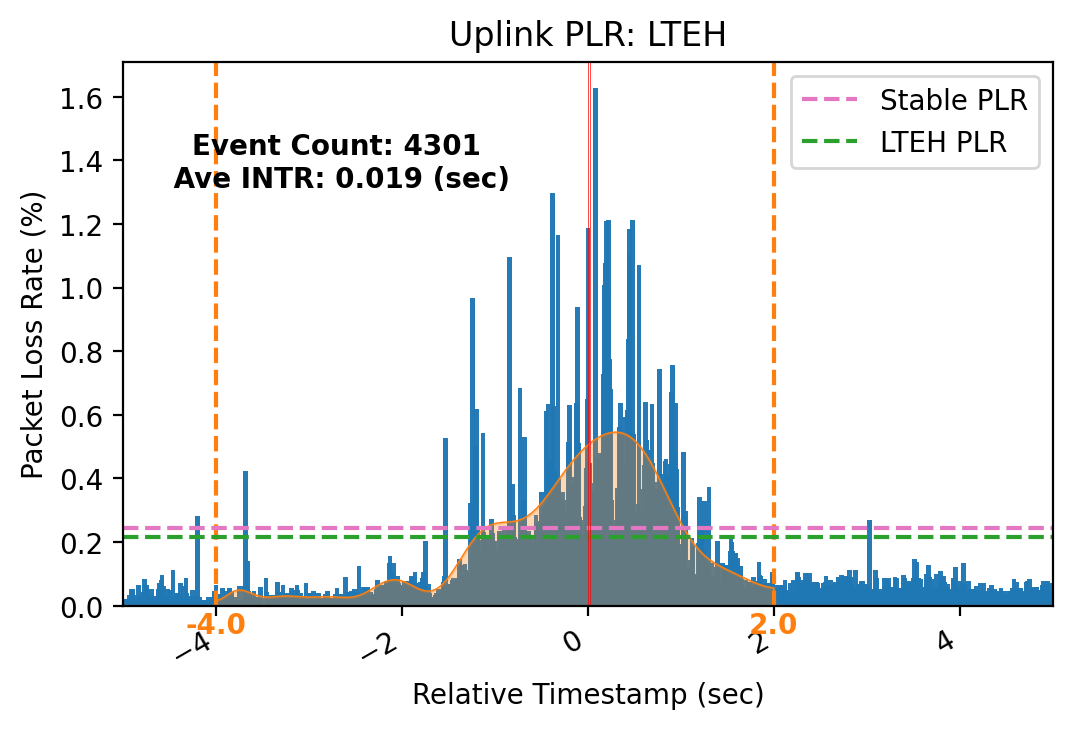

Number of Event: 4301
Average Duration: 0.01910932550569635 seconds
[(-5.0, 3.7), (-4.9, 3.8)]
Downlink Stable ELR: 0.8031
Downlink ELR (-4.0, 2.0) 2.446


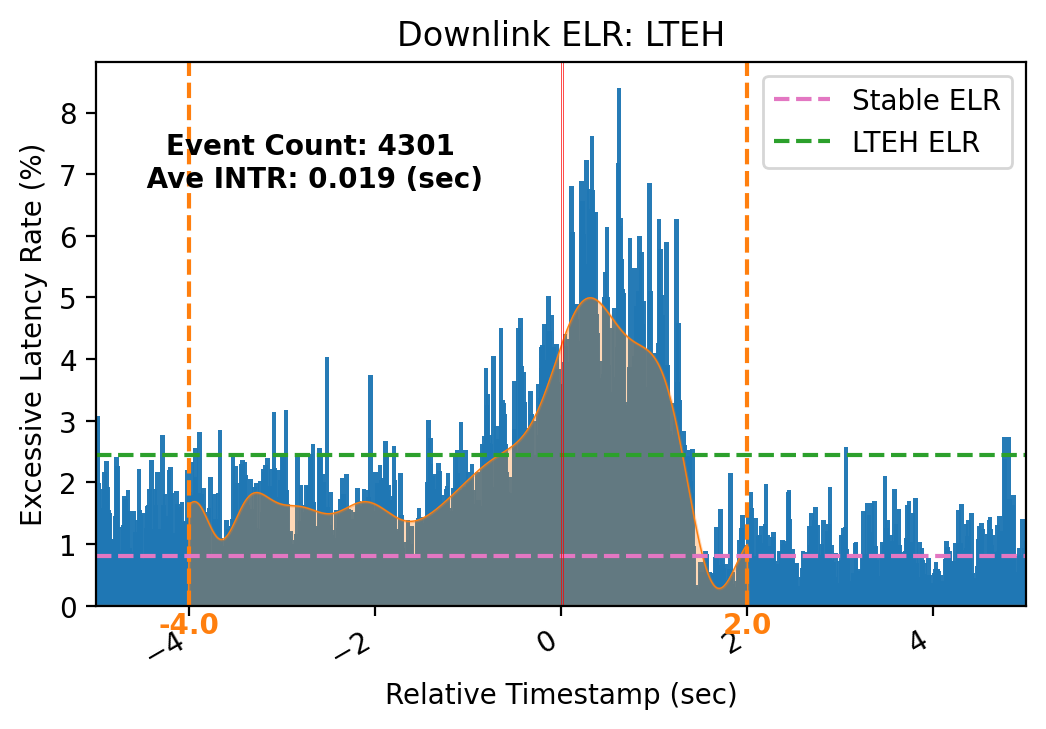

Number of Event: 4301
Average Duration: 0.01910932550569635 seconds
[(-4.2, 4.6)]
Uplink Stable ELR: 3.9737
Uplink ELR (-4.0, 2.0) 5.031


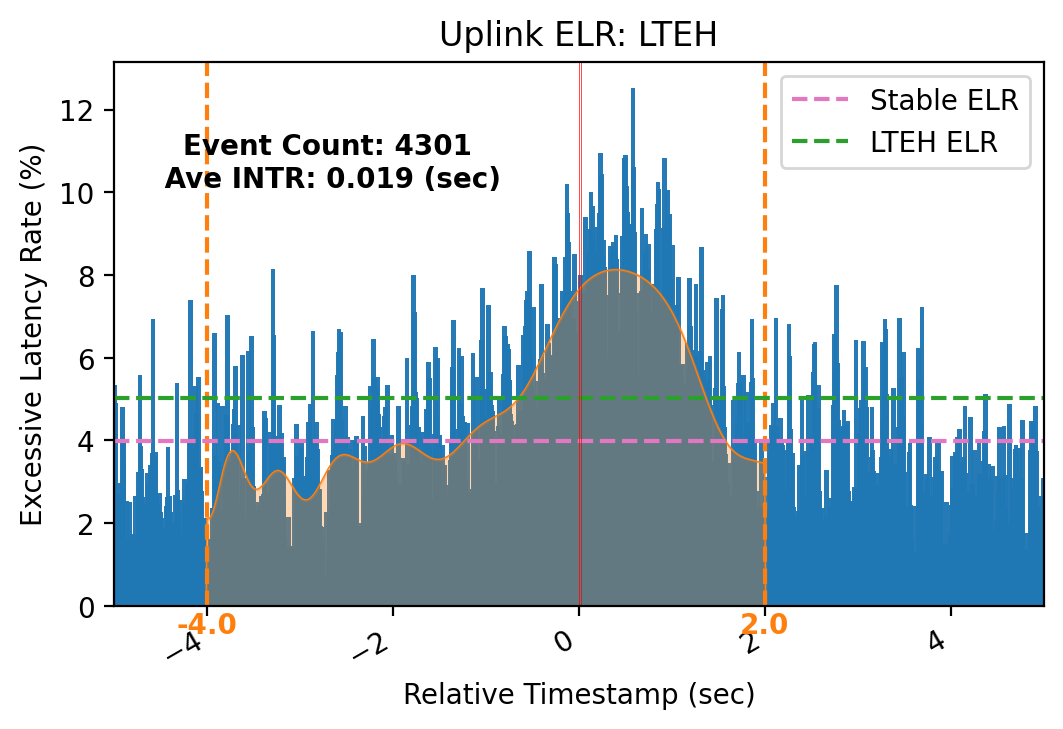

ENBH
Number of Event: 9376
Average Duration: 0.019240689633105802 seconds
[(-4.6, 1.3)]
Downlink Stable PLR: 0.2494
Downlink PLR (-4.0, 2.5) 0.482


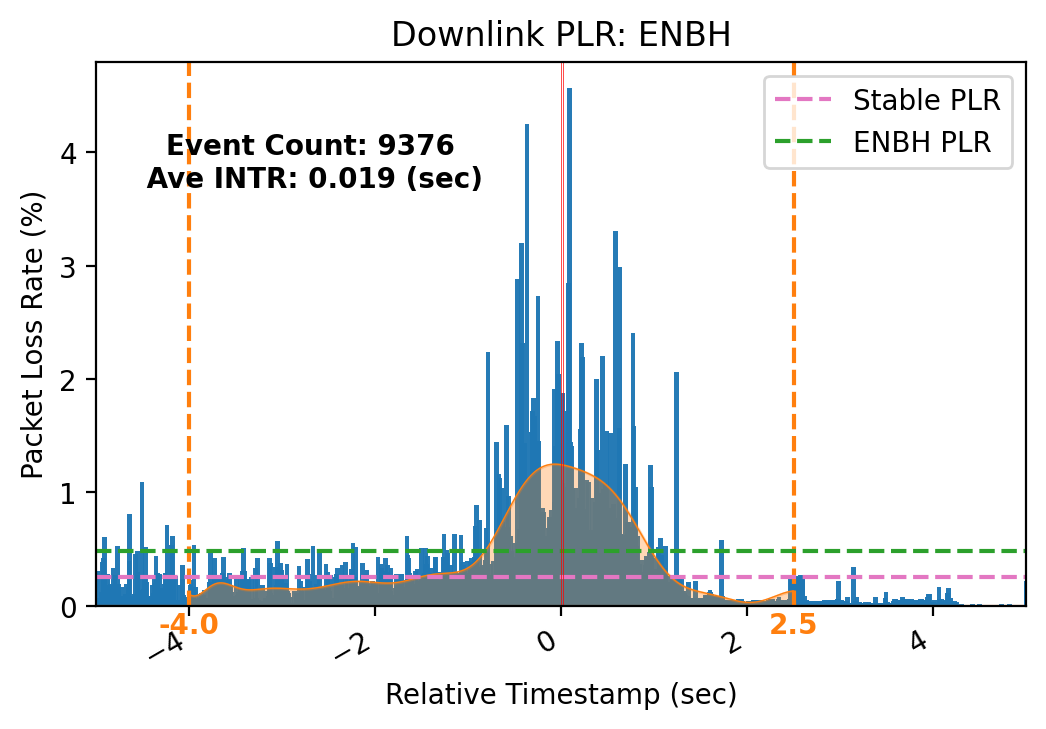

Number of Event: 9376
Average Duration: 0.019240689633105802 seconds
[(-4.7, 3.4), (-4.6, 3.5), (-4.5, 3.6)]
Uplink Stable PLR: 0.2428
Uplink PLR (-4.0, 2.5) 0.188


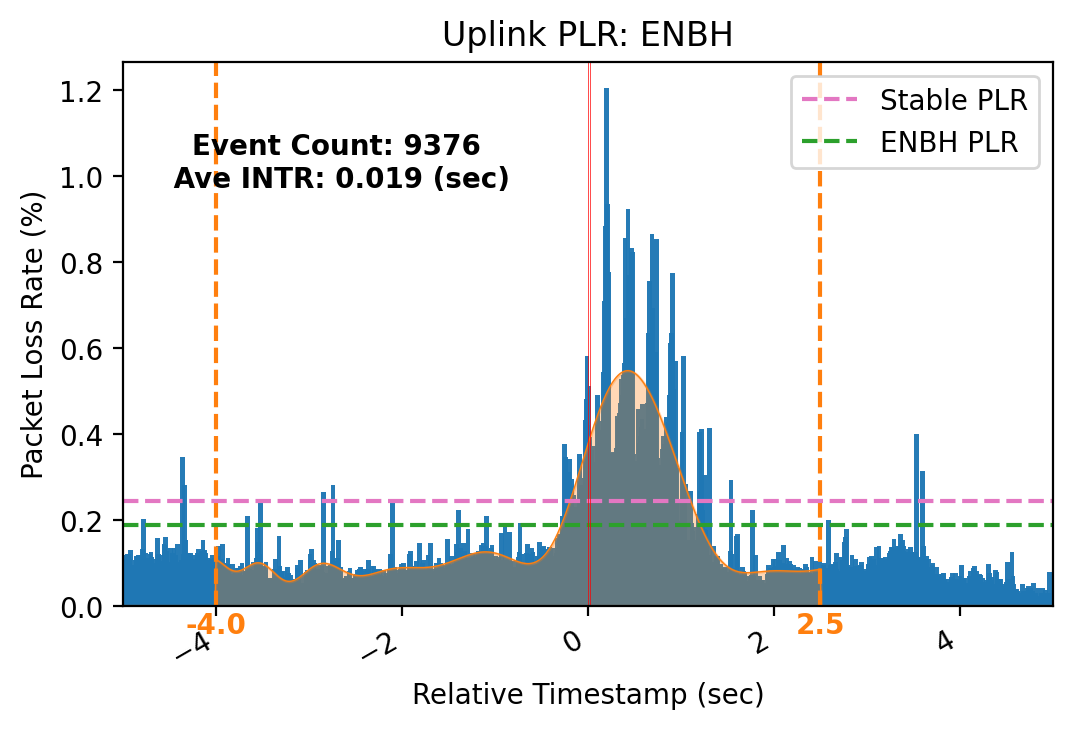

Number of Event: 9376
Average Duration: 0.019240689633105802 seconds
[(-5.0, 3.4), (-4.9, 3.5)]
Downlink Stable ELR: 0.8031
Downlink ELR (-4.0, 2.5) 3.919


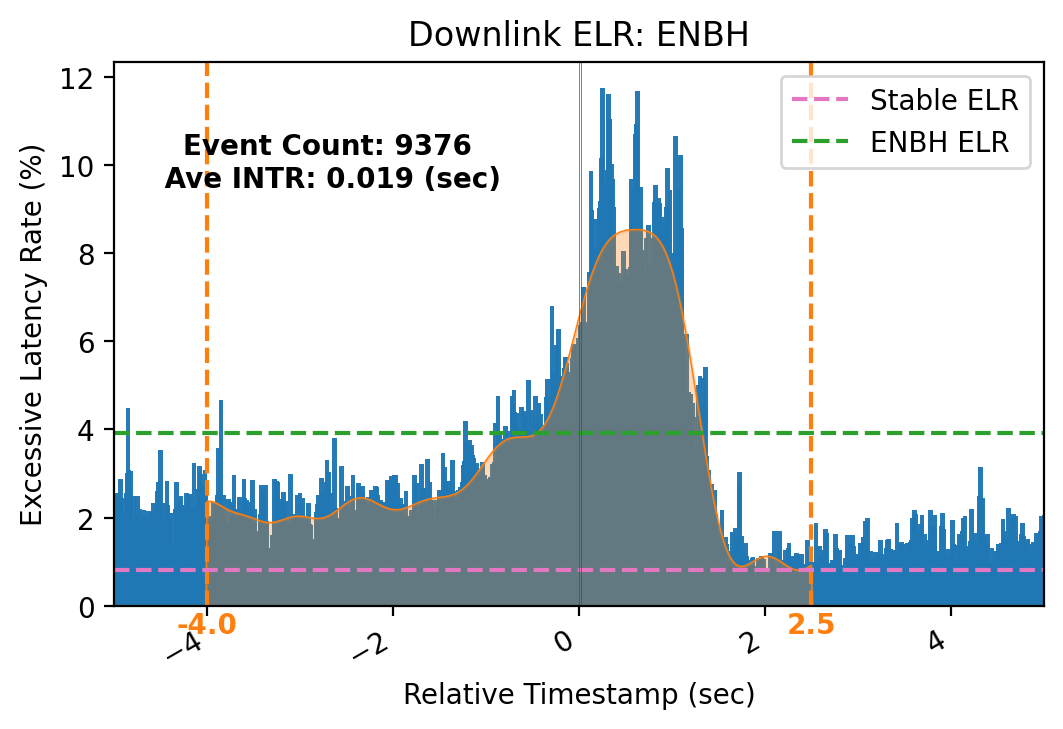

Number of Event: 9376
Average Duration: 0.019240689633105802 seconds
[(-5.0, 3.8), (-4.9, 3.9), (-4.8, 4.0), (-4.7, 4.1), (-4.6, 4.2), (-4.5, 4.3), (-4.4, 4.4), (-4.3, 4.5)]
Uplink Stable ELR: 3.9737
Uplink ELR (-4.0, 2.5) 7.159


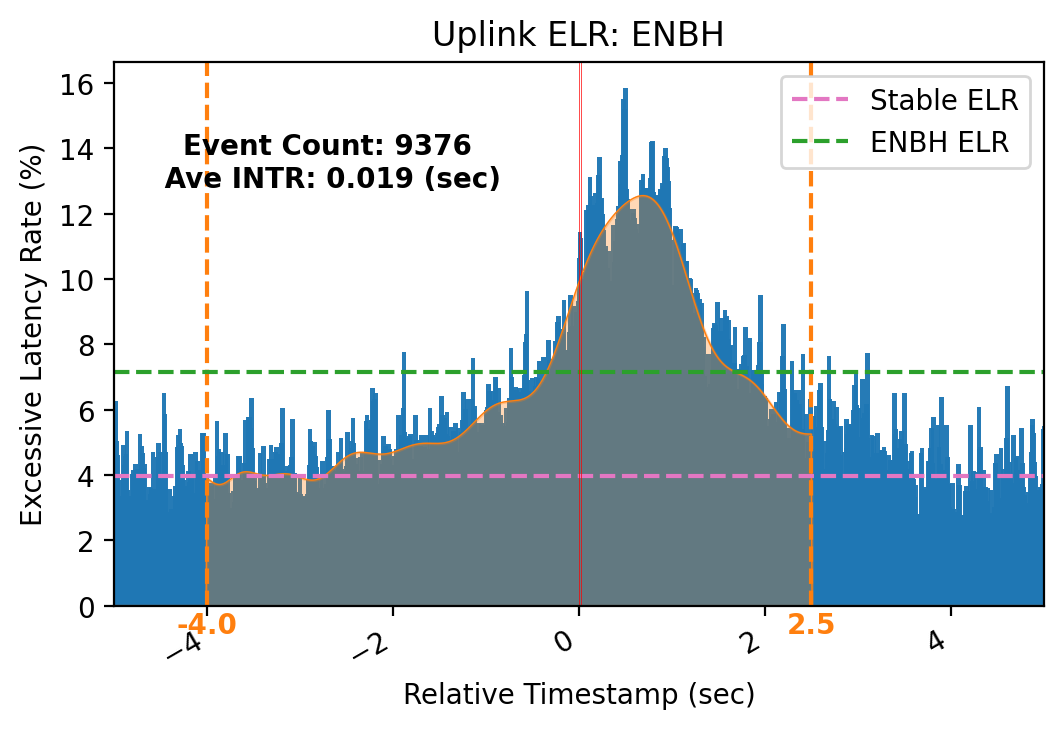

MCGH
Number of Event: 4553
Average Duration: 0.018975998023281353 seconds
[(-1.2, 1.5)]
Downlink Stable PLR: 0.2494
Downlink PLR (-3.0, 3.0) 0.899


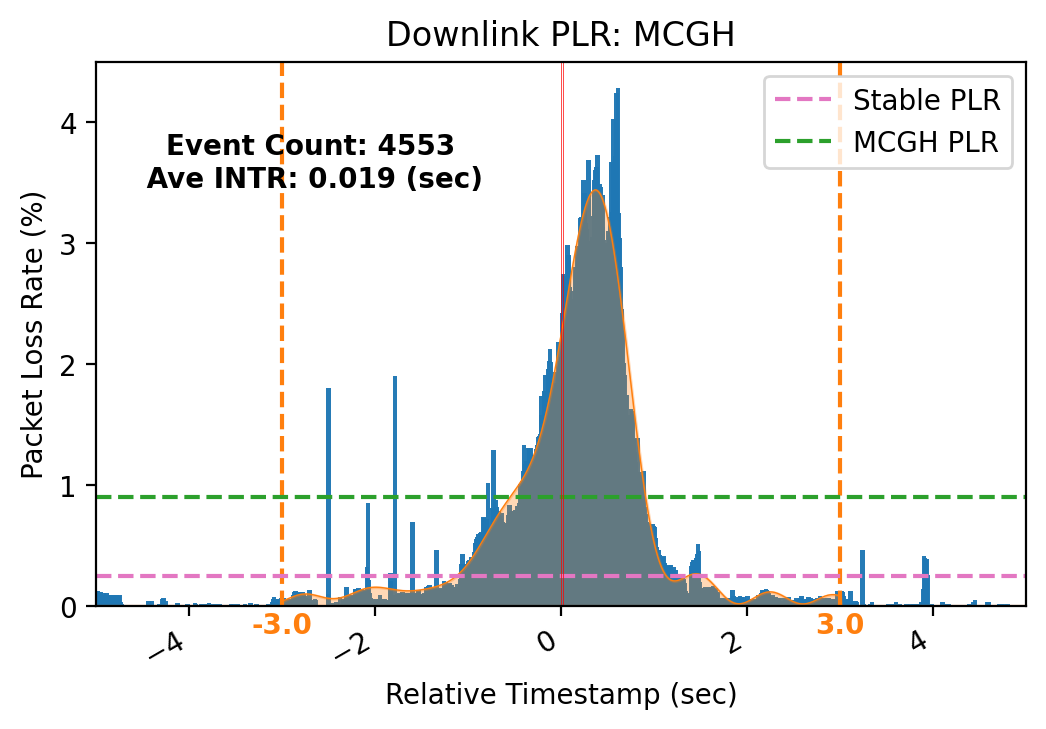

Number of Event: 4553
Average Duration: 0.018975998023281353 seconds
[(-3.0, 4.3)]
Uplink Stable PLR: 0.2428
Uplink PLR (-3.0, 3.0) 0.356


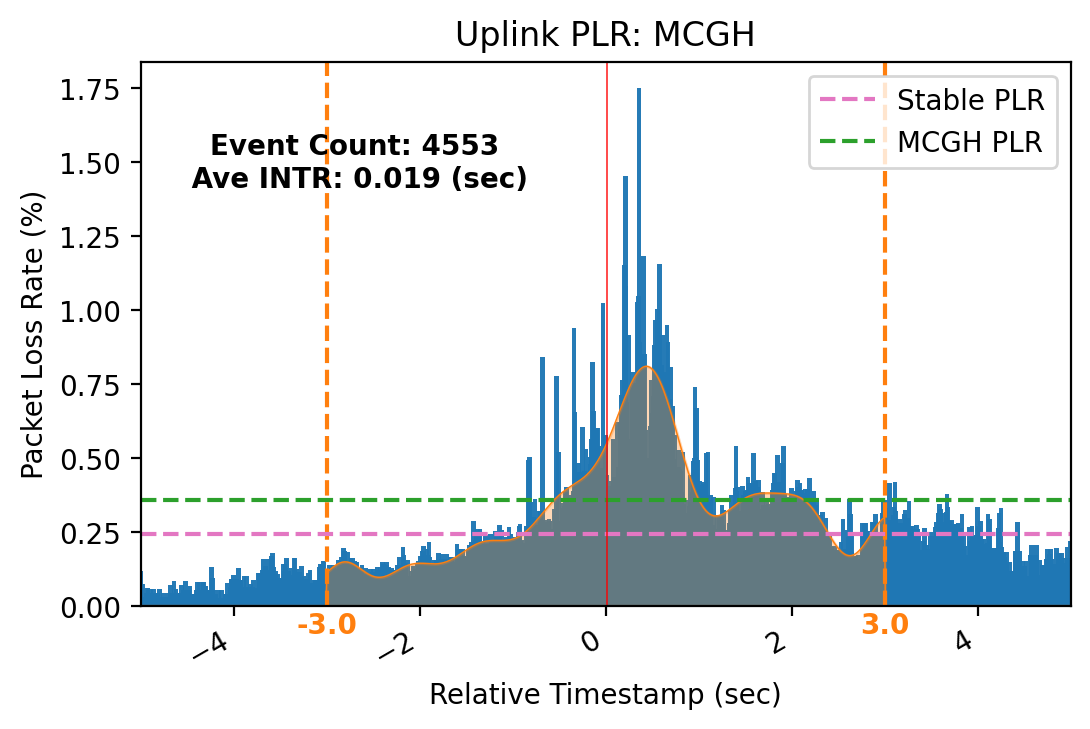

Number of Event: 4553
Average Duration: 0.018975998023281353 seconds
[(-3.0, 3.0), (-2.8, 3.2)]
Downlink Stable ELR: 0.8031
Downlink ELR (-3.0, 3.0) 0.894


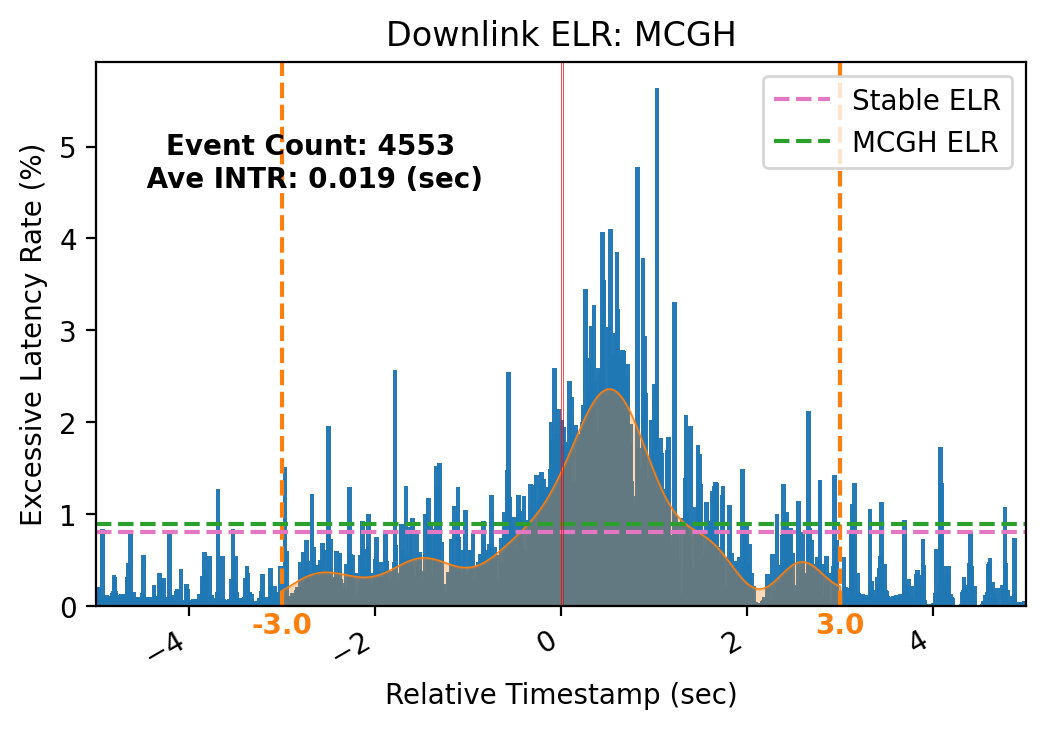

Number of Event: 4553
Average Duration: 0.018975998023281353 seconds
[(-4.6, 3.3)]
Uplink Stable ELR: 3.9737
Uplink ELR (-3.0, 3.0) 2.444


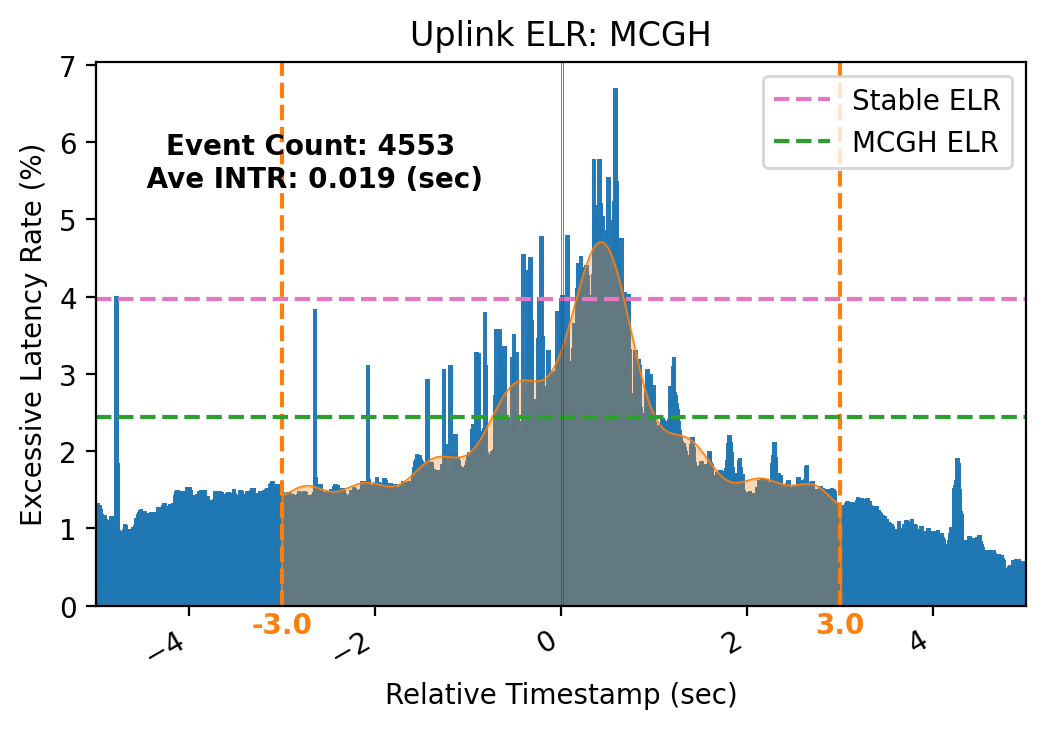

MNBH
Number of Event: 14267
Average Duration: 0.020236961379407024 seconds
[(-1.8, 2.1)]
Downlink Stable PLR: 0.2494
Downlink PLR (-3.0, 3.0) 1.289


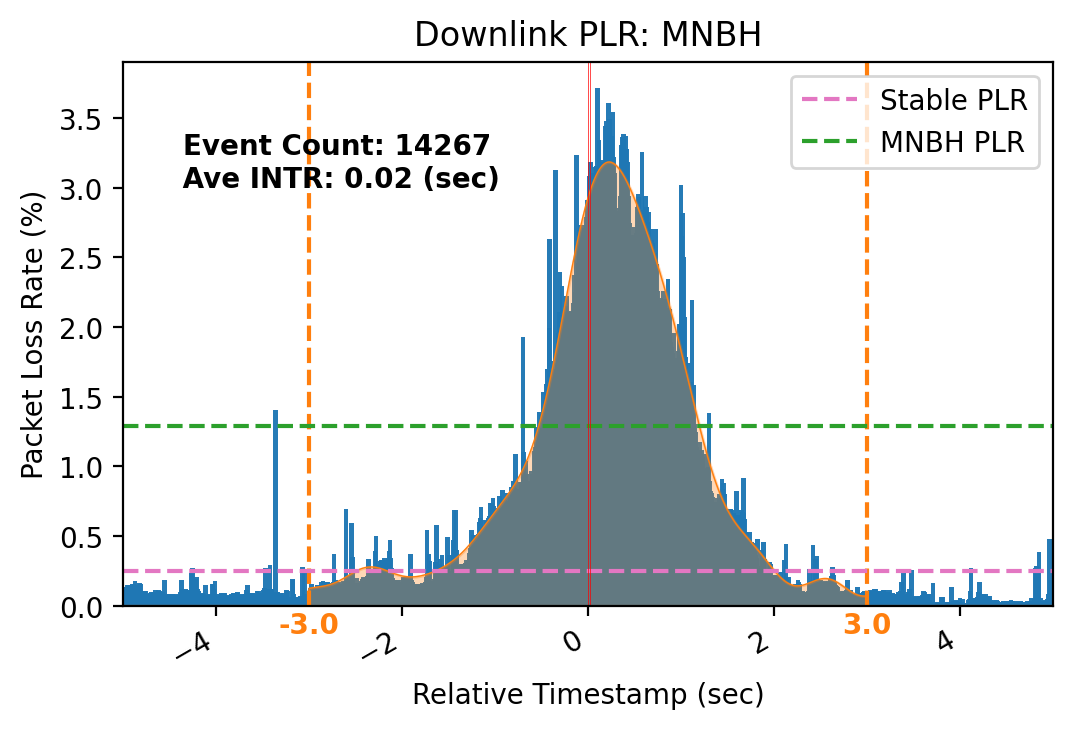

Number of Event: 14267
Average Duration: 0.020236961379407024 seconds
[(-4.1, 3.3)]
Uplink Stable PLR: 0.2428
Uplink PLR (-3.0, 3.0) 0.349


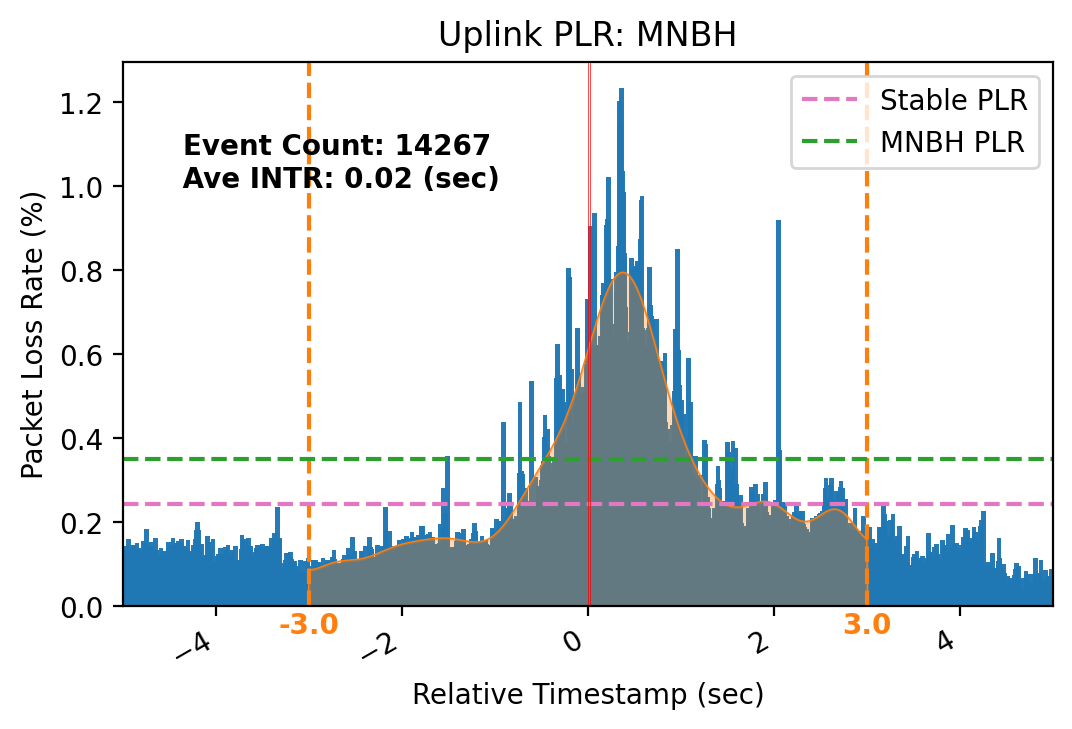

Number of Event: 14267
Average Duration: 0.020236961379407024 seconds
[(-3.5, 3.2)]
Downlink Stable ELR: 0.8031
Downlink ELR (-3.0, 3.0) 1.328


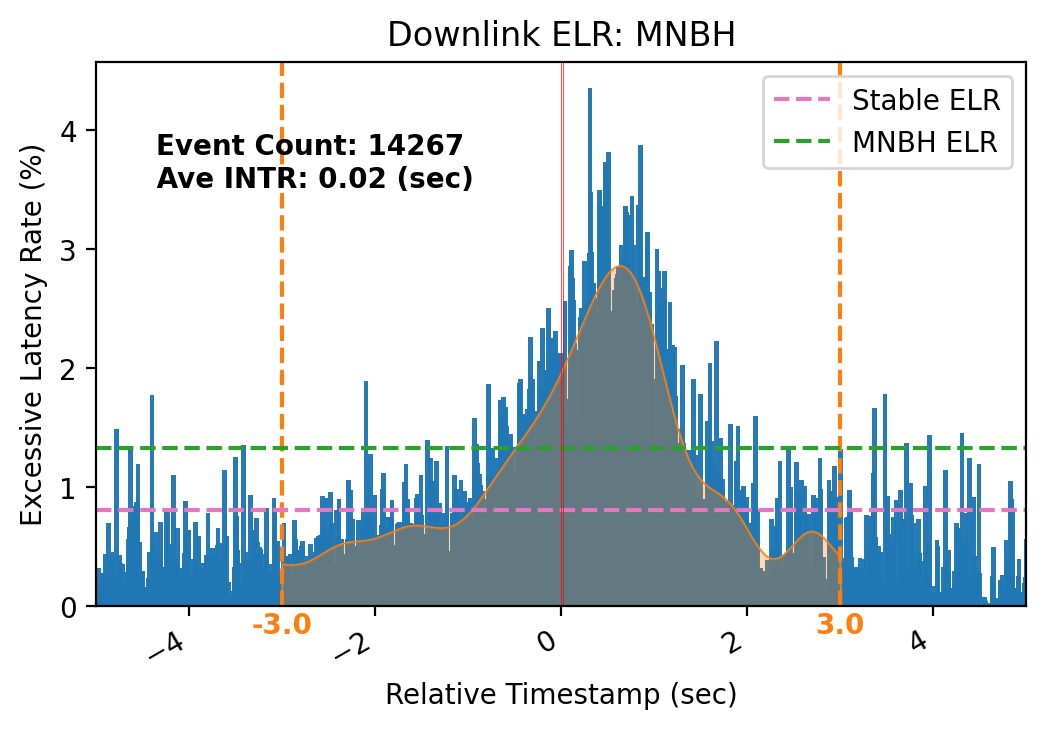

Number of Event: 14267
Average Duration: 0.020236961379407024 seconds
[(-5.0, 3.6), (-4.8, 3.8)]
Uplink Stable ELR: 3.9737
Uplink ELR (-3.0, 3.0) 5.417


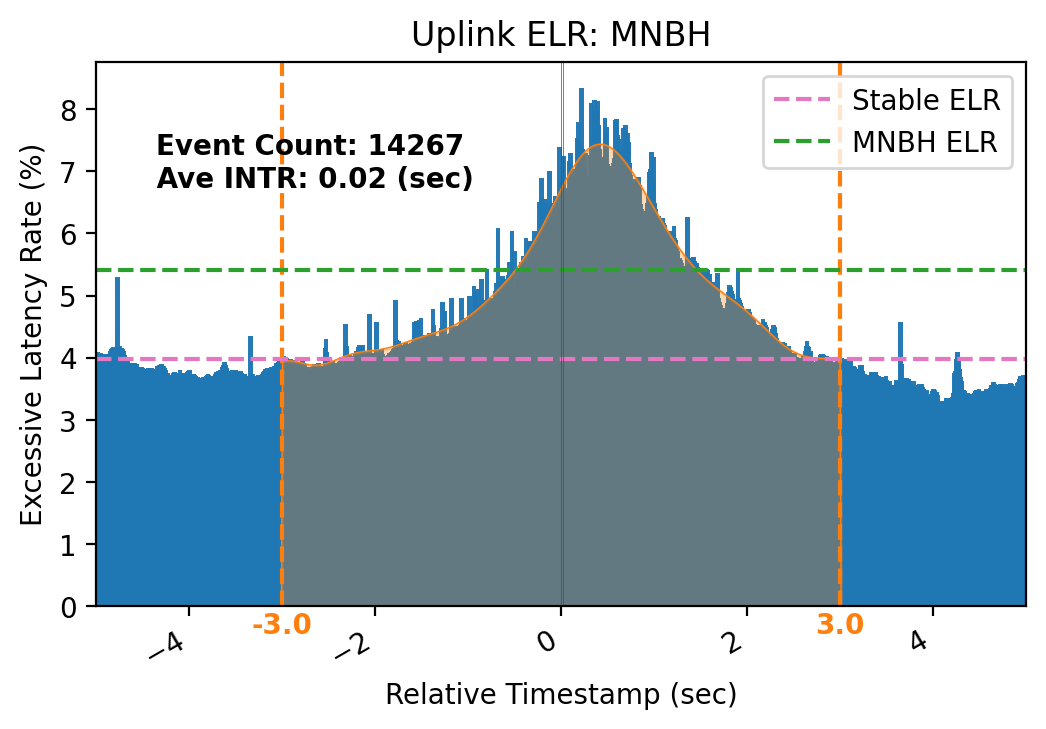

SCGM
Number of Event: 17827
Average Duration: 0.017196041566163684 seconds
[(-3.4, 2.7), (-3.3, 2.8)]
Downlink Stable PLR: 0.2494
Downlink PLR (-3.0, 3.0) 0.651


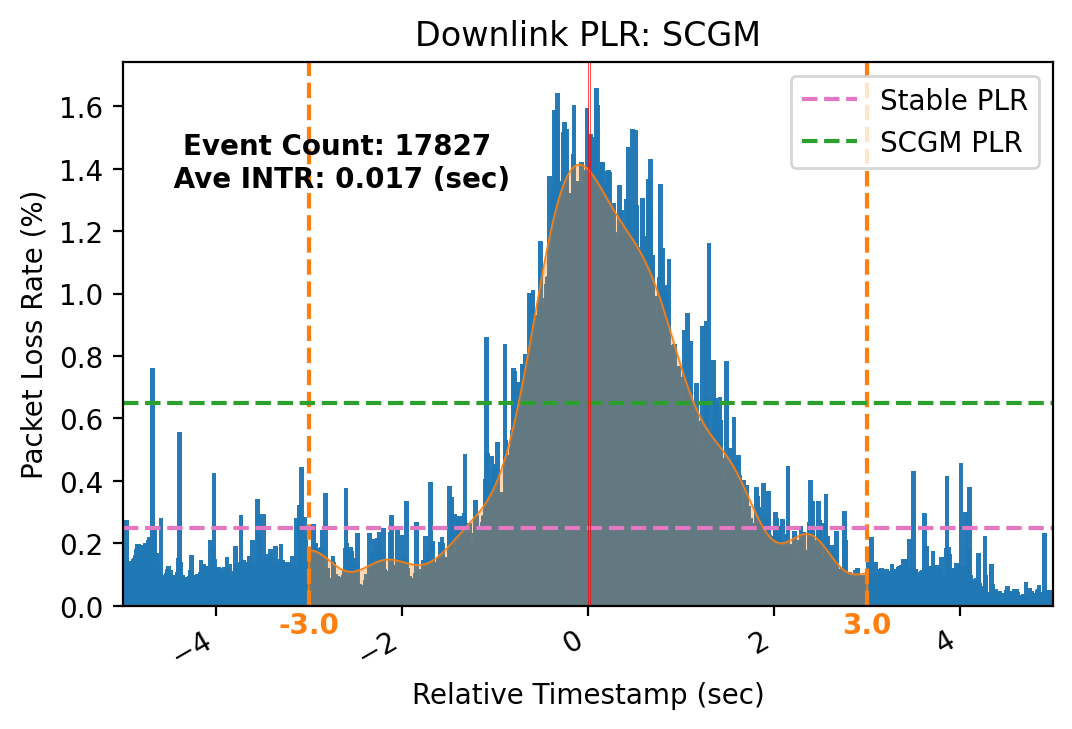

Number of Event: 17827
Average Duration: 0.017196041566163684 seconds
[(-5.0, 2.8)]
Uplink Stable PLR: 0.2428
Uplink PLR (-3.0, 3.0) 0.247


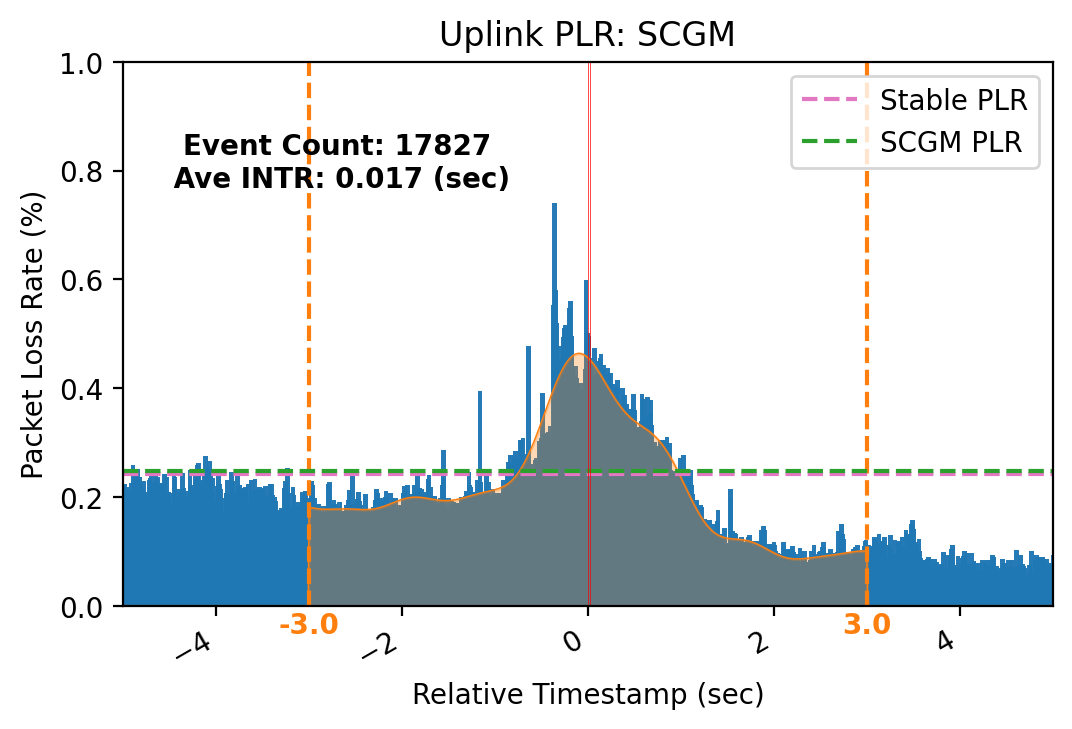

Number of Event: 17827
Average Duration: 0.017196041566163684 seconds
[(-3.3, 3.3), (-3.2, 3.4), (-3.1, 3.5), (-3.0, 3.6), (-2.9, 3.7), (-2.8, 3.8), (-2.7, 3.9)]
Downlink Stable ELR: 0.8031
Downlink ELR (-3.0, 3.0) 2.049


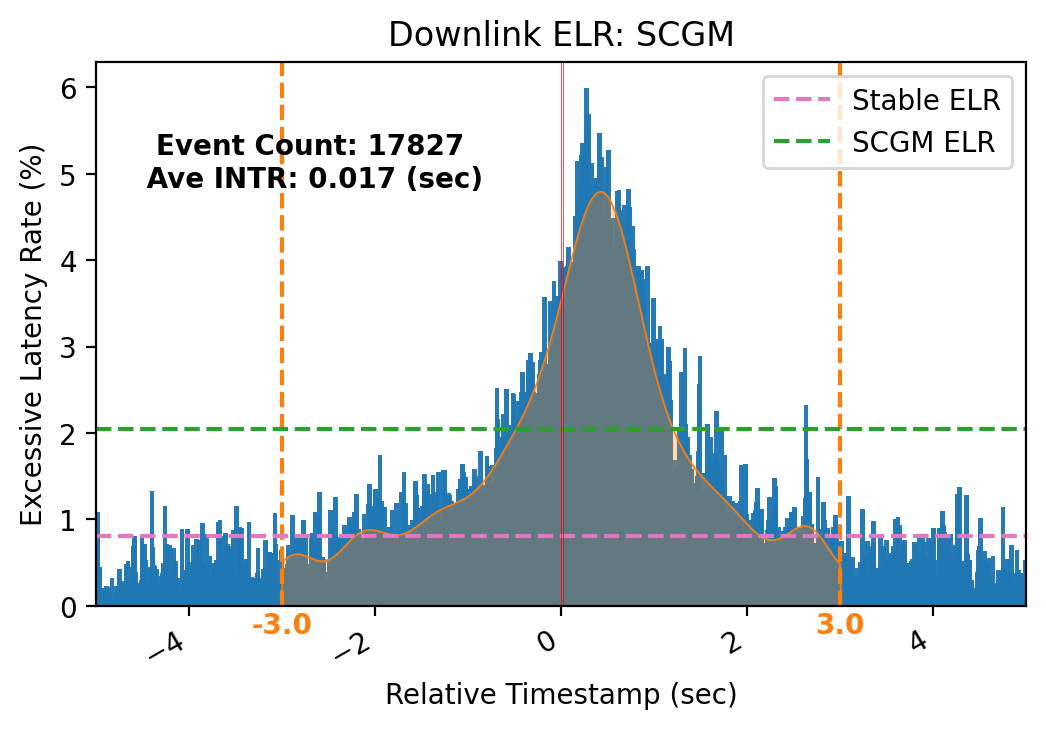

Number of Event: 17827
Average Duration: 0.017196041566163684 seconds
[(-4.9, 3.4), (-4.8, 3.5), (-4.7, 3.6), (-4.6, 3.7), (-4.5, 3.8), (-4.4, 3.9), (-4.3, 4.0), (-4.2, 4.1), (-4.1, 4.2), (-4.0, 4.3), (-3.9, 4.4), (-3.8, 4.5)]
Uplink Stable ELR: 3.9737
Uplink ELR (-3.0, 3.0) 5.24


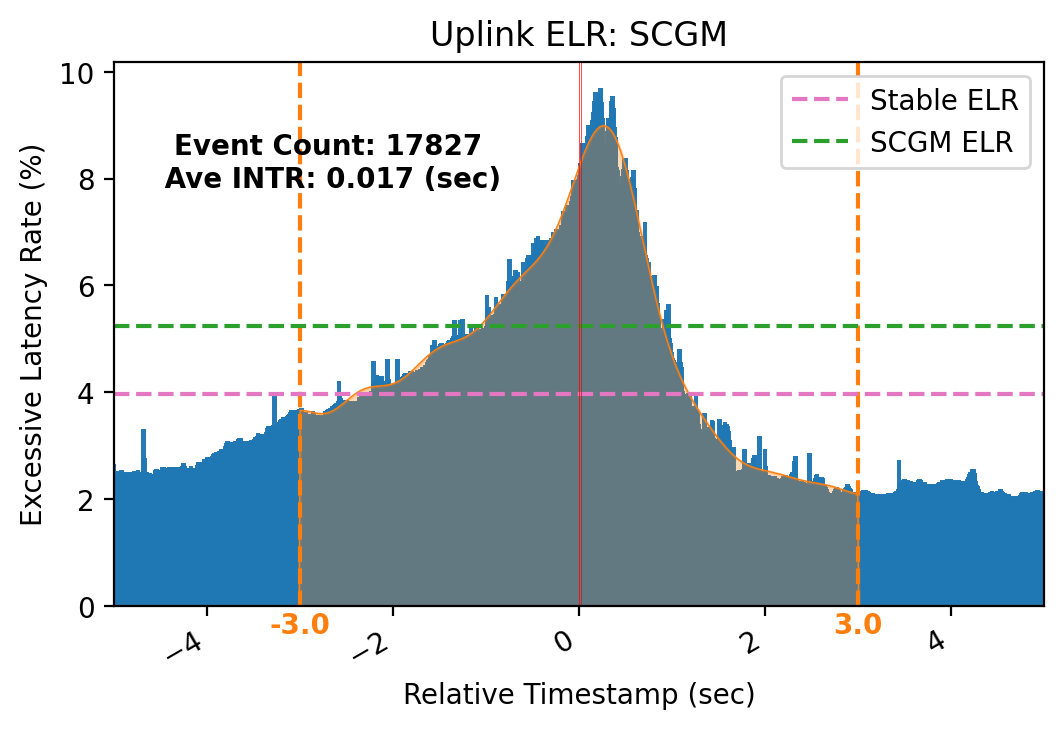

SCGA
Number of Event: 1955
Average Duration: 0.025867740153452685 seconds
[(-2.9, 2.2)]
Downlink Stable PLR: 0.2494
Downlink PLR (-3.0, 2.5) 2.623


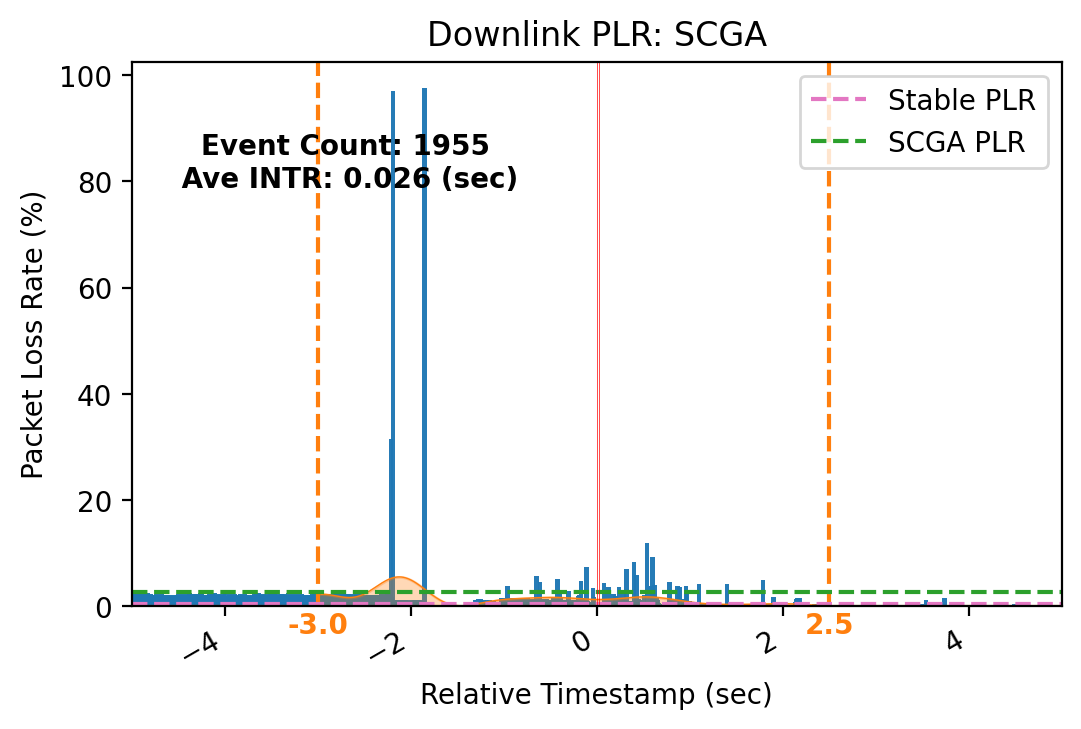

Number of Event: 1955
Average Duration: 0.025867740153452685 seconds
[(-2.2, 5.0)]
Uplink Stable PLR: 0.2428
Uplink PLR (-3.0, 2.5) 2.794


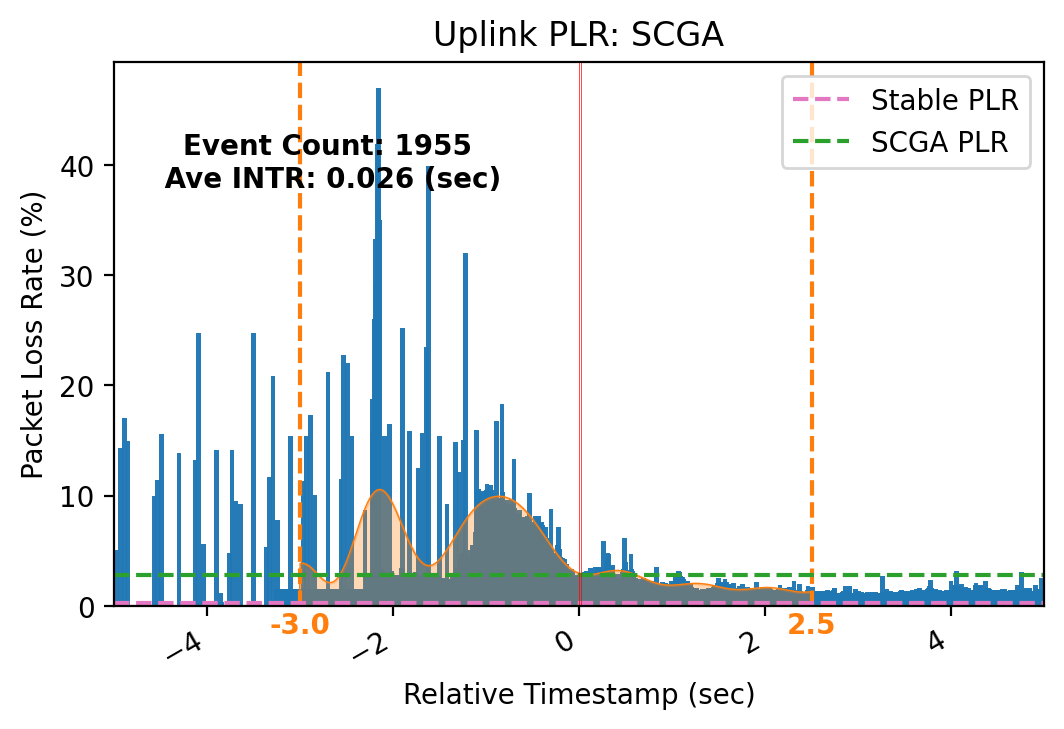

Number of Event: 1955
Average Duration: 0.025867740153452685 seconds
[(-1.3, 2.7), (-1.2, 2.8), (-1.1, 2.9), (-1.0, 3.0)]
Downlink Stable ELR: 0.8031
Downlink ELR (-3.0, 2.5) 5.462


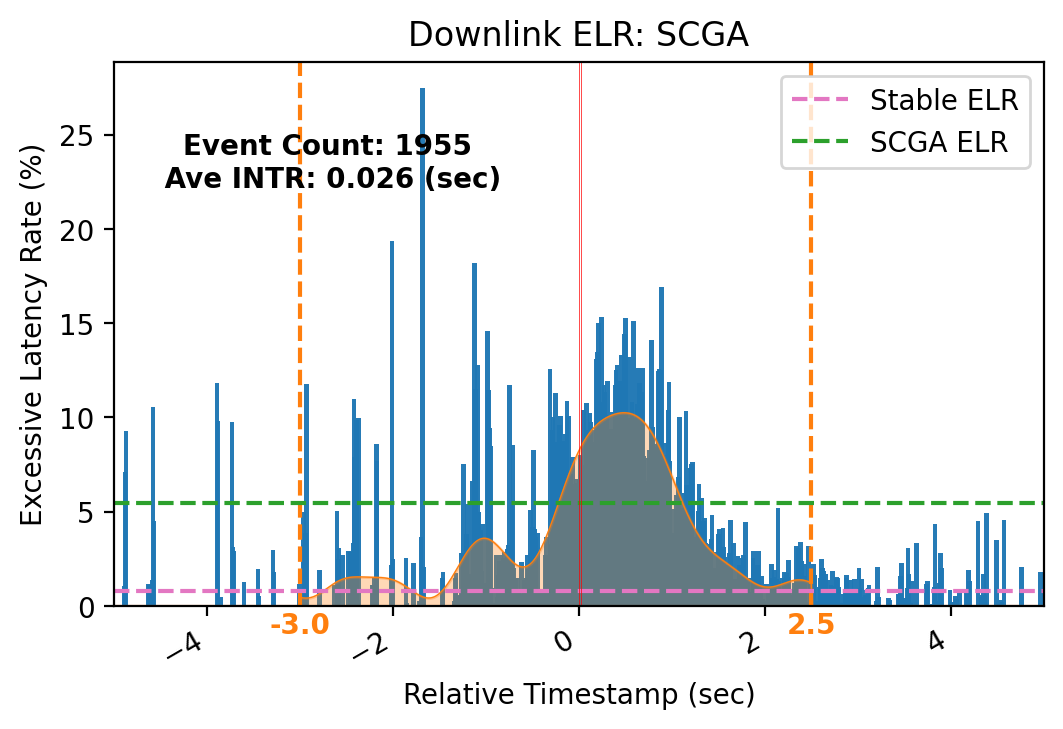

Number of Event: 1955
Average Duration: 0.025867740153452685 seconds
[(-1.1, 4.8), (-1.0, 4.9), (-0.9, 5.0)]
Uplink Stable ELR: 3.9737
Uplink ELR (-3.0, 2.5) 10.803


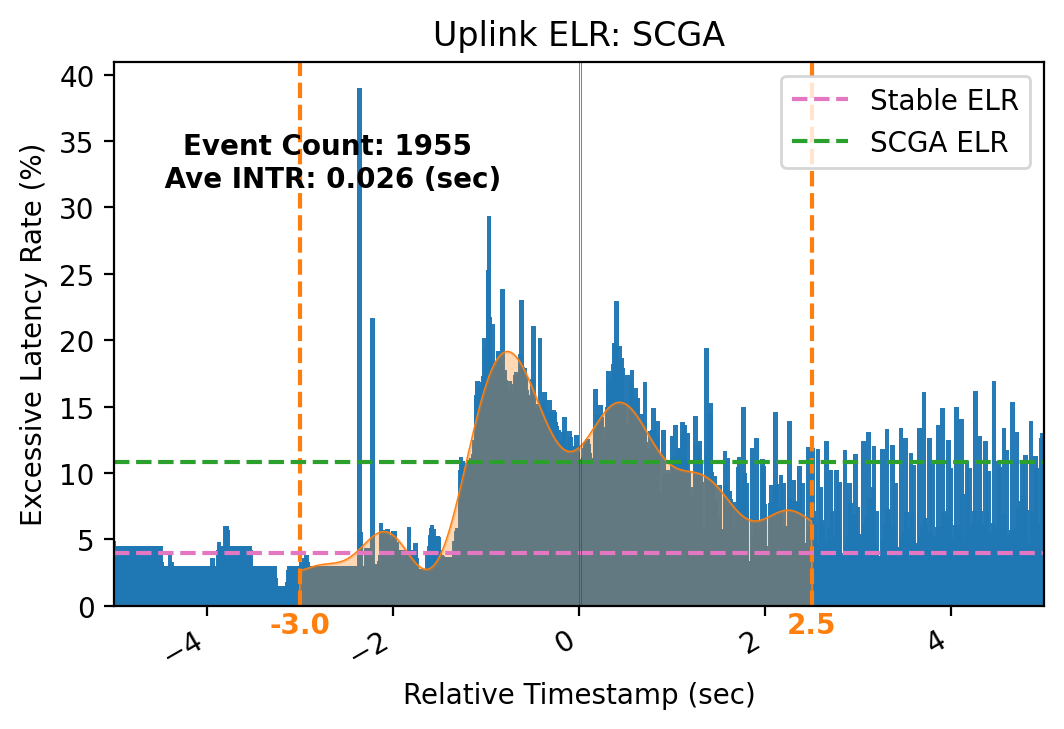

SCGR-I
Number of Event: 792
Average Duration: 0.03938503661616161 seconds
[(-3.3, 3.6), (-3.2, 3.7), (-3.1, 3.8)]
Downlink Stable PLR: 0.2494
Downlink PLR (-3.5, 3.0) 2.119


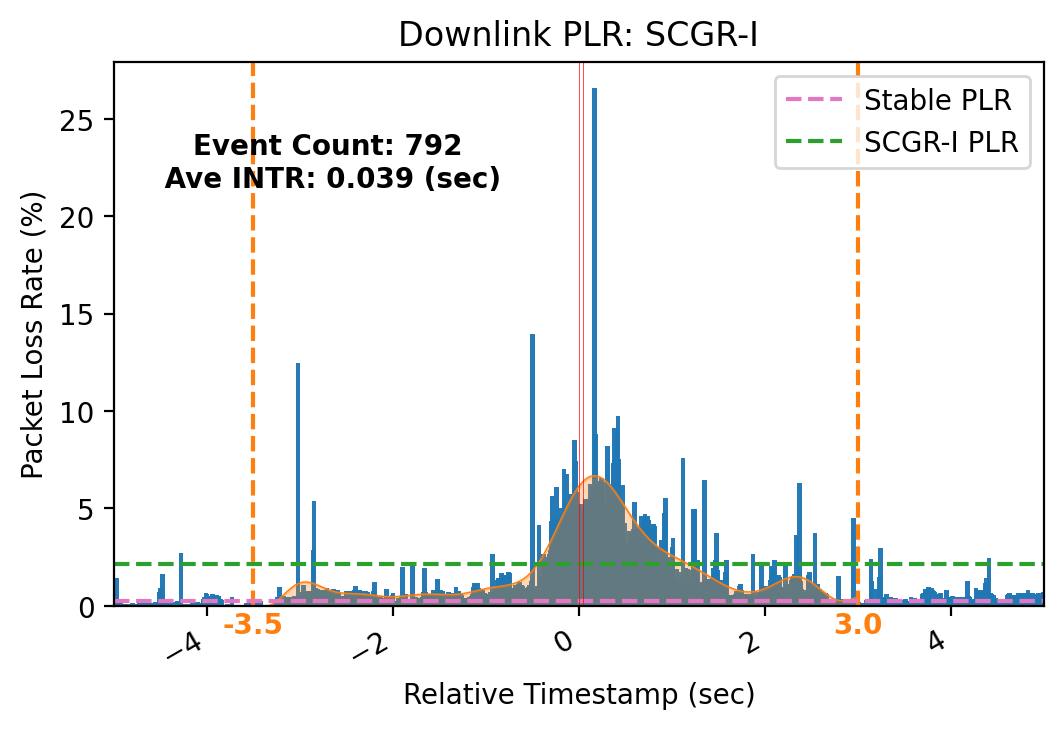

Number of Event: 792
Average Duration: 0.03938503661616161 seconds
[(-5.0, 4.0), (-4.9, 4.1)]
Uplink Stable PLR: 0.2428
Uplink PLR (-3.5, 3.0) 2.626


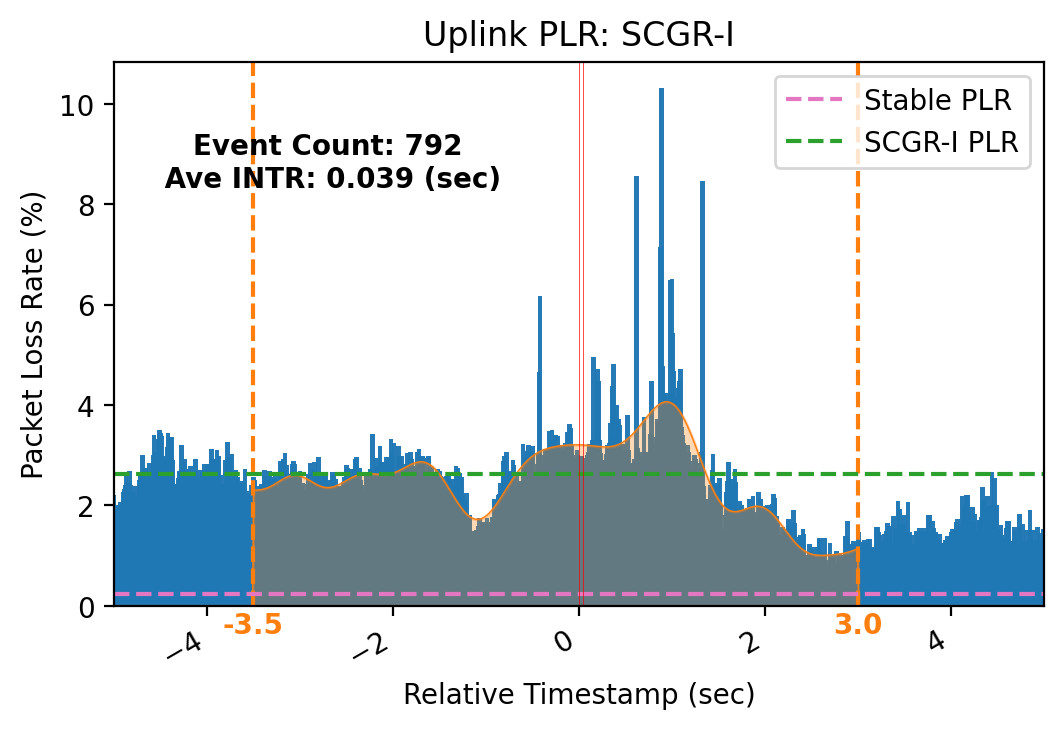

Number of Event: 792
Average Duration: 0.03938503661616161 seconds
[(-3.1, 4.7)]
Downlink Stable ELR: 0.8031
Downlink ELR (-3.5, 3.0) 5.997


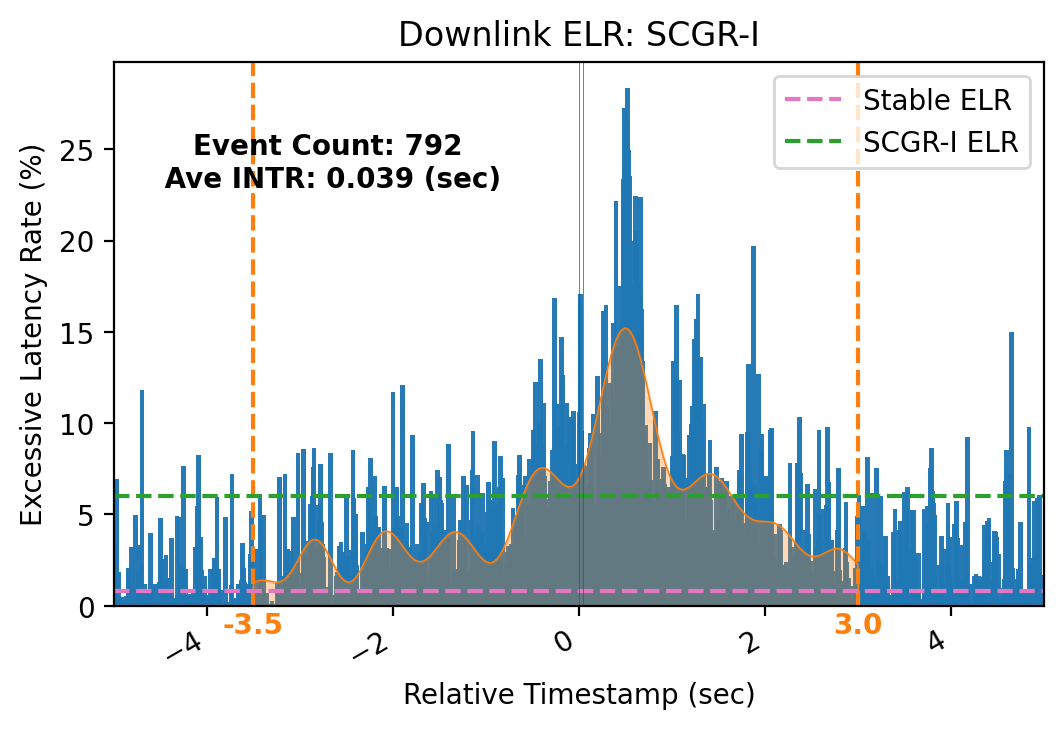

Number of Event: 792
Average Duration: 0.03938503661616161 seconds
[(-5.0, 2.6)]
Uplink Stable ELR: 3.9737
Uplink ELR (-3.5, 3.0) 20.664


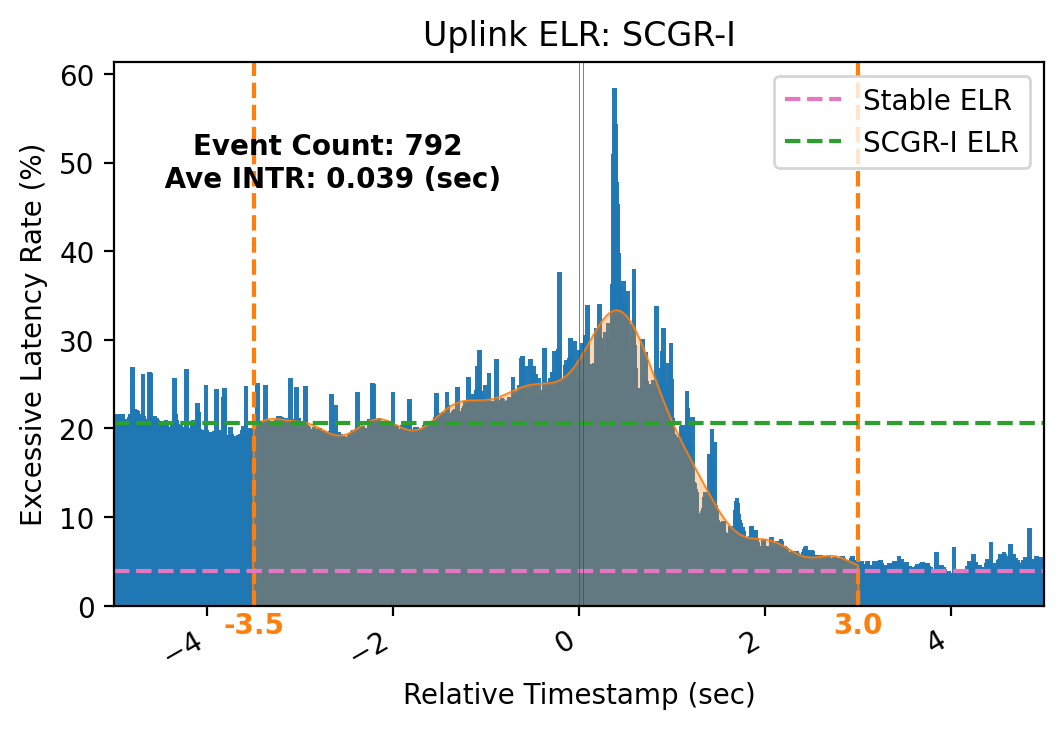

SCGR-II
Number of Event: 1433
Average Duration: 0.03462069295184927 seconds
[(-1.2, 2.9)]
Downlink Stable PLR: 0.2494
Downlink PLR (-2.0, 3.0) 2.594


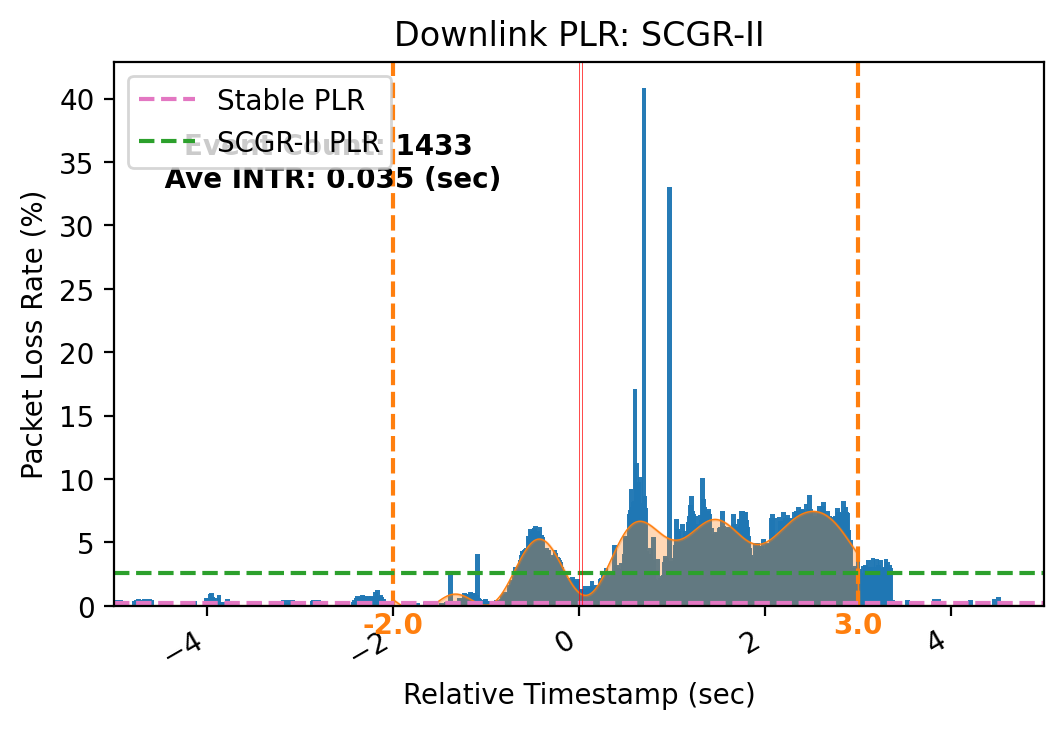

Number of Event: 1433
Average Duration: 0.03462069295184927 seconds
[(-3.8, 1.5)]
Uplink Stable PLR: 0.2428
Uplink PLR (-2.0, 3.0) 2.014


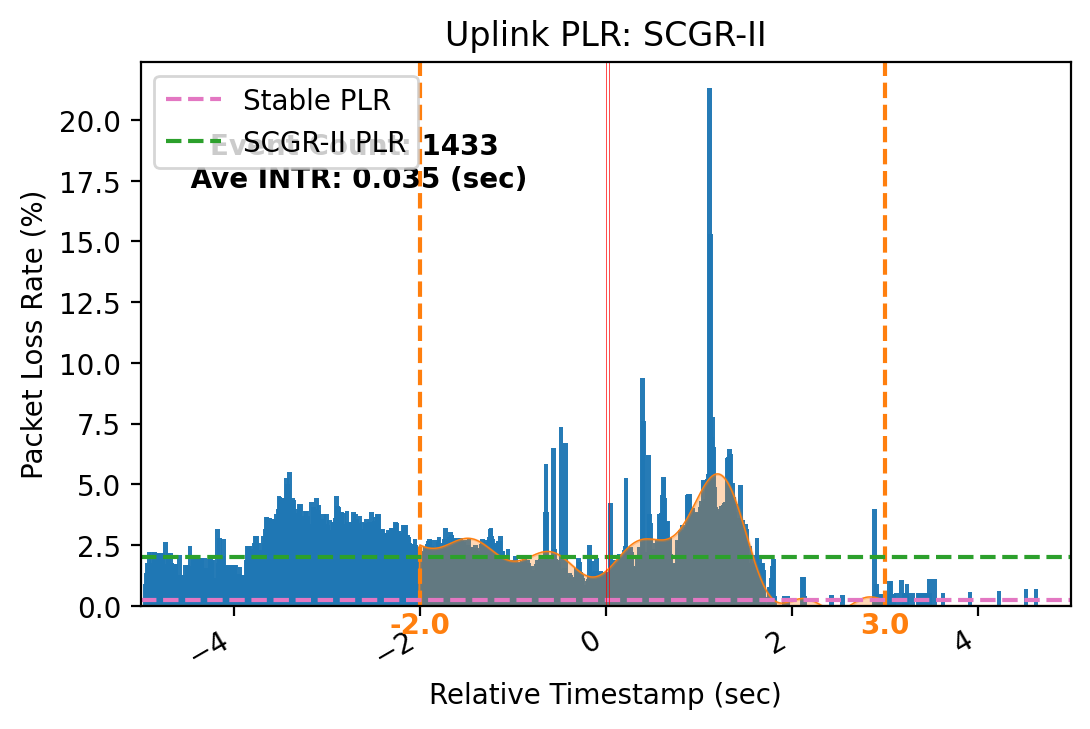

Number of Event: 1433
Average Duration: 0.03462069295184927 seconds
[(-4.6, 1.5)]
Downlink Stable ELR: 0.8031
Downlink ELR (-2.0, 3.0) 4.241


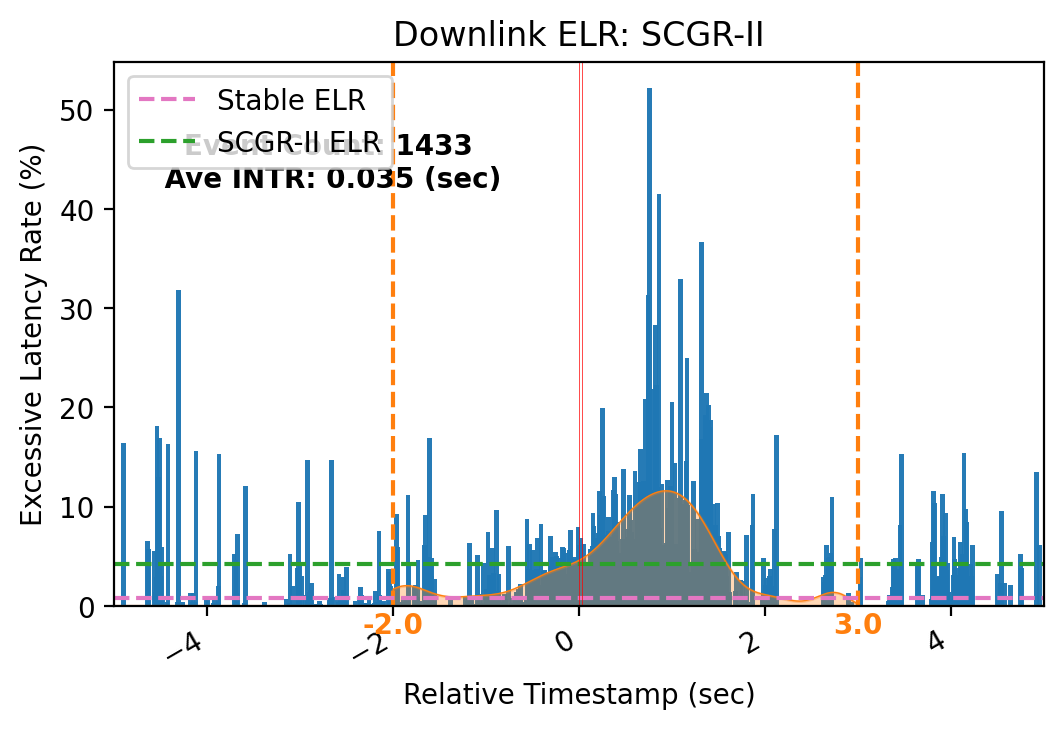

Number of Event: 1433
Average Duration: 0.03462069295184927 seconds
[(-5.0, 3.5)]
Uplink Stable ELR: 3.9737
Uplink ELR (-2.0, 3.0) 12.913


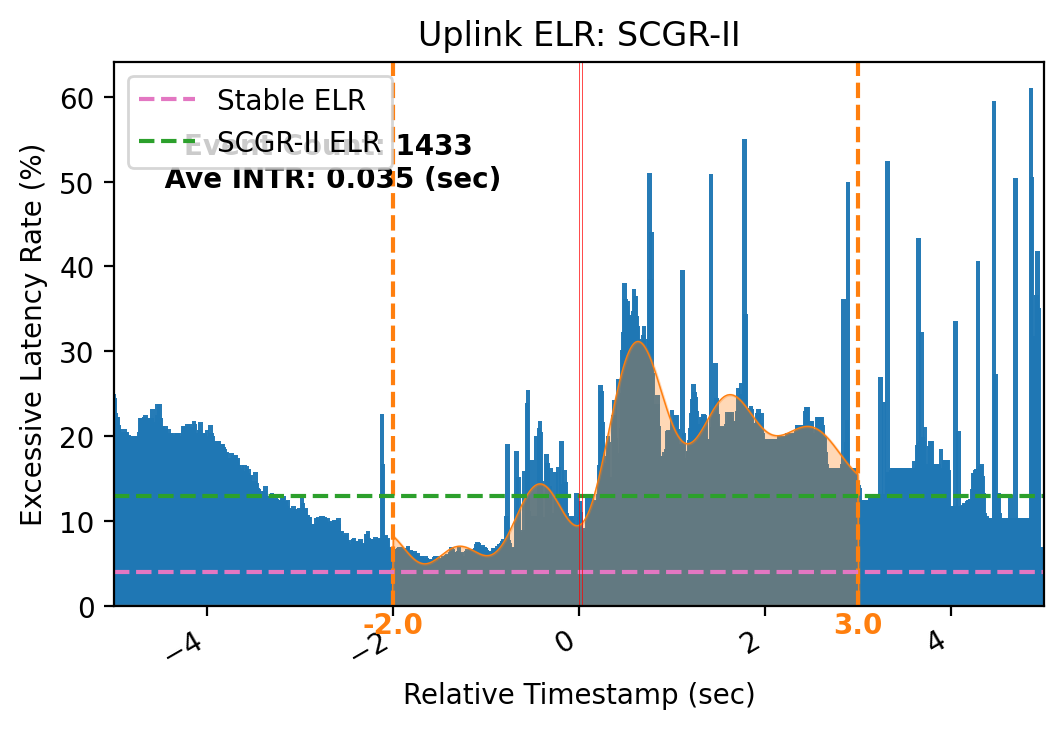

SCGC-I
Number of Event: 122
Average Duration: 0.4066515655737706 seconds
[(-1.7, 2.4), (-1.6, 2.5), (-1.5, 2.6)]
Downlink Stable PLR: 0.2494
Downlink PLR (-3.0, 3.0) 4.468


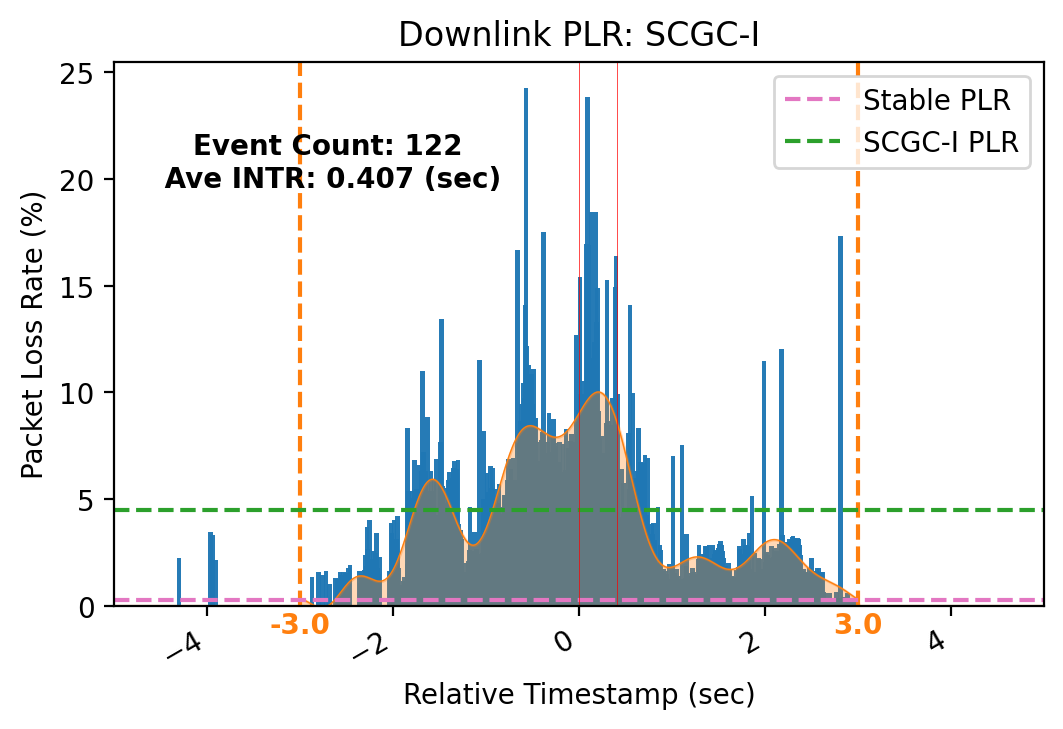

Number of Event: 122
Average Duration: 0.4066515655737706 seconds
[(-1.2, 5.0)]
Uplink Stable PLR: 0.2428
Uplink PLR (-3.0, 3.0) 1.727


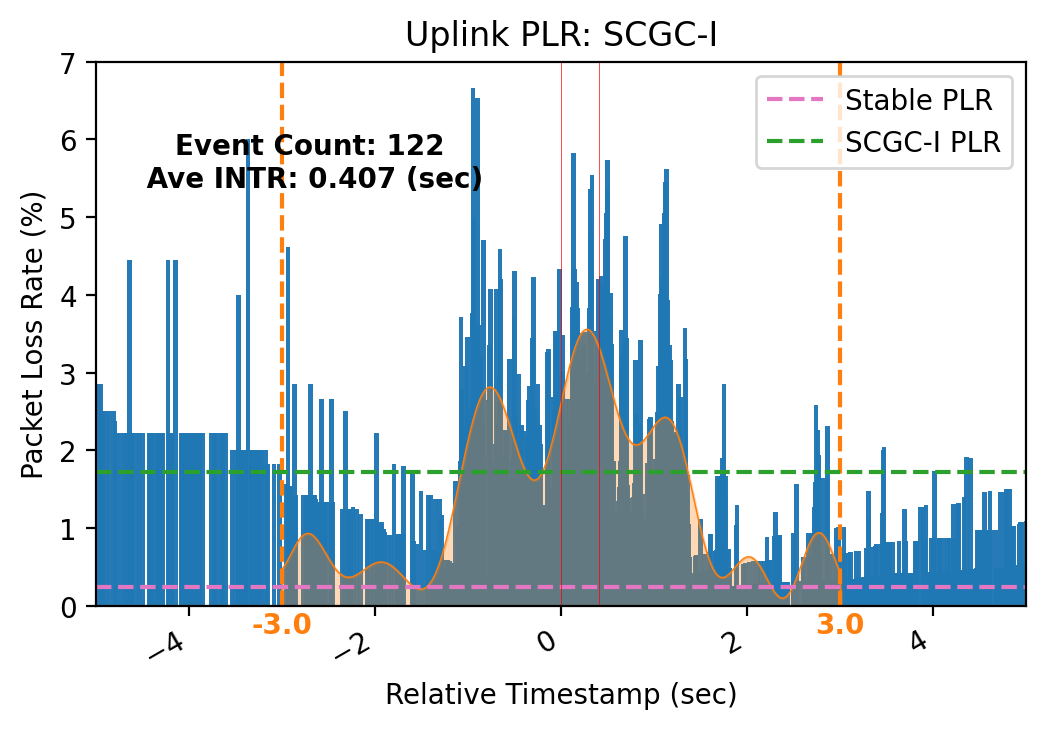

Number of Event: 122
Average Duration: 0.4066515655737706 seconds
[(-2.0, 2.9), (-1.7, 3.2), (-1.6, 3.3), (-1.5, 3.4)]
Downlink Stable ELR: 0.8031
Downlink ELR (-3.0, 3.0) 14.67


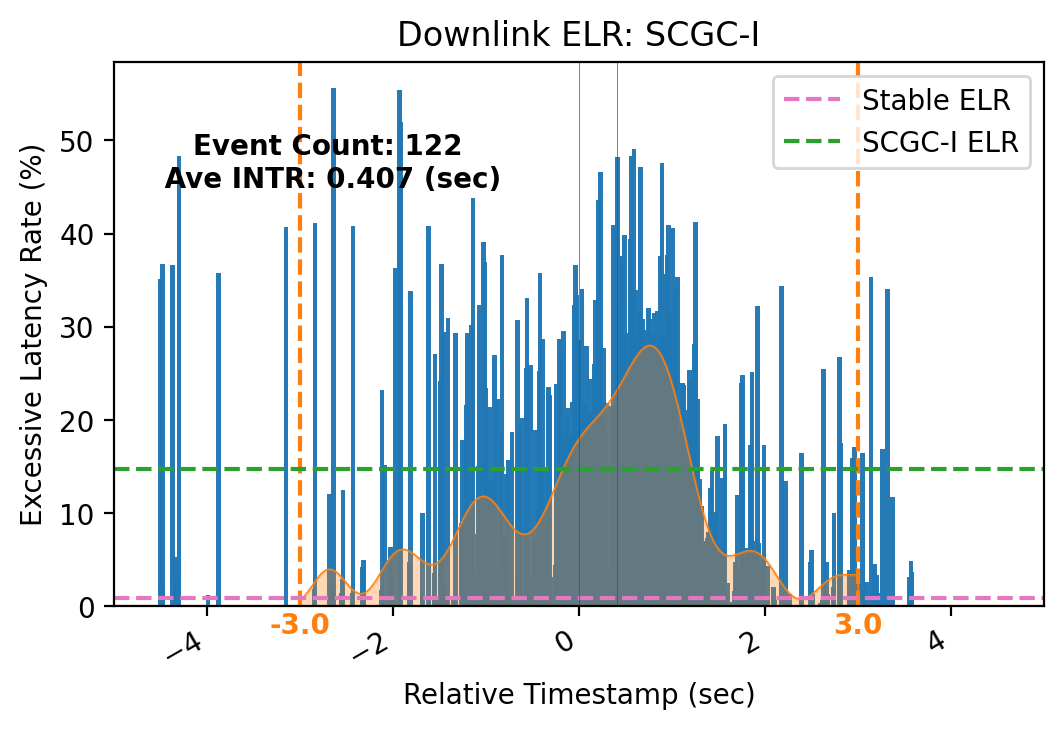

Number of Event: 122
Average Duration: 0.4066515655737706 seconds
[(-3.0, 3.0), (-2.9, 3.1)]
Uplink Stable ELR: 3.9737
Uplink ELR (-3.0, 3.0) 25.812


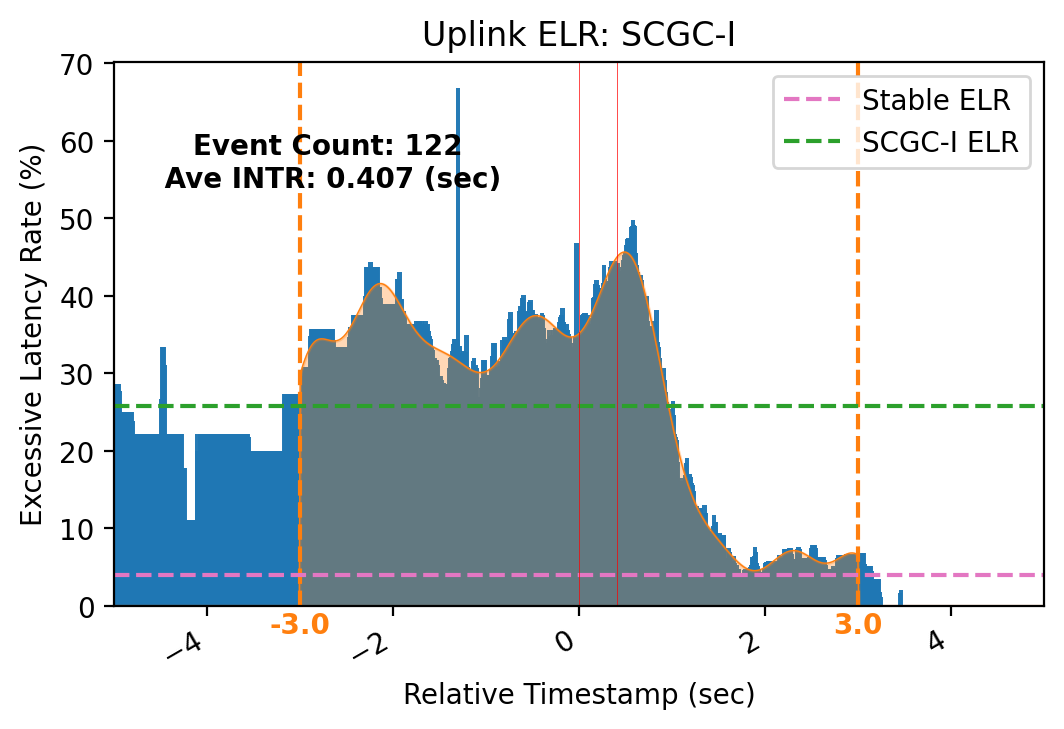

SCGC-II
Number of Event: 944
Average Duration: 0.3995860455508475 seconds
[(-4.0, 1.8), (-3.9, 1.9)]
Downlink Stable PLR: 0.2494
Downlink PLR (-2.0, 2.0) 1.101


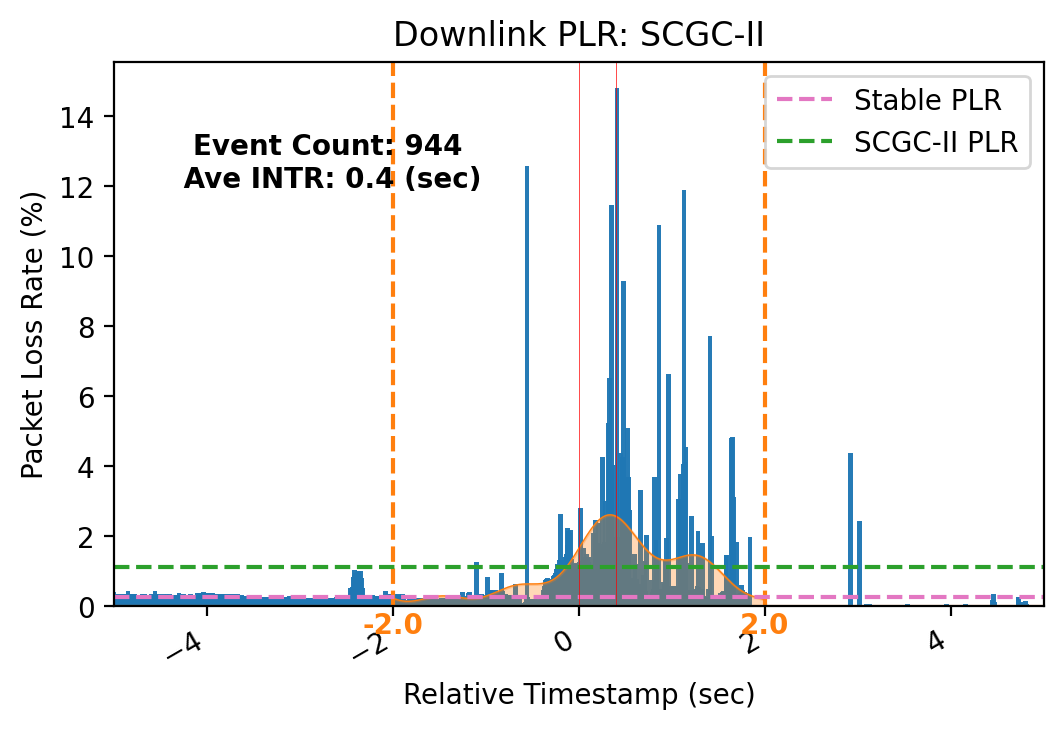

Number of Event: 944
Average Duration: 0.3995860455508475 seconds
[(-5.0, 2.8)]
Uplink Stable PLR: 0.2428
Uplink PLR (-2.0, 2.0) 1.414


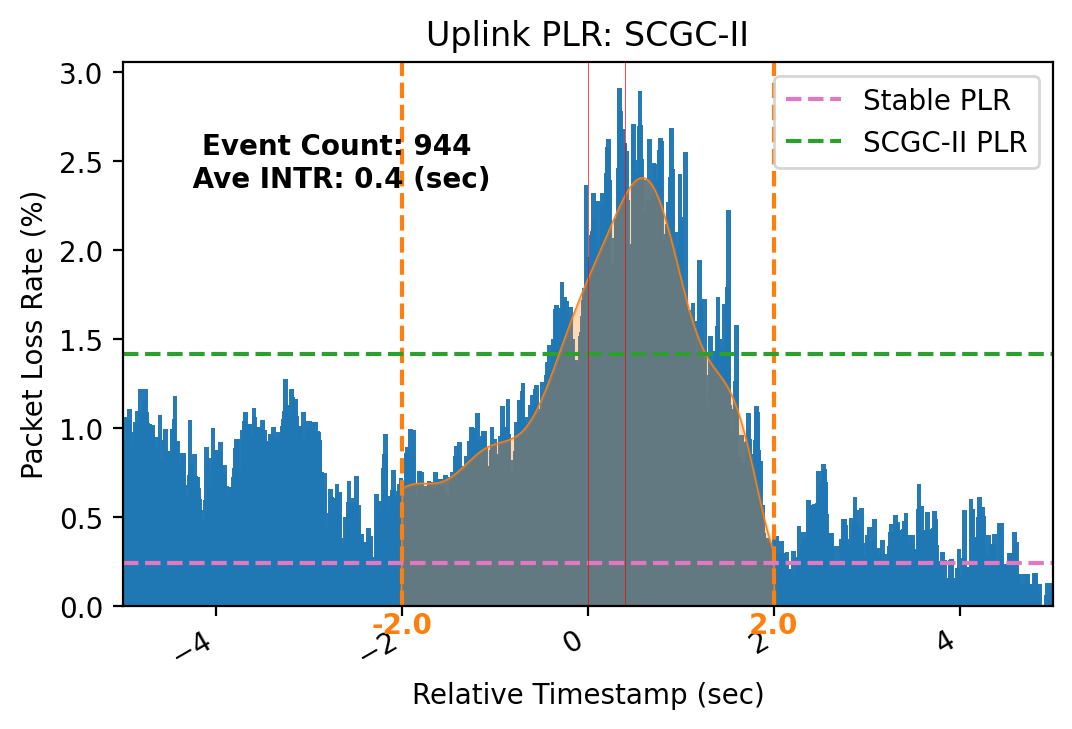

Number of Event: 944
Average Duration: 0.3995860455508475 seconds
[(-1.3, 3.0), (-1.2, 3.1)]
Downlink Stable ELR: 0.8031
Downlink ELR (-2.0, 2.0) 4.699


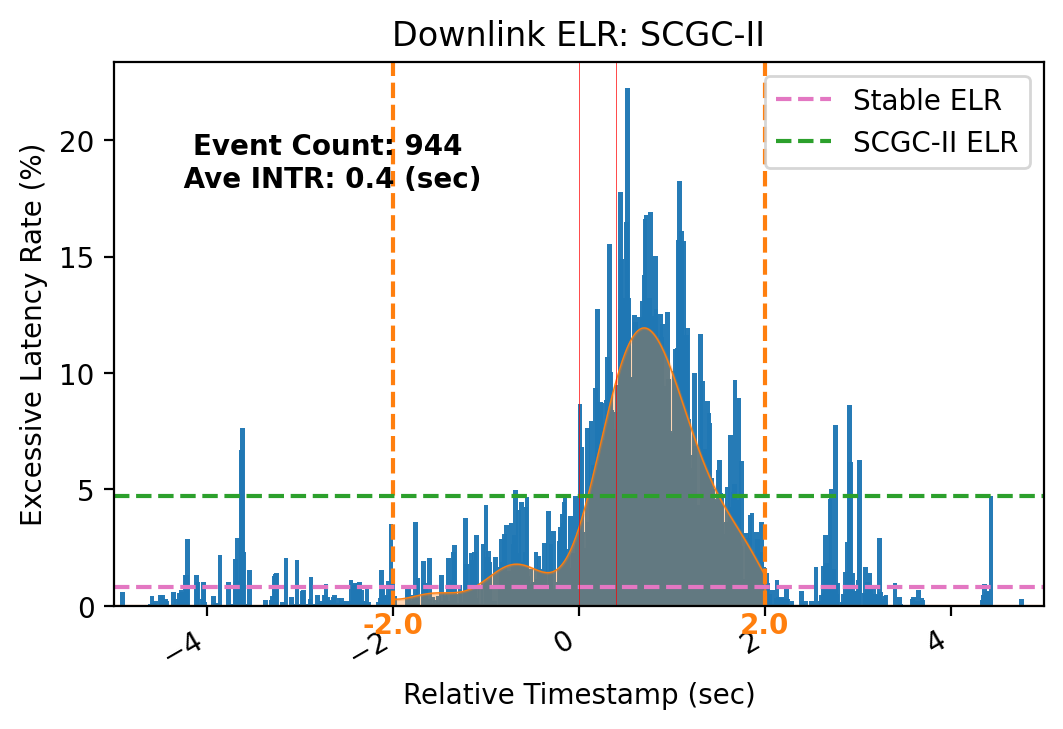

Number of Event: 944
Average Duration: 0.3995860455508475 seconds
[(-3.6, 3.2)]
Uplink Stable ELR: 3.9737
Uplink ELR (-2.0, 2.0) 6.006


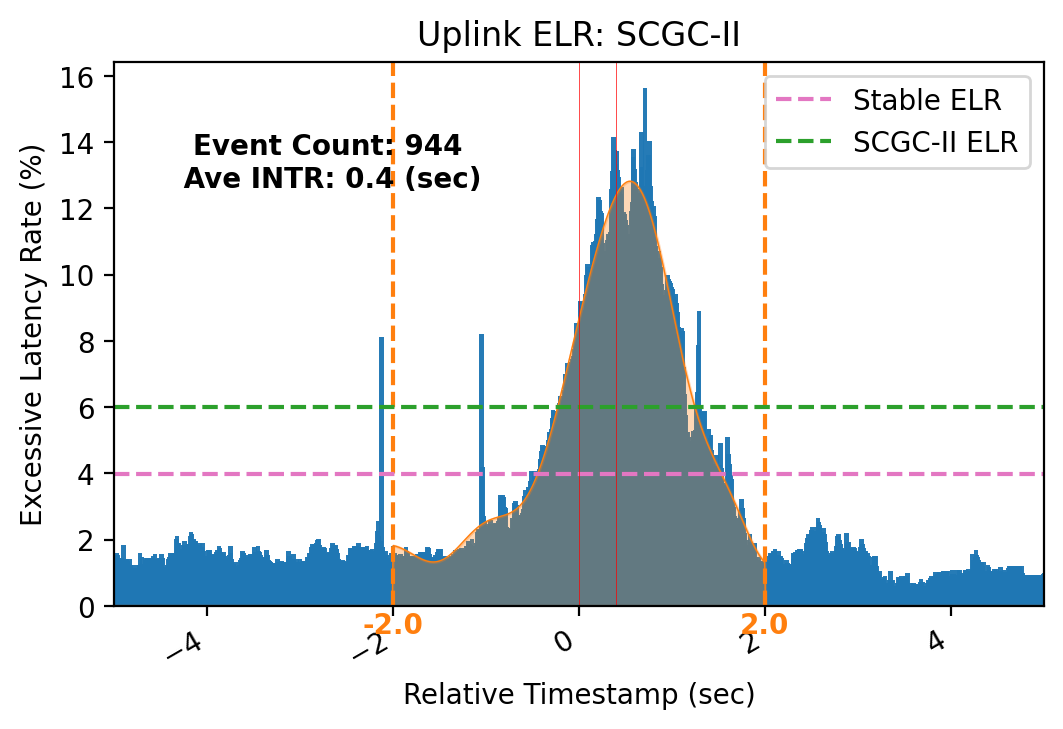

MCGF
Number of Event: 3024
Average Duration: 0.0784555539021164 seconds
[(-5.8, 7.2), (-5.5, 7.5), (-5.3, 7.7)]
Downlink Stable PLR: 0.2494
Downlink PLR (-5.0, 7.5) 16.618


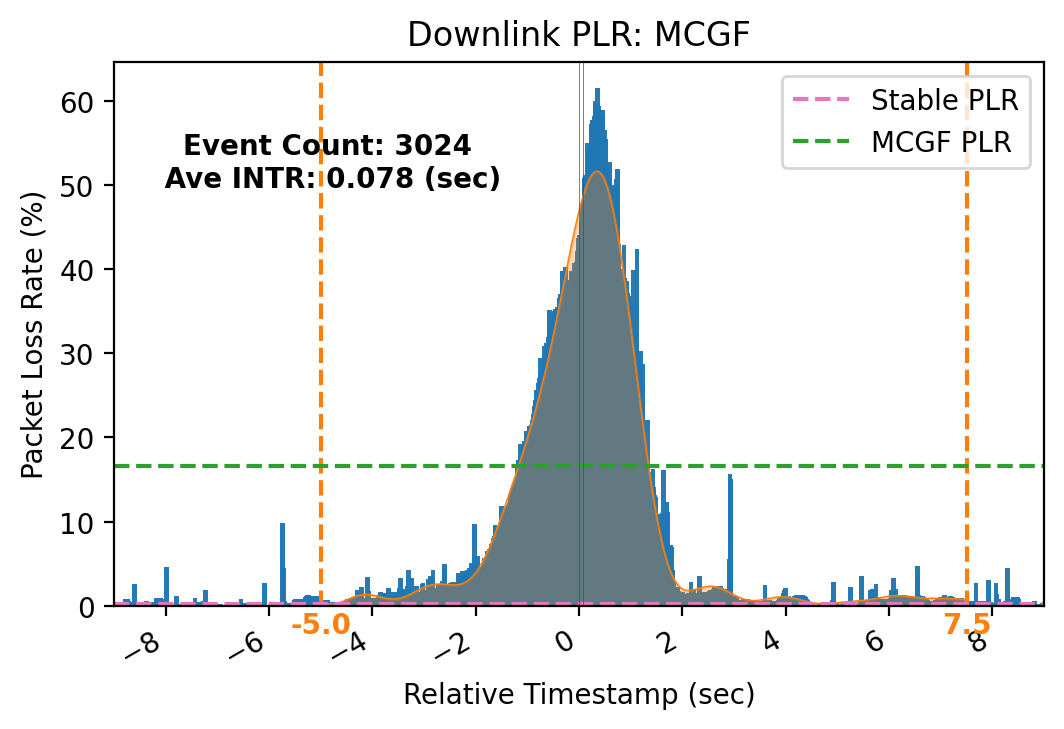

Number of Event: 3024
Average Duration: 0.0784555539021164 seconds
[(-8.6, 8.8)]
Uplink Stable PLR: 0.2428
Uplink PLR (-5.0, 7.5) 1.807


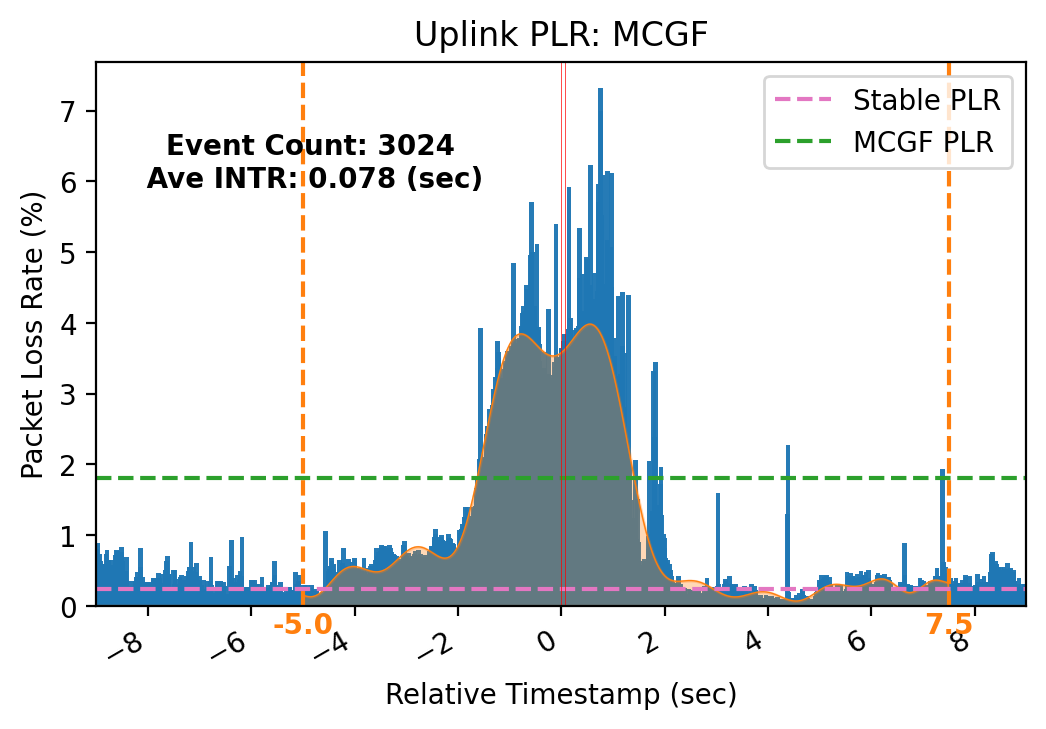

Number of Event: 3024
Average Duration: 0.0784555539021164 seconds
[(-8.6, 8.7)]
Downlink Stable ELR: 0.8031
Downlink ELR (-5.0, 7.5) 5.168


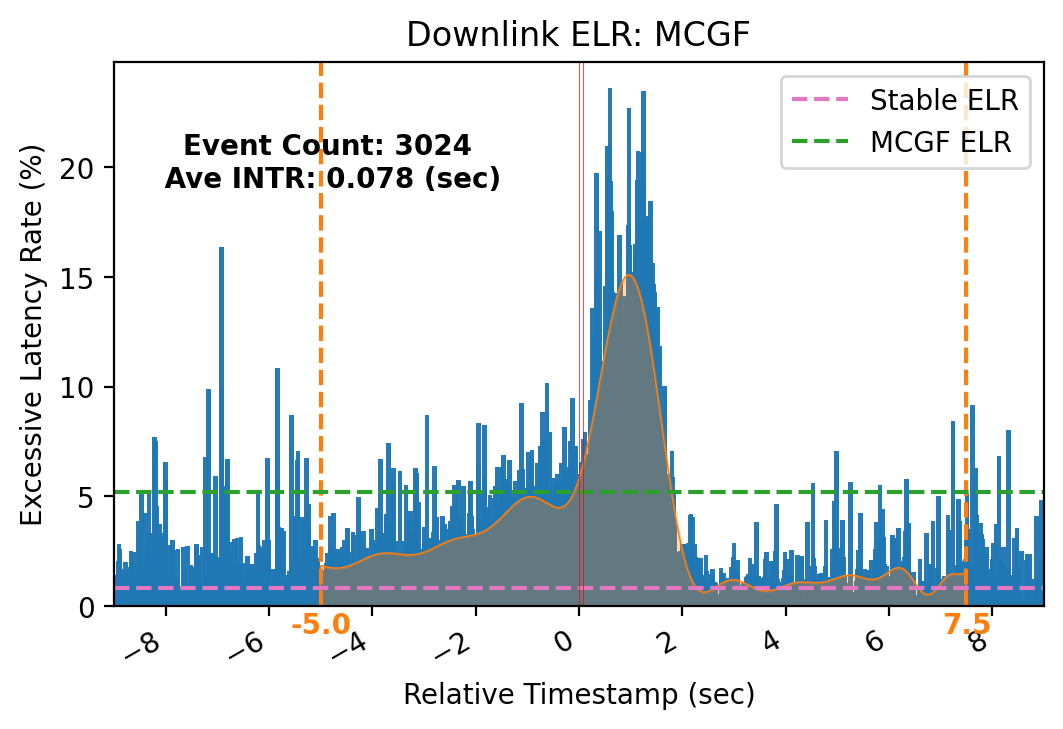

Number of Event: 3024
Average Duration: 0.0784555539021164 seconds
[(-8.3, 8.8), (-8.2, 8.9)]
Uplink Stable ELR: 3.9737
Uplink ELR (-5.0, 7.5) 16.808


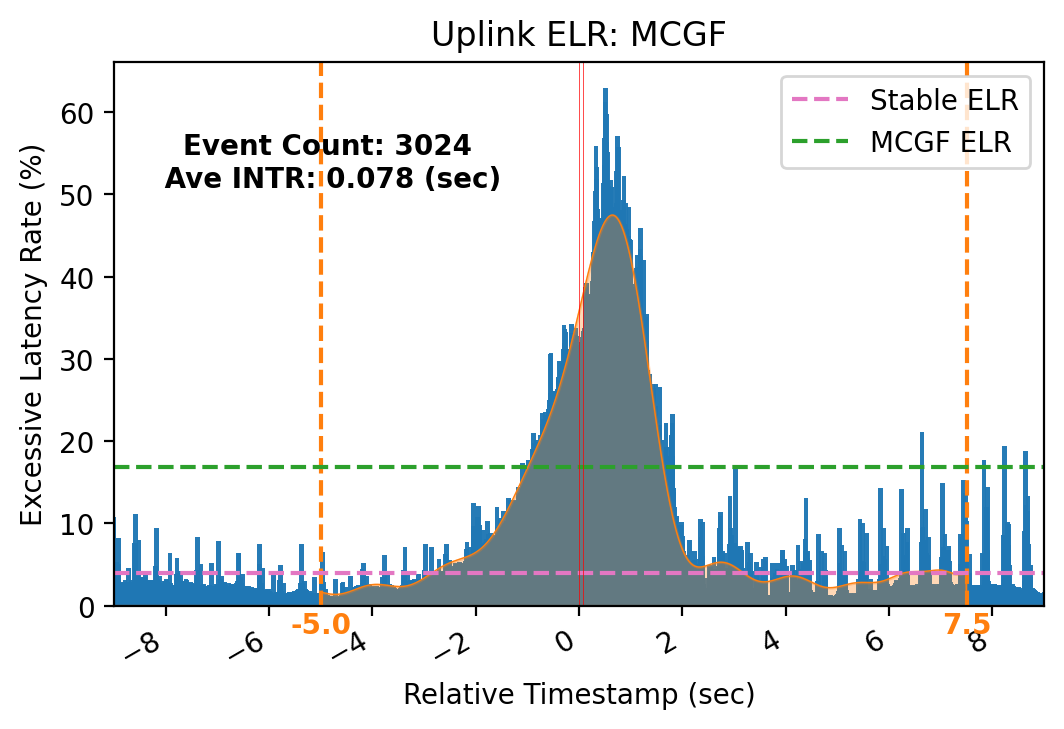

NASR
Number of Event: 45
Average Duration: 0.3928153111111112 seconds
[(-3.9, 5.4)]
Downlink Stable PLR: 0.2494
Downlink PLR (-4.0, 7.0) 30.051


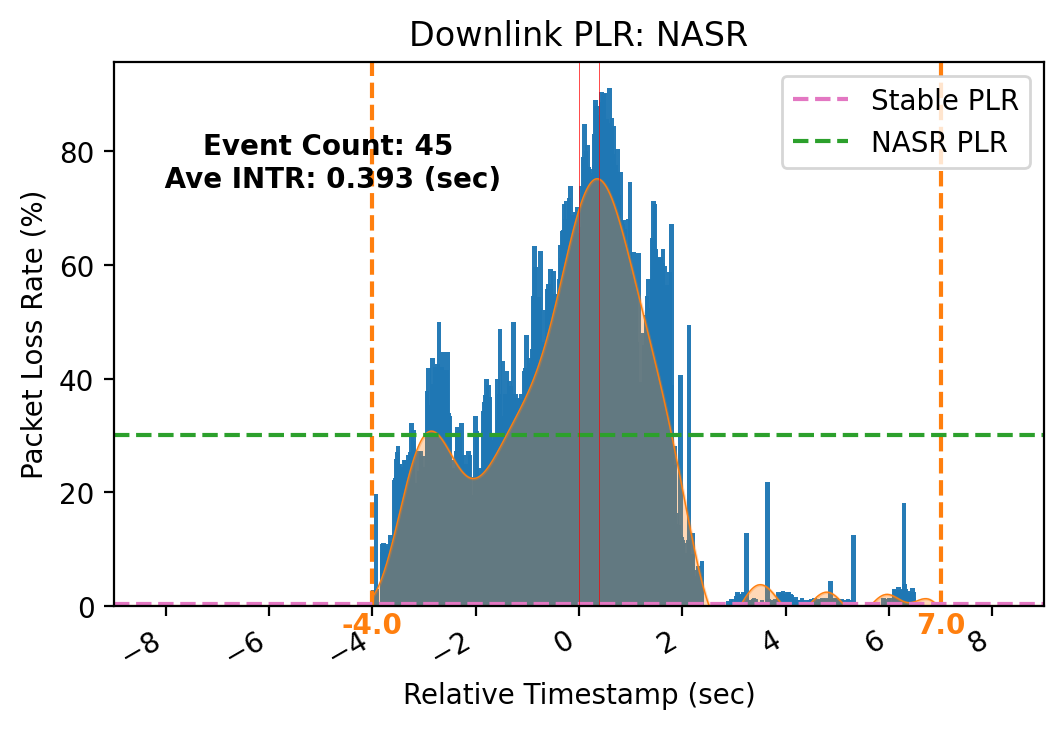

Number of Event: 45
Average Duration: 0.3928153111111112 seconds
[(-2.7, 4.9)]
Uplink Stable PLR: 0.2428
Uplink PLR (-4.0, 7.0) 8.908


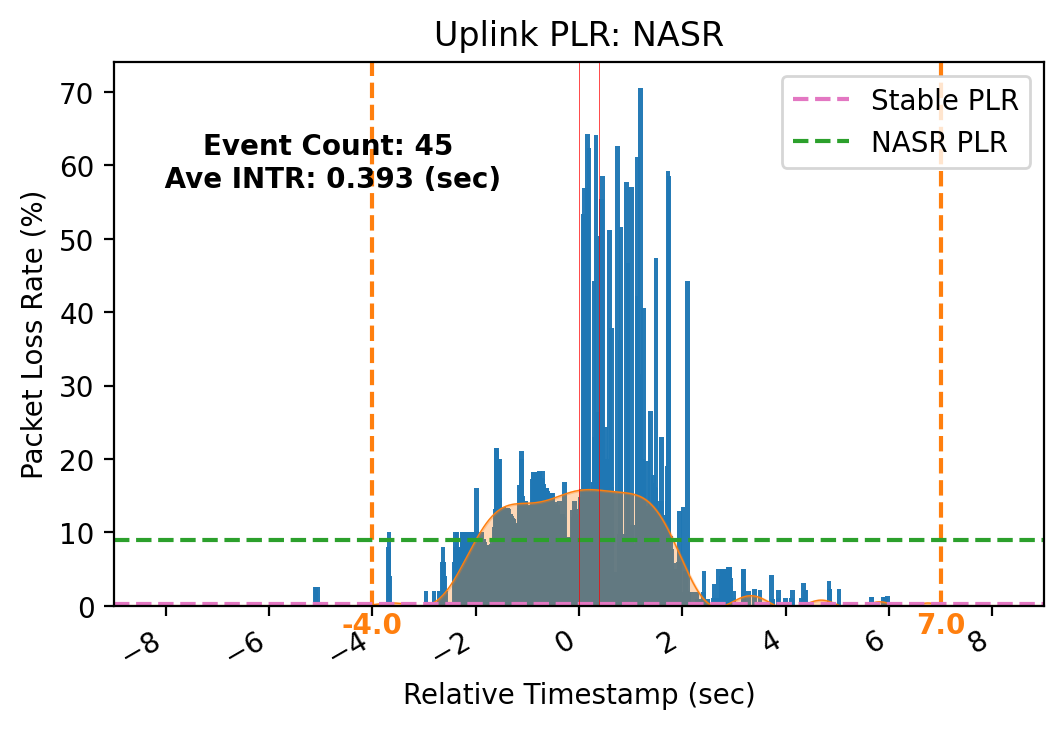

Number of Event: 45
Average Duration: 0.3928153111111112 seconds
[(-7.0, 6.9)]
Downlink Stable ELR: 0.8031
Downlink ELR (-4.0, 7.0) 4.498


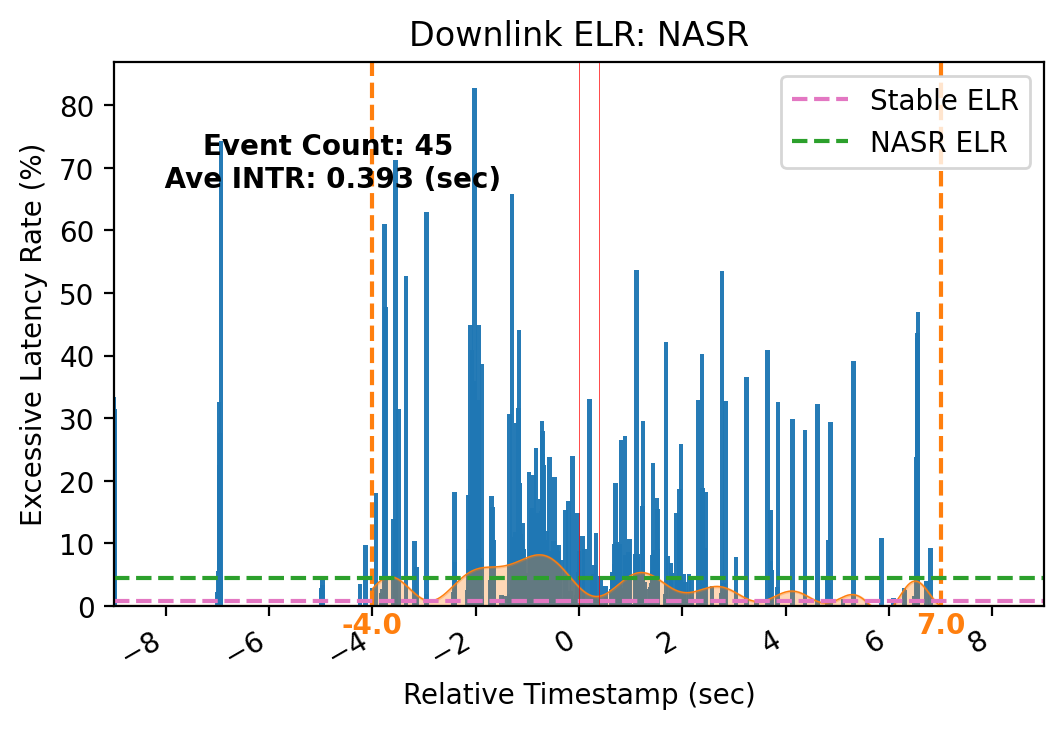

Number of Event: 45
Average Duration: 0.3928153111111112 seconds
[(-7.4, 8.6)]
Uplink Stable ELR: 3.9737
Uplink ELR (-4.0, 7.0) 20.676


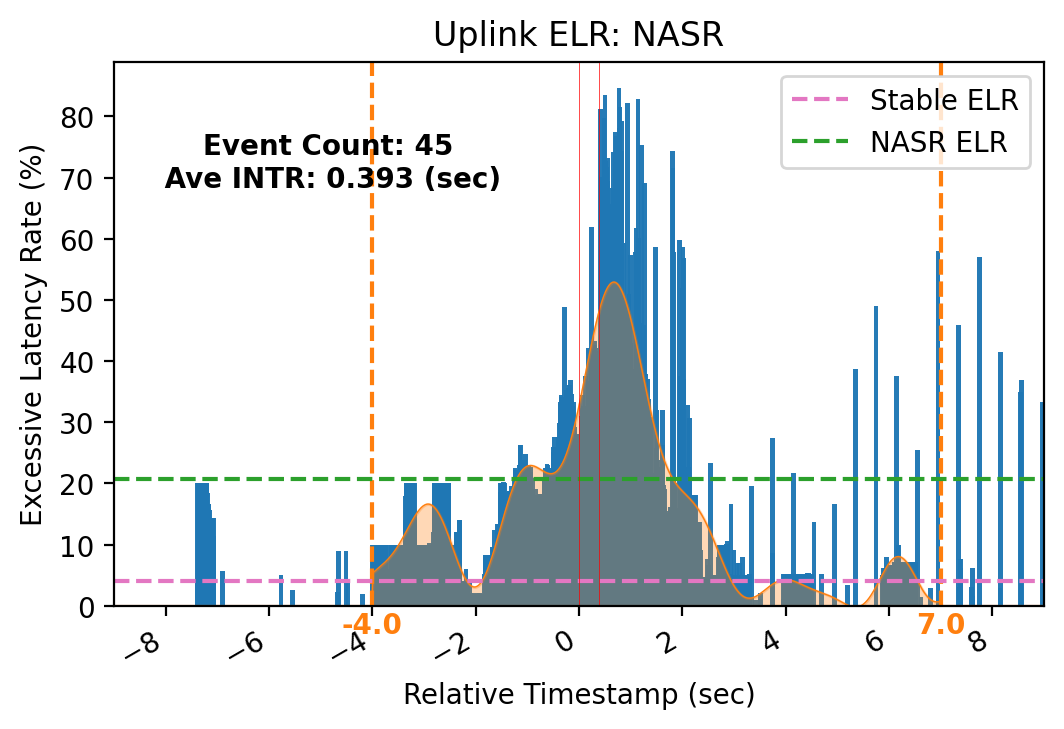

SCGF
Number of Event: 1181
Average Duration: 0.10621187214225232 seconds
[(-8.7, 9.0)]
Downlink Stable PLR: 0.2494
Downlink PLR (-4.0, 5.0) 1.729


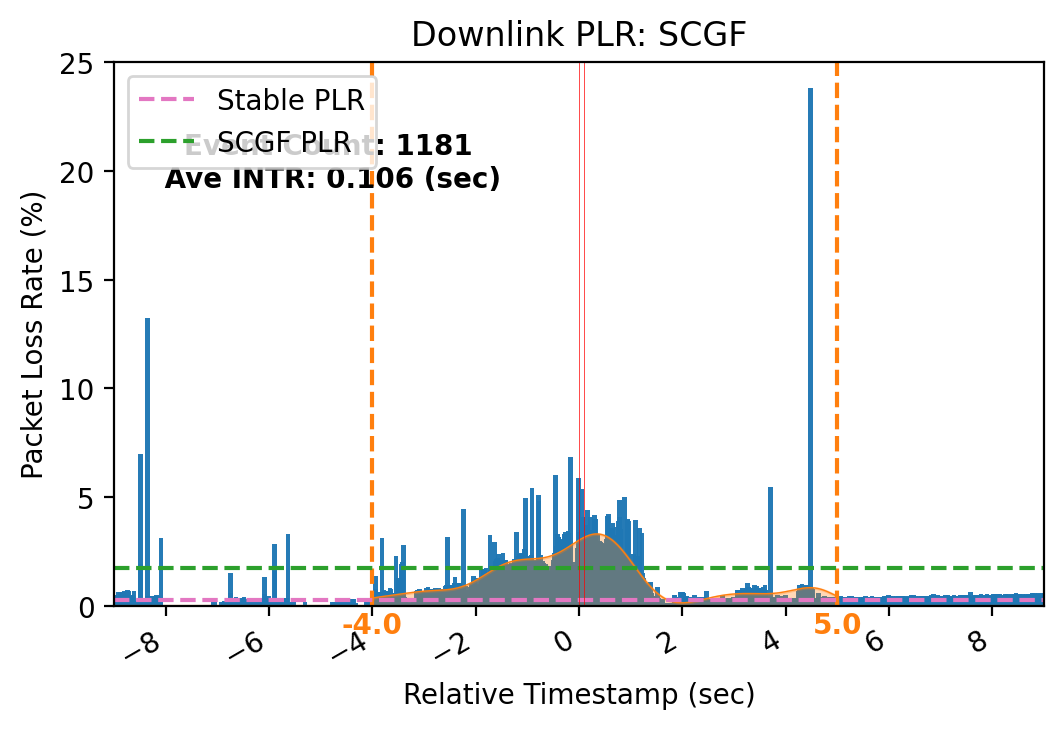

Number of Event: 1181
Average Duration: 0.10621187214225232 seconds
[(-9.0, 8.7)]
Uplink Stable PLR: 0.2428
Uplink PLR (-4.0, 5.0) 2.935


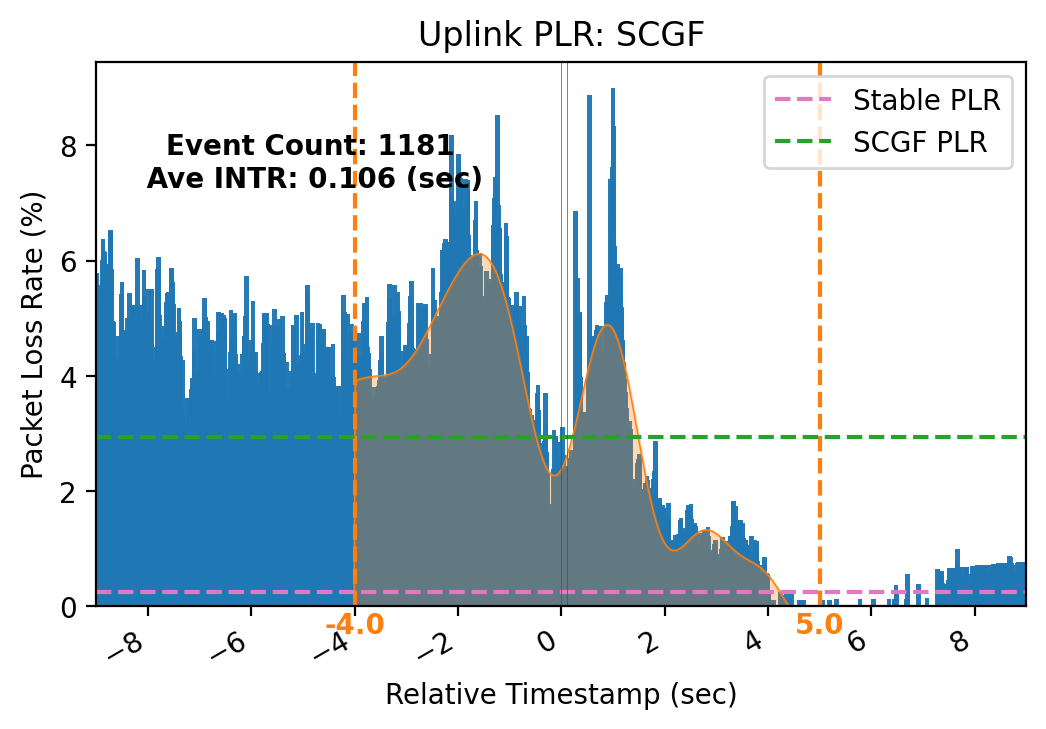

Number of Event: 1181
Average Duration: 0.10621187214225232 seconds
[(-8.7, 8.9), (-8.6, 9.0)]
Downlink Stable ELR: 0.8031
Downlink ELR (-4.0, 5.0) 6.04


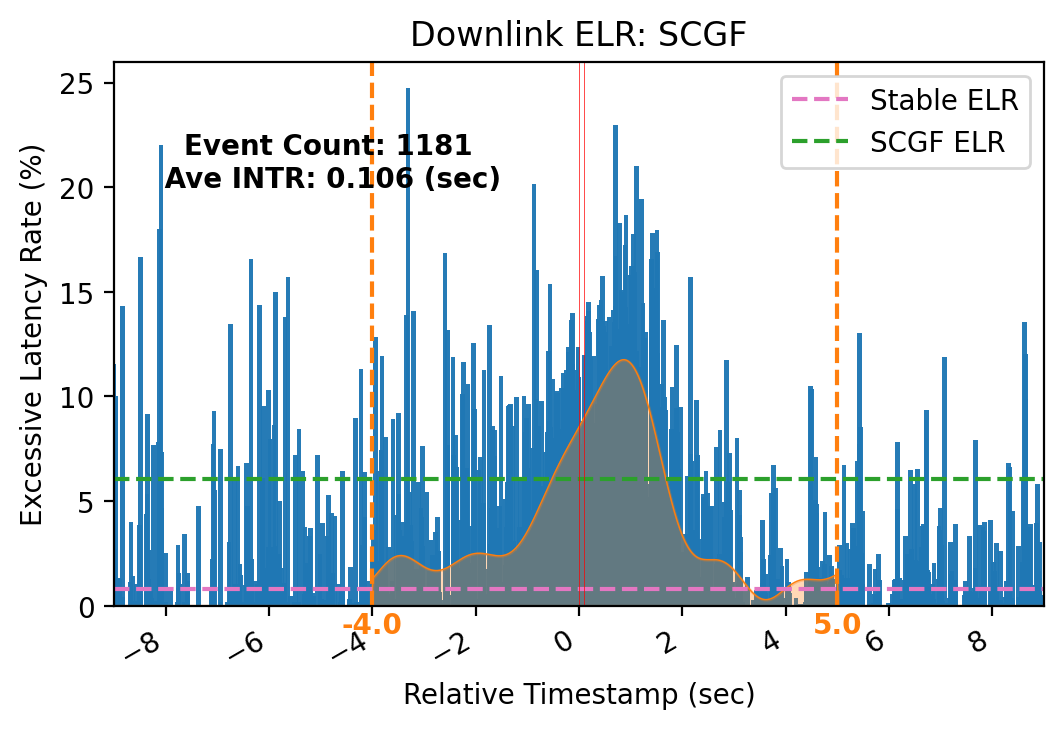

Number of Event: 1181
Average Duration: 0.10621187214225232 seconds
[(-9.0, 8.7)]
Uplink Stable ELR: 3.9737
Uplink ELR (-4.0, 5.0) 32.377


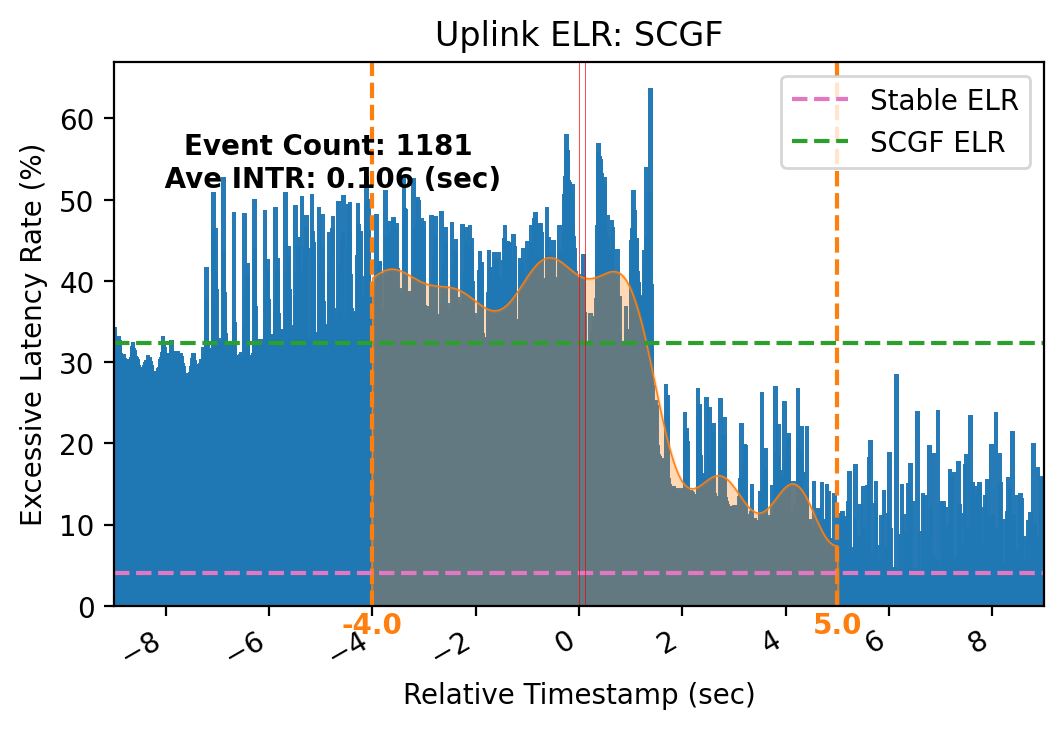

{'dl_lost': {'LTEH': (-4.0, 2.0),
             'ENBH': (-4.0, 2.5),
             'MCGH': (-3.0, 3.0),
             'MNBH': (-3.0, 3.0),
             'SCGM': (-3.0, 3.0),
             'SCGA': (-3.0, 2.5),
             'SCGR-I': (-3.5, 3.0),
             'SCGR-II': (-2.0, 3.0),
             'SCGC-I': (-3.0, 3.0),
             'SCGC-II': (-2.0, 2.0),
             'MCGF': (-5.0, 7.5),
             'NASR': (-4.0, 7.0),
             'SCGF': (-4.0, 5.0)},
 'ul_lost': {'LTEH': (-4.0, 2.0),
             'ENBH': (-4.0, 2.5),
             'MCGH': (-3.0, 3.0),
             'MNBH': (-3.0, 3.0),
             'SCGM': (-3.0, 3.0),
             'SCGA': (-3.0, 2.5),
             'SCGR-I': (-3.5, 3.0),
             'SCGR-II': (-2.0, 3.0),
             'SCGC-I': (-3.0, 3.0),
             'SCGC-II': (-2.0, 2.0),
             'MCGF': (-5.0, 7.5),
             'NASR': (-4.0, 7.0),
             'SCGF': (-4.0, 5.0)},
 'dl_excl': {'LTEH': (-4.0, 2.0),
             'ENBH': (-4.0, 2.5),
             'MCGH': (-3.0

In [134]:
# de-comment while not running the first time
D = HOType_D.copy()
E = HOType_E.copy()
scope = { mets: {
    tag: Category_scope[mets][category] for tag, category in lookup.items()
} for mets in ['dl_lost', 'ul_lost', 'dl_excl', 'ul_excl'] }

# *******************************************************************************************

import warnings

def heaviside(x, left, right):
    if x < left:
        return 0
    elif x > right:
        return 0
    else:
        return 1

coef_dl_lost = pd.DataFrame(columns=['lower_bd', 'upper_bd', *list(range(71))])
coef_ul_lost = pd.DataFrame(columns=['lower_bd', 'upper_bd', *list(range(71))])
coef_dl_excl = pd.DataFrame(columns=['lower_bd', 'upper_bd', *list(range(71))])
coef_ul_excl = pd.DataFrame(columns=['lower_bd', 'upper_bd', *list(range(71))])

new_scope = { mets: {
    tag: scp for tag, scp in scope[mets].items()
} for mets in ['dl_lost', 'ul_lost', 'dl_excl', 'ul_excl'] }

for tag in scope['dl_lost'].keys():
    if len(D[f'dl_lost'][tag]['intrs']) == 0 or len(D[f'ul_lost'][tag]['intrs']) == 0:
            continue
    print('===========================================================================================')
    print(tag)
        
    for mets in ['lost', 'excl']:
        for mode in ['dl', 'ul']:
            if mets == 'lost':
                stable_PLR = round(sum(E[f'{mode}_lost']['stable_miss']) / (sum(E[f'{mode}_lost']['stable_pkt']) + 1e-9) * 100, 4)
            elif mets == 'excl':
                stable_ELR = round(sum(E[f'{mode}_excl']['stable_miss']) / (sum(E[f'{mode}_excl']['stable_pkt']) + 1e-9) * 100, 4)
                
            table, intr = merge_profile(D[f'{mode}_{mets}'][tag]['tables'], D[f'{mode}_{mets}'][tag]['intrs'], mets=mets)
            
            print('Number of Event:', sum(D[f'{mode}_{mets}'][tag]['count']))
            print('Average Duration:', intr, 'seconds')
            
            if mets == 'lost':
                min_scope = approx_scope(table=table.copy(), mets=mets, evt_type=lookup[tag], stable_miss_rate=stable_PLR)
            elif mets == 'excl':
                min_scope = approx_scope(table=table.copy(), mets=mets, evt_type=lookup[tag], stable_miss_rate=stable_ELR)
            
            if min_scope != 0:
                new_scope[f'{mode}_{mets}'][tag] = min_scope
                
            fig, ax = plt.subplots(figsize=(6, 4))
            
            # *********************************************************
            min_scope = HOType_scope[f'{mode}_{mets}'][tag]
            new_scope[f'{mode}_{mets}'][tag] = min_scope
            # *********************************************************
            
            left = scope[f'{mode}_{mets}'][tag][0]
            right = scope[f'{mode}_{mets}'][tag][1]
            bound = math.ceil(max(abs(right), abs(left)))
            left = -bound; right = bound
            ax.set_xlim(left, right)
            
            # width = 0.015 * (right- left)
            width = 0.005 * (right- left)
            if mets == 'lost':
                ax.bar(table['cat_id'], table['PLR'], width=width, alpha=0.97)
            elif mets == 'excl':
                ax.bar(table['cat_id'], table['ELR'], width=width, alpha=0.97)
                
            ax.set_ylim(0, max(1, ax.get_ylim()[1]))
            bottom, top = ax.get_ylim()

            if min_scope != 0:
                ax.axvline(min_scope[0], color='tab:orange', linestyle='--')
                ax.text(min_scope[0], bottom-0.05*(top-bottom), '{:.1f}'.format(min_scope[0]), ha='center', fontweight='bold', fontsize=10, color='tab:orange')
                ax.axvline(min_scope[1], color='tab:orange', linestyle='--')
                ax.text(min_scope[1], bottom-0.05*(top-bottom), '{:.1f}'.format(min_scope[1]), ha='center', fontweight='bold', fontsize=10, color='tab:orange')
                
                bleft = min_scope[0]
                bright = min_scope[1]
                
                x = np.asarray(table['cat_id'], dtype=np.float64)
                if mets == 'lost':
                    y = np.asarray(table['PLR'], dtype=np.float64)
                elif mets == 'excl':
                    y = np.asarray(table['ELR'], dtype=np.float64)
                    
                with warnings.catch_warnings():
                    warnings.simplefilter('ignore', np.RankWarning)
                    z = np.polyfit(x, y, 70)
                    p = np.poly1d(z)
                xp = np.linspace(table['cat_id'].iloc[0], table['cat_id'].iloc[-1], 1000)
                
                coef = p.coefficients
                
                if mode == 'dl':
                    if mets == 'lost':
                        coef_dl_lost.loc[tag] = [bleft, bright, *list(coef)]
                    elif mets == 'excl':
                        coef_dl_excl.loc[tag] = [bleft, bright, *list(coef)]
                elif mode == 'ul':
                    if mets == 'lost':
                        coef_ul_lost.loc[tag] = [bleft, bright, *list(coef)]
                    elif mets == 'excl':
                        coef_ul_excl.loc[tag] = [bleft, bright, *list(coef)]
                
                ax.plot(xp, np.clip(p(xp)*np.vectorize(heaviside)(xp, bleft, bright), a_min=0, a_max=100), '-', c='tab:orange', lw=0.5)
                ax.fill_between(xp, np.clip(p(xp)*np.vectorize(heaviside)(xp, bleft, bright), a_min=0, a_max=100), color='tab:orange', alpha=0.3)
            
            if mets == 'lost':
                ax.axhline(stable_PLR, color='tab:pink', linestyle='--', label='Stable PLR')
                # ax.text(1.078*right, stable_PLR, '{:.4f}'.format(stable_PLR), ha='center', fontweight='bold', fontsize=10, color='tab:pink')
                if min_scope != 0:
                    _table = table[(table['cat_id'] >= min_scope[0]) & (table['cat_id'] < min_scope[1])].copy()
                    PLR = round(sum(_table['lost']) / (sum(_table['tx_count']) + 1e-9) * 100, 3)
                    if mode == 'dl':
                        print('Downlink Stable PLR:', stable_PLR)
                        print('Downlink PLR', min_scope, PLR)
                    elif mode == 'ul':
                        print('Uplink Stable PLR:', stable_PLR)
                        print('Uplink PLR', min_scope, PLR)
                    ax.axhline(PLR, color='tab:green', linestyle='--', label=f'{tag} PLR')
                    # ax.text(1.078*left, PLR, '{:.3f}'.format(PLR), ha='center', fontweight='bold', fontsize=10, color='tab:green')
            elif mets == 'excl':
                ax.axhline(stable_ELR, color='tab:pink', linestyle='--', label='Stable ELR')
                # ax.text(1.078*right, stable_ELR, '{:.4f}'.format(stable_ELR), ha='center', fontweight='bold', fontsize=10, color='tab:pink')
                if min_scope != 0:
                    _table = table[(table['cat_id'] >= min_scope[0]) & (table['cat_id'] < min_scope[1])].copy()
                    ELR = round(sum(_table['excl']) / (sum(_table['tx_count']) + 1e-9) * 100, 3)
                    if mode == 'dl':
                        print('Downlink Stable ELR:', stable_ELR)
                        print('Downlink ELR', min_scope, ELR)
                    elif mode == 'ul':
                        print('Uplink Stable ELR:', stable_ELR)
                        print('Uplink ELR', min_scope, ELR)
                    ax.axhline(ELR, color='tab:green', linestyle='--', label=f'{tag} ELR')
                    # ax.text(1.078*left, ELR, '{:.3f}'.format(ELR), ha='center', fontweight='bold', fontsize=10, color='tab:green')
                    
            count = sum(D[f'{mode}_{mets}'][tag]['count'])
            intr = round(intr, 3)
            ax.axvline(0, color='red', alpha=1, linestyle='-', linewidth=0.25)
            ax.axvline(intr, color='red', alpha=1, linestyle='-', linewidth=0.25)
            ax.text(left+0.23*(right-left), bottom+0.77*(top-bottom), f'Event Count: {count}\n Ave INTR: {intr} (sec)', ha='center', fontweight='bold', fontsize=10)
            
            if mode == 'dl':
                if mets == 'lost':
                    ax.set_title(f'Downlink PLR: {tag}')
                elif mets == 'excl':
                    ax.set_title(f'Downlink ELR: {tag}')
            elif mode == 'ul':
                if mets == 'lost':
                    ax.set_title(f'Uplink PLR: {tag}')
                elif mets == 'excl':
                    ax.set_title(f'Uplink ELR: {tag}')
            
            if mets == 'lost':
                ax.set_ylabel('Packet Loss Rate (%)')
            elif mets == 'excl':
                ax.set_ylabel('Excessive Latency Rate (%)')
            ax.set_xlabel('Relative Timestamp (sec)')
            ax.legend()
            
            plt.gcf().autofmt_xdate()
            plt.show()

pprint(new_scope, sort_dicts=False)

# HOType_D = D.copy()
# HOType_E = E.copy()
HOType_scope = new_scope.copy()

In [135]:
# HOType_scope = {
#     'dl_lost': {
#         'LTEH': (-0.1, 0.7),
#         'ENBH': (-0.1, 0.1),
#         'MCGH': (-1.1, 1.7),
#         'MNBH': (-1.1, 1.5),
#         'SCGM': (-1.1, 0.9),
#         'SCGA': (-0.1, 1.3),
#         'SCGR-I': (-1.1, 1.7),
#         'SCGR-II': (-1.1, 1.7),
#         'SCGC-I': (-0.1, 0.9),
#         'SCGC-II': (-1.1, 1.7),
#         'MCGF': (-2.1, 1.8),
#         'NASR': (-2.1, 1.8),
#         'SCGF': (-1.2, 1.2)
#     },
#     'ul_lost': {
#         'LTEH': (-0.1, 0.4),
#         'ENBH': (-0.2, 0.4),
#         'MCGH': (-0.1, 1.6),
#         'MNBH': (-0.1, 1.6),
#         'SCGM': (-0.3, 1.3),
#         'SCGA': (-0.1, 1.5),
#         'SCGR-I': (-0.3, 1.9),
#         'SCGR-II': (-0.1, 0.2),
#         'SCGC-I': (-0.1, 1.8),
#         'SCGC-II': (-0.1, 1.9),
#         'MCGF': (-1.2, 2.1),
#         'NASR': (-1.2, 2.1),
#         'SCGF': (-0.1, 1.8)
#     },
#     'dl_excl': {
#         'LTEH': (-6.8, 0.5),
#         'ENBH': (-3.7, 2.7),
#         'MCGH': (-0.1, 1.6),
#         'MNBH': (-1.0, 1.7),
#         'SCGM': (-0.3, 1.7),
#         'SCGA': (-0.1, 1.7),
#         'SCGR-I': (-7.0, 3.1),
#         'SCGR-II': (-7.0, 3.1),
#         'SCGC-I': (-0.1, 1.9),
#         'SCGC-II': (-0.1, 2.0),
#         'MCGF': (-1.7, 2.2),
#         'NASR': (-1.7, 2.2),
#         'SCGF': (-1.4, 1.9)
#     },
#     'ul_excl': {
#         'LTEH': (-0.1, 0.6),
#         'ENBH': (-0.1, 1.0),
#         'MCGH': (-0.1, 0.4),
#         'MNBH': (-2.9, 2.5),
#         'SCGM': (-5.9, 1.5),
#         'SCGA': (-0.2, 1.4),
#         'SCGR-I': (-6.6, 2.8),
#         'SCGR-II': (-0.1, 0.3),
#         'SCGC-I': (-0.1, 1.7),
#         'SCGC-II': (-0.1, 1.9),
#         'MCGF': (-1.0, 1.8),
#         'NASR': (-1.0, 2.1),
#         'SCGF': (-0.2, 1.6)
#     }
# }

## Final Scope

In [136]:
pprint(Initial_scope, sort_dicts=False)

# pprint(Category_D, sort_dicts=False)
# pprint(Category_E, sort_dicts=False)
pprint(Category_scope, sort_dicts=False)

# pprint(HOType_D, sort_dicts=False)
# pprint(HOType_E, sort_dicts=False)
pprint(HOType_scope, sort_dicts=False)

{'HO': (-10, 10), 'RLF': (-10, 10)}
{'dl_lost': {'HO': (-5.0, 5.0), 'RLF': (-9.0, 9.0)},
 'ul_lost': {'HO': (-5.0, 5.0), 'RLF': (-9.0, 9.0)},
 'dl_excl': {'HO': (-5.0, 5.0), 'RLF': (-9.0, 9.0)},
 'ul_excl': {'HO': (-5.0, 5.0), 'RLF': (-9.0, 9.0)}}
{'dl_lost': {'LTEH': (-4.0, 2.0),
             'ENBH': (-4.0, 2.5),
             'MCGH': (-3.0, 3.0),
             'MNBH': (-3.0, 3.0),
             'SCGM': (-3.0, 3.0),
             'SCGA': (-3.0, 2.5),
             'SCGR-I': (-3.5, 3.0),
             'SCGR-II': (-2.0, 3.0),
             'SCGC-I': (-3.0, 3.0),
             'SCGC-II': (-2.0, 2.0),
             'MCGF': (-5.0, 7.5),
             'NASR': (-4.0, 7.0),
             'SCGF': (-4.0, 5.0)},
 'ul_lost': {'LTEH': (-4.0, 2.0),
             'ENBH': (-4.0, 2.5),
             'MCGH': (-3.0, 3.0),
             'MNBH': (-3.0, 3.0),
             'SCGM': (-3.0, 3.0),
             'SCGA': (-3.0, 2.5),
             'SCGR-I': (-3.5, 3.0),
             'SCGR-II': (-2.0, 3.0),
             'SCGC-I':

In [137]:
save_dir = "/Users/jackbedford/Desktop/MOXA/Code/results/ho_coef"

coef_dl_lost.to_csv(os.path.join(save_dir, "coef_dl_lost.csv"), index=False)
coef_ul_lost.to_csv(os.path.join(save_dir, "coef_ul_lost.csv"), index=False)
coef_dl_excl.to_csv(os.path.join(save_dir, "coef_dl_excl.csv"), index=False)
coef_ul_excl.to_csv(os.path.join(save_dir, "coef_ul_excl.csv"), index=False)